## New directions:
* Purpose: Solve noisy prediction
1. **Solution 1:** Reduce resolution 1s -> 10s
2. **Solution 2:** Separate into 2 sub-problems (2 models)
    * Model 1: ObsID-wise average background spectrum prediction -> aggregate along time
    * Model 2: Total count for each seconds (lightcurve) -> aggregate along channels
        * These are based on actual use case
3. **Solution 3:** Reduce number of channels, then learn the mapping function back to 1500
    * Potential solution: Use 1D ConvNet

In [1]:
import os
import numpy as np
import pandas as pd
# from astropy.io import fits
# from astropy.table import Table
import pickle as pkl
import random

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from tqdm.notebook import tqdm

%load_ext autoreload
%autoreload 2
import config
from config import *
from models import *

import subprocess as subp
import multiprocessing
from multiprocessing import Pool
n_cpus = multiprocessing.cpu_count()
print('Num CPU cores:', n_cpus)

import psutil
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('This runtime has {:.1f} gigabytes of available RAM.'.format(ram_gb))
print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')

!nvidia-smi

Num CPU cores: 64
This runtime has 540.6 gigabytes of available RAM.
RAM Used: 12.5 Gb
Fri Mar 22 14:27:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100 80GB PCIe          On  | 00000000:21:00.0 Off |                    0 |
| N/A   31C    P0              43W / 300W |      4MiB / 81920MiB |      0%      Default |
|                                         |                      |     

## I. Data Preparation
----

There are 2 data to be merge to a single dataframe:
1. `input_features`: 
    * set of input features about the env and telescope condition (e.g: position, day, sunlight, angle, etc)
    * 46 features (excluding `R1`, `TIME`, and `bID`, `FPM_XRAY_PI_xxxx_xxxx`).
    * Input variables description: https://heasarc.gsfc.nasa.gov/lheasoft/ftools/headas/niprefilter2.html
    * We exclude bID since for generalization to new background region.
    * Input feature set:
        * 01 `ROLL [deg]`: pointing axis roll
        * 02 `SAT_LAT [deg]`: sub-satellite latitude (ground-reference)
        * 03 `SAT_LON [deg]`: sub-satellite longitude (ground-reference)
        * 04 `SAT_ALT [km]`: altitude / distance from Earth's center
        * 05 `ELV [deg]`: angle b/w pointing and Earth limb
        * 06 `BR_EARTH [deg]`: angle b/w pointing & bright Earth
        * 07 `SUNSHINE [bool]`: whether there is the Sunlight
        * 08 `TIME_SINCE_SUNSET [s]`: time since sunset
        * 09 `SUN_ANGLE [deg]`: angle between pointing & sun vector
        * 10 `BETA_ANGLE`: 
        * 11 `LOCAL_TIME`: ISS time?
        * 12 `MOON_ANGLE [deg]`: angle between pointing and moon vector
        * 13 `RAM_ANGLE [deg]`: angle between pointing and velocity vector
        * 14 `EAST_ANGLE`:
        * 15 `ANG_DIST [deg]`: angular distance of pointing from nominal
        * 16 `SAA [bool]`: South Atlantic Anomaly
        * 17 `SAA_TIME [s]`: time since entering/exiting SAA
        * 18 `COR_ASCA [GeV/c]`: magnetic cut off rigidity (ASCA map)
        * 19 `COR_SAX [GeV/c]`: magnetic cut off rigidity (ASCA map)
        * 20 `MCILWAIN_L`: McIlwain L parameter (SAX) describing Magnetic Field Lines
        * 21 `MAGFIELD`:
        * 22 `MAGFIELD_MIN`:
        * 23 `MAG_ANGLE`:
        * 24 `AP8MIN`:
        * 25 `AE8MIN`:
        * 26 `ATT_ANG_AZ [deg]`: Pointing azimuth angle
        * 27 `ATT_ANG_EL [deg]`: Pointing elevation angle
        * 28 `FPM_RATIO_REJ_COUNT`: Total PI_RATIO-rejected count
        * (EXCLUDE) 29-34 `FPM_XRAY_PI_xxxx_yyyy`: X-Ray rate at different Energy Spectrums (xxxx to yyyy keV)
        * (EXCLUDE) 35 `FPM_XRAY_PI_COUNT`: total count?
        * 36 `FPM_OVERONLY_COUNT`: Per-FPM over-only reset count from events
        * 37 `FPM_UNDERONLY_COUNT`: Per-FPM under-only reset count from events
        * 38 `FPM_DOUBLE_COUNT`: Per-FPM over+under reset count from events
        * 39 `FPM_FT_COUNT`: Per-FPM Forced Triggered count from events
        * 40 `FPM_NOISE25_COUNT`: Per-FPM noise count <0.25 keV from events
        * 41 `XTI_PNT_JITTER`: Instrument 1-second pointing jitter (NICERV3)
        * 42 `KP`: Potsdam planetary Kp index -> reflect Aurora strength -> Solar Weather activity
        * 43 `SOLAR_PHI [GV]`: Solar modulation potential
        * 44 `COR_NYM [GeV/c]`: Adjusted COR
        * 45 `ANG_DIST_X [arcsec]`: Target position in instrument X coordinates
        * 46 `ANG_DIST_Y [arcsec]`: Target position in instrument X coordinates
2. `data_specs`: 
    * set of X-Ray spectra by bands/channels
    * 22 X-Ray bands/channels

In [2]:
# pd.read_csv('/group/wanglei/data/QG_outputs/input_features.csv', encoding='utf-8')
# pd.read_csv('/group/wanglei/data/QG_outputs/full_spectras.csv', encoding='utf-8')
# pd.read_csv('/group/wanglei/data/QG_outputs/position_new_features.csv')

### 1. Data loading

In [2]:
"""===========================
            1. Load X
==========================="""
try:
    data_features
except:
    data_features = pd.read_csv(path_new_features_csv)
    
#     data_features = np.load(path_all_features_npy, allow_pickle=True)
#     data_features = pd.DataFrame.from_records(data_features)
    feature_list = list(data_features.columns.astype(str))
    
    """ 
        Assuming indexes between features & specs match and sorted,
        sample only half of the dataset
    """
    data_features.drop([i for i in data_features.index if i%2 == 1], inplace=True)
    print('X ready.')
    print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')
    
"""===========================
        2. Load Y
==========================="""
try:
    data_specs
except:
    data_specs = pd.read_csv(path_spec_full_csv, chunksize=10000)
    data_specs = pd.concat(data_specs)
    # data_specs = np.load(path_spec_full_npy, allow_pickle=True)
    # data_specs = pd.DataFrame.from_records(data_specs)
    
    """ Range of predicted energy channels"""
    spec_list = config.energy_bins
    # spec_list = [e for e in spec_list if int(e)%2 == 0]
    
    """ 
        Assuming indexes between features & specs match and sorted,
        sample only half of the dataset
    """
    # data_specs = data_specs.iloc[::2, :]
    data_specs.drop([i for i in data_specs.index if i%2 == 1], inplace=True)
    neg_indexes = data_specs[data_specs.sum(axis=1) < 0].index
    data_specs = data_specs.drop(neg_indexes)
    print('y ready.')

"""============================================
    3. Extract only Overlapping X and Y
============================================"""
overlap_indexes = list(set(set(data_features.index) & set(data_specs.index)))
data_features = data_features.loc[overlap_indexes]
data_specs = data_specs.loc[overlap_indexes]
    
display(data_features)
display(data_specs)
print(data_features.isna().sum().sum())
print(data_specs.isna().sum().sum())

print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')

X ready.
RAM Used: 13.99 Gb
y ready.


TIME      ROLL  SAT_LAT   SAT_LON      SAT_ALT        ELV  \
0        112367256.5  232.4563  37.6229  214.7518  6775.717285  67.261162   
2        112367258.5  232.4951  37.5424  214.8719  6775.738281  67.392433   
4        112367260.5  232.5521  37.4617  214.9916  6775.759766  67.522514   
6        112367262.5  232.5780  37.3809  215.1112  6775.780762  67.654686   
8        112367264.5  232.6412  37.3000  215.2304  6775.802246  67.784668   
...              ...       ...      ...       ...          ...        ...   
3037642  297204522.5   60.4836 -32.1419  166.3270  6797.324219  83.964920   
3037644  297204524.5   60.6628 -32.0539  166.4301  6797.311035  83.931259   
3037646  297204527.5   60.9822 -31.9216  166.5843  6797.291504  83.858940   
3037648  297204529.5   61.1713 -31.8333  166.6868  6797.278320  83.811455   
3037650  297204531.5   61.3351 -31.7449  166.7891  6797.265137  83.762390   

          BR_EARTH  SUNSHINE  TIME_SINCE_SUNSET  SUN_ANGLE  ...     R1   bID  \
0        73.780037       1.0                0.0  90.167892  ...    2.0  b4.2   
2        73.829636       1.0                0.0  90.170227  ...    0.0  b4.2   
4        73.877724       1.0                0.0  90.170227  ...    1.0  b4.2   
6        73.929939       1.0                0.0  90.174042  ...    1.0  b4.2   
8        73.979691       1.0                0.0  90.174934  ...    1.0  b4.2   
...            ...       ...                ...        ...  ...    ...   ...   
3037642  83.964920       1.0                0.0  92.498085  ...   95.0  b5.5   
3037644  83.931259       1.0                0.0  92.492851  ...  110.0  b5.5   
3037646  83.858940       1.0                0.0  92.493797  ...  104.0  b5.5   
3037648  83.811455       1.0                0.0  92.493790  ...   91.0  b5.5   
3037650  83.762390       1.0                0.0  92.491417  ...  104.0  b5.5   

              obsID  FPM_TRUMP_SEL_1500_1800  FPM_RATIO_REJ_300_1800  \
0        1012040102                      0.0                0.000000   
2        1012040102                      0.0                0.000000   
4        1012040102                      0.0                0.000000   
6        1012040102                      0.0                0.017857   
8        1012040102                      0.0                0.000000   
...             ...                      ...                     ...   
3037642  6012050214                      0.0                0.000000   
3037644  6012050214                      0.0                0.000000   
3037646  6012050214                      0.0                0.000000   
3037648  6012050214                      0.0                0.017857   
3037650  6012050214                      0.0                0.000000   

         FPM_SLOW_LLD  MPU_NOISE20_COUNT  MPU_NOISE25_COUNT  \
0            0.725515           8.214286           3.482143   
2            0.725529           8.071429           3.392857   
4            0.725501           7.964286           3.285714   
6            0.725472           7.767857           3.053571   
8            0.725544           7.910714           3.214286   
...               ...                ...                ...   
3037642      0.744405           5.517857           0.071429   
3037644      0.744434           5.767857           0.035714   
3037646      0.744390           5.375000           0.089286   
3037648      0.744419           4.928571           0.071429   
3037650      0.744376           5.589286           0.160714   

         MPU_OVERONLY_COUNT  MPU_UNDERONLY_COUNT  
0                  0.232143             7.857143  
2                  0.178571             7.785714  
4                  0.321429             7.821429  
6                  0.232143             7.767857  
8                  0.232143             7.875000  
...                     ...                  ...  
3037642            0.107143           420.714286  
3037644            0.160714           422.214286  
3037646            0.089286           422.785714 

20  21  22  23  24  25  26  27  28  29  ...  1190  1191  1192  1193  \
0         0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0   
2         0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0   
4         0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0   
6         0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0   
8         0   0   0   0   1   0   0   0   0   0  ...     0     0     0     0   
...      ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   ...   ...   ...   ...   
3037642   0   0   0   0   0   0   0   1   0   0  ...     0     0     0     0   
3037644   0   0   0   0   0   0   0   1   0   0  ...     0     0     0     0   
3037646   0   0   0   0   1   0   1   0   0   0  ...     0     0     0     0   
3037648   0   0   0   0   0   0   0   0   0   1  ...     0     0     0     0   
3037650   0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0   

         1194  1195  1196  1197  1198  1199  
0           0     0     0     0     0     0  
2           0     0     0     0     0     0  
4           0     0     0     0     0     0  
6           0     0     0     0     0     0  
8           0     0     0     0     0     0  
...       ...   ...   ...   ...   ...   ...  
3037642     0     0     0     0     0     0  
3037644     0     0     0     0     0     0  
3037646     0     0     0     0     0     0  
3037648     0     0     0     0     0     0  
3037650     0     0     0     0     0     0  

[1518608 rows x 1180 columns]

0
0
RAM Used: 28.8 Gb


### 2. Merging Data
1. Merge Input Features & Target Photon Counts
2. Merge ObsIDs to Input Features
3. Merge New Input Features

**This is to put X and y indexes in correct order. Initially, they are not in correct order**

In [3]:
"""==========================================================
    4. Merge input features with target photon counts
=========================================================="""
if 'df' not in globals():
    assert (data_features.index == data_specs.index).all()
    
    df = data_features.join(data_specs, rsuffix='spec_') # join on index
    df = df.dropna()
    df.columns = df.columns.astype(str)
    del data_features, data_specs

    """ 3. convert columns to float32 for optimization"""
    for col in tqdm(df.columns):
        if col != 'bID' and col != 'TIME' and col in feature_list:
            df[col] = round(df[col].astype(np.float32), 4)
    display(df)
    print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')
else:
    pass
print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')

"""========================================================== 
    5. Merge Observation IDs to Input Features
=========================================================="""
if 'obsid_df' not in globals():
    join_features = ['ROLL', 'SAT_LAT', 'SAT_LON']
    position_obs = pd.read_csv('POSITION_OBSID.csv').dropna()

    """ Map Join features to int for merging"""
    for fname in join_features:
        position_obs[fname] = (position_obs[fname] * 1e3).astype(int)
        df[fname] = (df[fname] * 1e3).astype(int)
    """ Merge obsid based on join features"""
    df['orig_index'] = df.index
    obsid_df = pd.merge(position_obs, df[join_features+['orig_index']], on=join_features, how='inner')
    obsid_df.index = obsid_df.orig_index
    """ Map Join features back to float"""
    for fname in join_features:
        df[fname] = (df[fname] / 1e3).astype(float)  
    display(obsid_df)
    del position_obs
print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')

TIME        ROLL    SAT_LAT     SAT_LON      SAT_ALT  \
0        112367256.5  232.456299  37.622898  214.751801  6775.717773   
2        112367258.5  232.495102  37.542400  214.871902  6775.738281   
4        112367260.5  232.552094  37.461700  214.991592  6775.759766   
6        112367262.5  232.578003  37.380901  215.111206  6775.780762   
8        112367264.5  232.641205  37.299999  215.230392  6775.802246   
...              ...         ...        ...         ...          ...   
3037642  297204522.5   60.483601 -32.141899  166.326996  6797.324219   
3037644  297204524.5   60.662800 -32.053902  166.430099  6797.311035   
3037646  297204527.5   60.982201 -31.921600  166.584305  6797.291016   
3037648  297204529.5   61.171299 -31.833300  166.686798  6797.278320   
3037650  297204531.5   61.335098 -31.744900  166.789093  6797.264648   

               ELV   BR_EARTH  SUNSHINE  TIME_SINCE_SUNSET  SUN_ANGLE  ...  \
0        67.261200  73.779999       1.0                0.0  90.167900  ...   
2        67.392403  73.829597       1.0                0.0  90.170197  ...   
4        67.522499  73.877701       1.0                0.0  90.170197  ...   
6        67.654701  73.929901       1.0                0.0  90.174004  ...   
8        67.784698  73.979698       1.0                0.0  90.174896  ...   
...            ...        ...       ...                ...        ...  ...   
3037642  83.964897  83.964897       1.0                0.0  92.498100  ...   
3037644  83.931297  83.931297       1.0                0.0  92.492798  ...   
3037646  83.858902  83.858902       1.0                0.0  92.493797  ...   
3037648  83.811501  83.811501       1.0                0.0  92.493797  ...   
3037650  83.762398  83.762398       1.0                0.0  92.491402  ...   

         1190  1191  1192  1193  1194  1195  1196  1197  1198  1199  
0           0     0     0     0     0     0     0     0     0     0  
2           0     0     0     0     0     0     0     0     0     0  
4           0     0     0     0     0     0     0     0     0     0  
6           0     0     0     0     0     0     0     0     0     0  
8           0     0     0     0     0     0     0     0     0     0  
...       ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
3037642     0     0     0     0     0     0     0     0     0     0  
3037644     0     0     0     0     0     0     0     0     0     0  
3037646     0     0     0     0     0     0     0     0     0     0  
3037648     0     0     0     0     0     0     0     0     0     0  
3037650     0     0     0     0     0     0     0     0     0     0  

[1518608 rows x 1237 columns]

RAM Used: 28.27 Gb
RAM Used: 28.27 Gb


obsID    ROLL  SAT_LAT  SAT_LON  FOV_FLAG  ST_BBO  ST_VALID  \
orig_index                                                                     
59940       1012010101  227891     5368   242626       0.0     0.0       1.0   
59942       1012010101  227777     5266   242699       0.0     0.0       1.0   
59946       1012010101  227704     5063   242844       0.0     0.0       1.0   
59950       1012010101  227603     4860   242989       0.0     0.0       1.0   
59954       1012010101  227468     4657   243134       0.0     0.0       1.0   
...                ...     ...      ...      ...       ...     ...       ...   
3033726     6012080109  271241    32741   141815       0.0     0.0       1.0   
3033728     6012080109  271265    32872   141972       0.0     0.0       1.0   
3033730     6012080109  271299    33047   142183       0.0     0.0       1.0   
3033734     6012080109  271353    33222   142395       0.0     0.0       1.0   
3033736     6012080109  271415    33483   142714       0.0     0.0       1.0   

            ST_OBJECTS  ST_VIDEO_VDC  ST_STARS  orig_index  
orig_index                                                  
59940             26.0        2.1898      22.0       59940  
59942             26.0        2.1898      23.0       59942  
59946             23.0        2.1898      19.0       59946  
59950             25.0        2.1898      23.0       59950  
59954             25.0        2.1898      22.0       59954  
...                ...           ...       ...         ...  
3033726           21.0        2.1703      17.0     3033726  
3033728           22.0        2.1898      16.0     3033728  
3033730           22.0        2.1898      17.0     3033730  
3033734           23.0        2.1703      17.0     3033734  
3033736           22.0        2.1898      17.0     3033736  

[1142041 rows x 11 columns]

RAM Used: 28.68 Gb


## 3. Spectra Investigation
----
* Comment:
    1. 22 Energy bins for 1s period
    2. Most spectral bins have only $\leq$ 1 photons at any particular second.
    3. Some spectral bins have very high photon counts at some timestep (1000-5000)
    4. There can be multiple bins with 1 photon

## 4. Split Train-Val-Test

In [4]:
from scipy.stats import pearsonr

""" 
    1. Filter columns
        'R1': spectral variable -> avoid leakage problem
        'TIME': time is seconds -> not repeatable / generalizable
        'bID': background ID    -> not repeatable / generalizable 
                                   (we may need to predict background spectra of a new region)
        'FPM_RATIO_REJ_COUNT'   -> include?
        'FPM_XRAY_PI_xxxx_yyyy' -> spectrum leakage
        'FPM_XRAY_PI_COUNT'     -> spectrum leakage
        'FPM_*'                 -> include?
"""


""" 1. Split input & target"""
if 'X' not in globals():
    # dropped_columns = ['R1', 'TIME', 'bID', 'ST_VALID', 'obsID'] \
    #                 + [fname for fname in feature_list if 'FPM_XRAY' in fname]
    input_features = config.input_features
    
    # input_features = ['ROLL', 'COR_SAX', 'MCILWAIN_L', 'MAGFIELD_MIN',
    #                   'FPM_DOUBLE_COUNT', 'FPM_OVERONLY_COUNT', 'FPM_UNDERONLY_COUNT',  
    #                   'SUNSHINE', 'SUN_ANGLE', 'BR_EARTH',
    #                   'SOLAR_PHI', 'KP', 'MAGFIELD',
    #                   'FPM_RATIO_REJ_COUNT', 'FPM_NOISE25_COUNT', 'FPM_FT_COUNT']
    
    # X = df.loc[:, input_features].astype(float)
    # y = df.loc[:, spec_list].astype(float)
    X = df.loc[:, input_features]
    y = df.loc[:, spec_list]
    df_metadata = df.loc[:, ['TIME', 'bID', 'obsID']]
    assert len(X) == len(y)
    del df
else:
    assert len(X) == len(y)

display(X[:5])
display(y[:5])

ROLL  SAT_LAT  SAT_LON      SAT_ALT        ELV   BR_EARTH  SUNSHINE  \
0  232.456   37.622  214.751  6775.717773  67.261200  73.779999       1.0   
2  232.495   37.542  214.871  6775.738281  67.392403  73.829597       1.0   
4  232.552   37.461  214.991  6775.759766  67.522499  73.877701       1.0   
6  232.578   37.380  215.111  6775.780762  67.654701  73.929901       1.0   
8  232.641   37.299  215.230  6775.802246  67.784698  73.979698       1.0   

   TIME_SINCE_SUNSET  SUN_ANGLE  BETA_ANGLE  ...  COR_NYM  ANG_DIST_X  \
0                0.0  90.167900   71.304199  ...   5.2875   27.885599   
2                0.0  90.170197   71.304298  ...   5.3034   23.122499   
4                0.0  90.170197   71.304398  ...   5.3194   24.921499   
6                0.0  90.174004   71.304497  ...   5.3355   16.367100   
8                0.0  90.174896   71.304497  ...   5.3516   14.514200   

   ANG_DIST_Y  FPM_TRUMP_SEL_1500_1800  FPM_RATIO_REJ_300_1800  FPM_SLOW_LLD  \
0  -41.483200                      0.0                  0.0000        0.7255   
2  -33.419998                      0.0                  0.0000        0.7255   
4  -30.737301                      0.0                  0.0000        0.7255   
6  -18.738300                      0.0                  0.0179        0.7255   
8  -15.805600                      0.0                  0.0000        0.7255   

   MPU_NOISE20_COUNT  MPU_NOISE25_COUNT  MPU_OVERONLY_COUNT  \
0             8.2143             3.4821              0.2321   
2             8.0714             3.3929              0.1786   
4             7.9643             3.2857              0.3214   
6             7.7679             3.0536              0.2321   
8             7.9107             3.2143              0.2321   

   MPU_UNDERONLY_COUNT  
0               7.8571  
2               7.7857  
4               7.8214  
6               7.7679  
8               7.8750  

[5 rows x 46 columns]

20  21  22  23  24  25  26  27  28  29  ...  1190  1191  1192  1193  1194  \
0   0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0     0   
2   0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0     0   
4   0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0     0   
6   0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0     0   
8   0   0   0   0   1   0   0   0   0   0  ...     0     0     0     0     0   

   1195  1196  1197  1198  1199  
0     0     0     0     0     0  
2     0     0     0     0     0  
4     0     0     0     0     0  
6     0     0     0     0     0  
8     0     0     0     0     0  

[5 rows x 1180 columns]

Total backgrounds = 39
	 Val backgrounds: ['b4.2', 'b4.3', 'b4.4']
	 Test backgrounds: ['b5.1', 'b5.2', 'b5.3', 'b5.4', 'b5.5']
%Train = 0.7948717948717948
%Train = 0.07692307692307693
%Test = 0.1282051282051282
# Training samples = 1208935.
# Training samples = 123726.
# Testing samples = 185947.
Index(['ROLL', 'SAT_LAT', 'SAT_LON', 'SAT_ALT', 'ELV', 'BR_EARTH', 'SUNSHINE',
       'TIME_SINCE_SUNSET', 'SUN_ANGLE', 'BETA_ANGLE', 'LOCAL_TIME',
       'MOON_ANGLE', 'RAM_ANGLE', 'EAST_ANGLE', 'ANG_DIST', 'SAA', 'SAA_TIME',
       'COR_ASCA', 'COR_SAX', 'MCILWAIN_L', 'MAGFIELD', 'MAGFIELD_MIN',
       'MAG_ANGLE', 'AP8MIN', 'AE8MIN', 'ATT_ANG_AZ', 'ATT_ANG_EL',
       'FPM_RATIO_REJ_COUNT', 'FPM_OVERONLY_COUNT', 'FPM_UNDERONLY_COUNT',
       'FPM_DOUBLE_COUNT', 'FPM_FT_COUNT', 'FPM_NOISE25_COUNT',
       'XTI_PNT_JITTER', 'KP', 'SOLAR_PHI', 'COR_NYM', 'ANG_DIST_X',
       'ANG_DIST_Y', 'FPM_TRUMP_SEL_1500_1800', 'FPM_RATIO_REJ_300_1800',
       'FPM_SLOW_LLD', 'MPU_NOISE20_COUNT', 'MPU_NOI

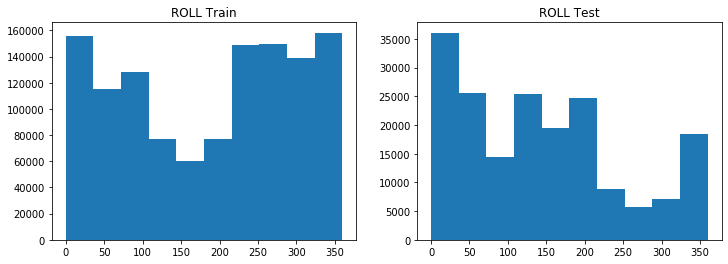

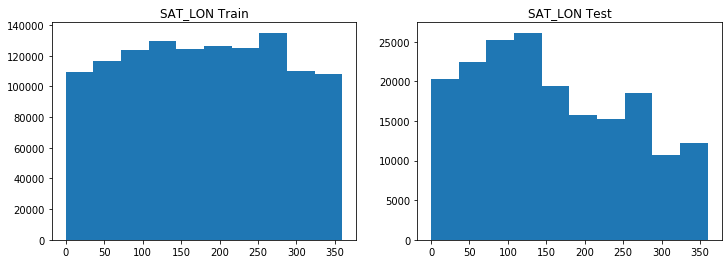

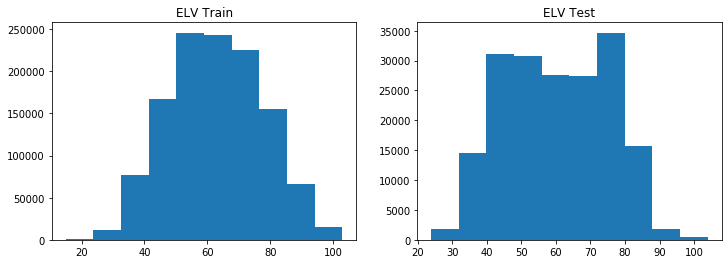

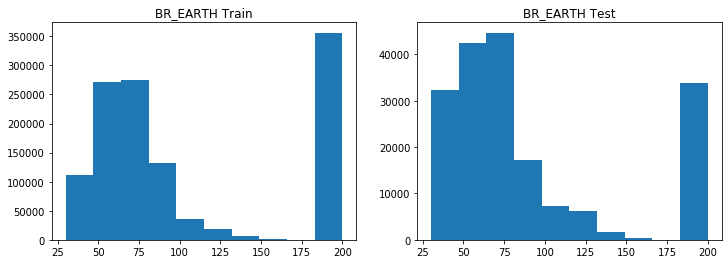

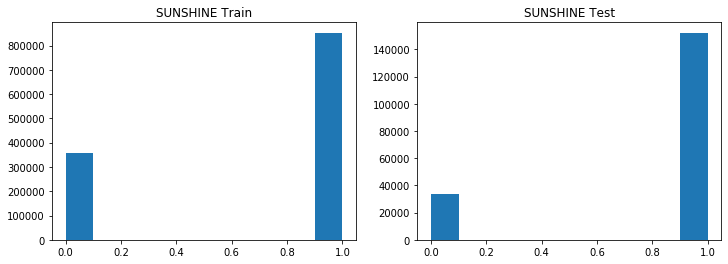

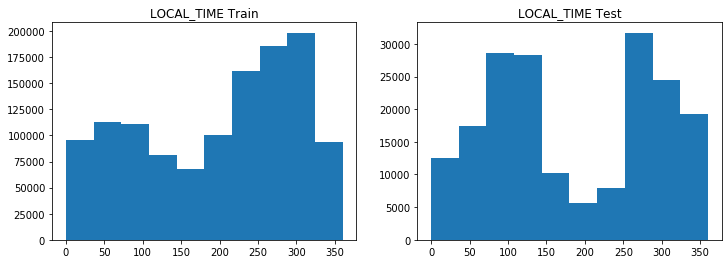

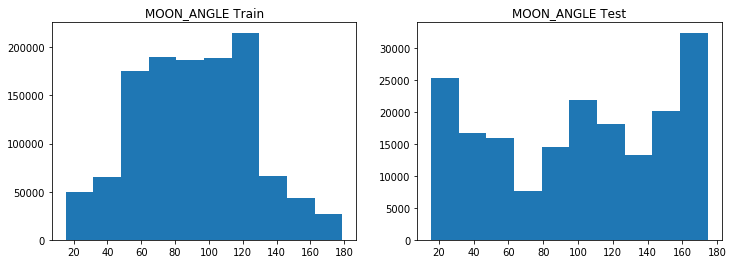

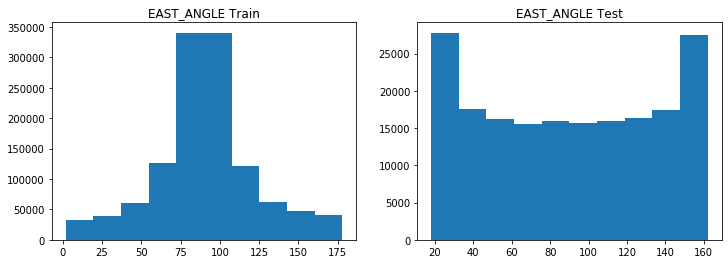

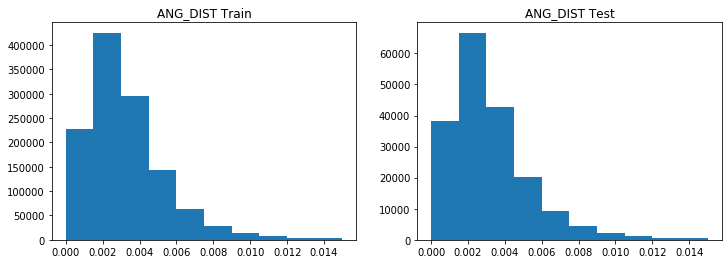

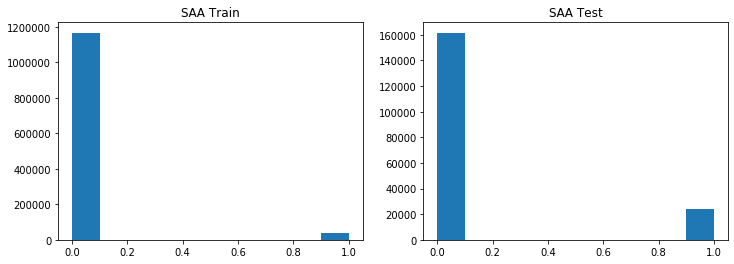

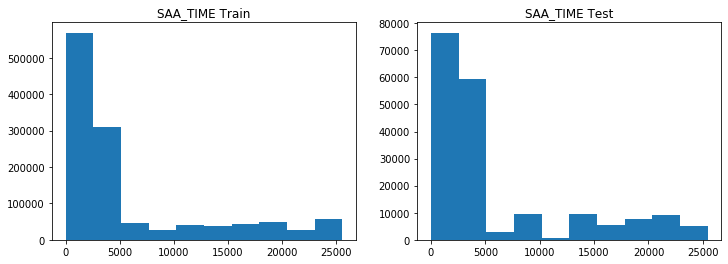

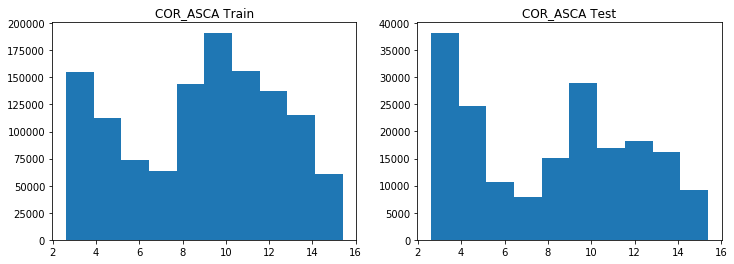

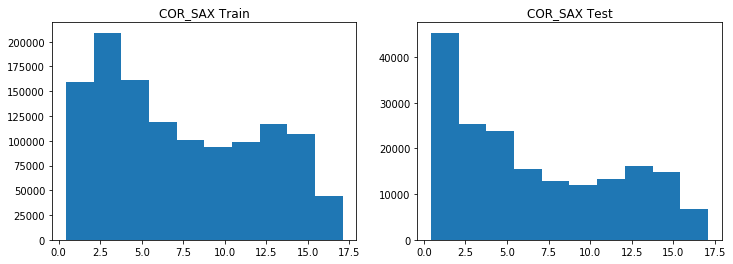

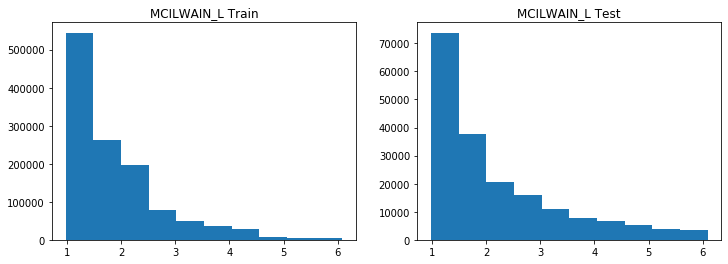

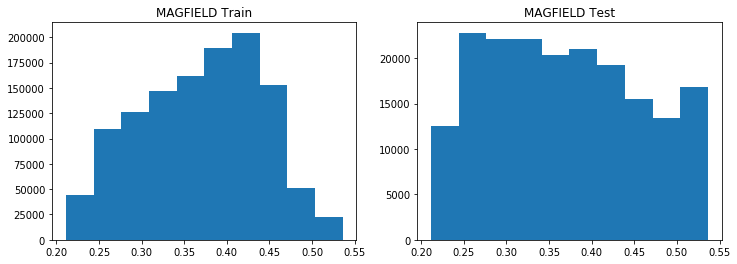

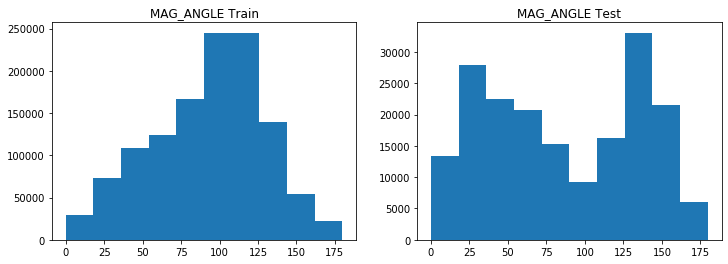

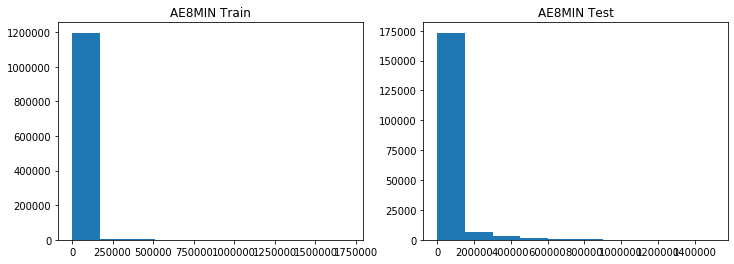

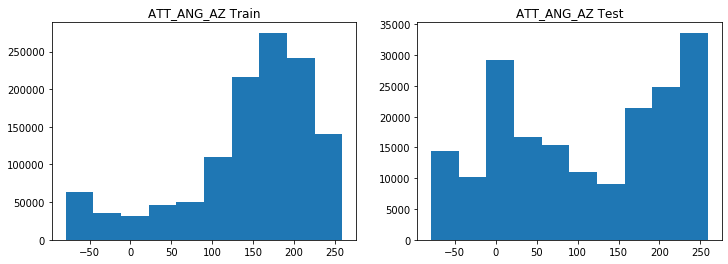

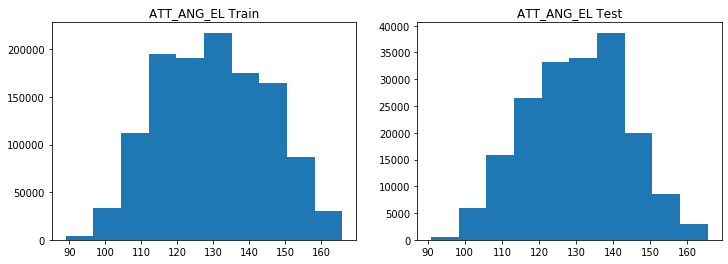

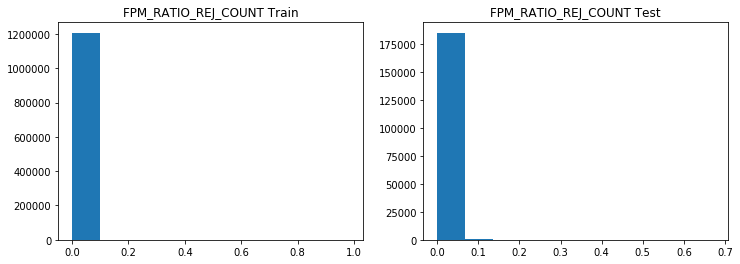

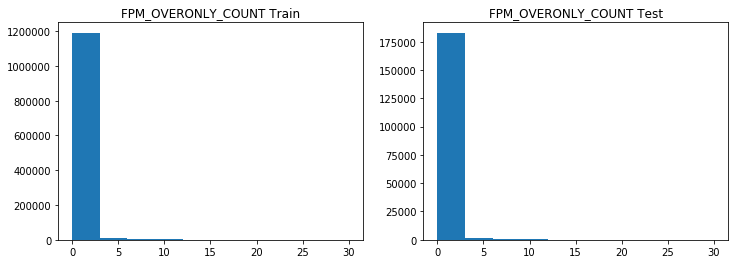

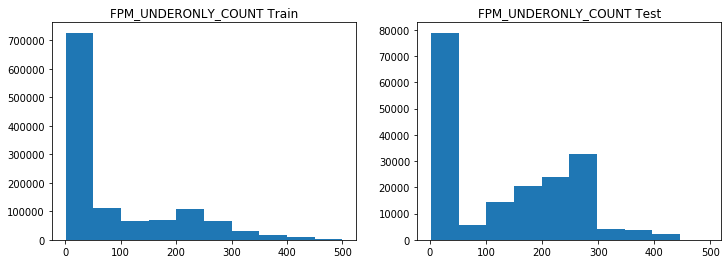

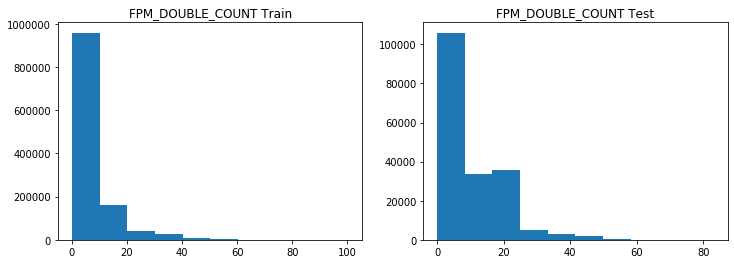

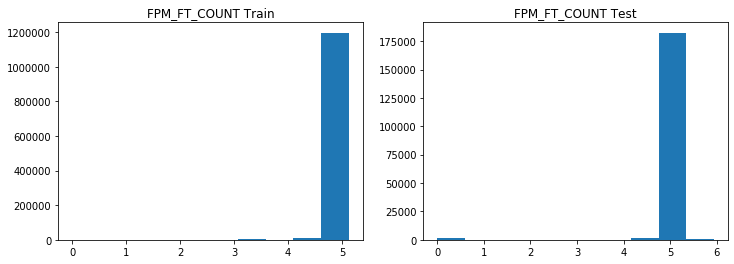

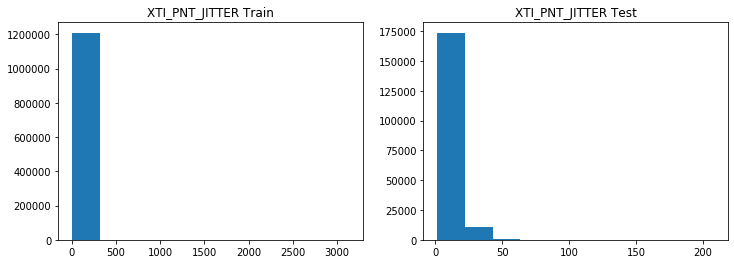

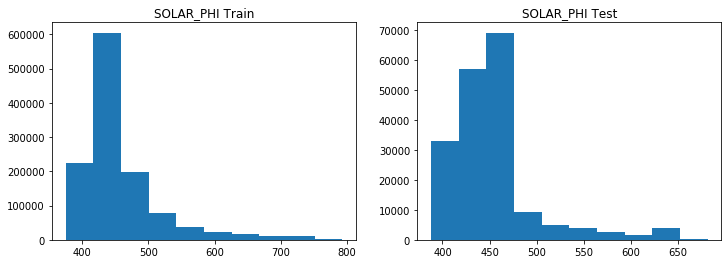

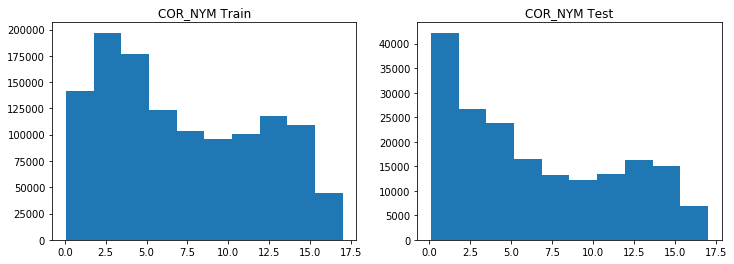

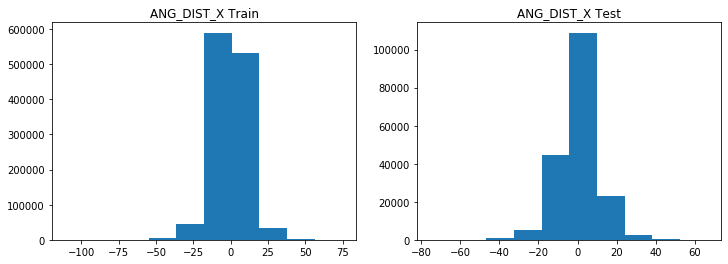

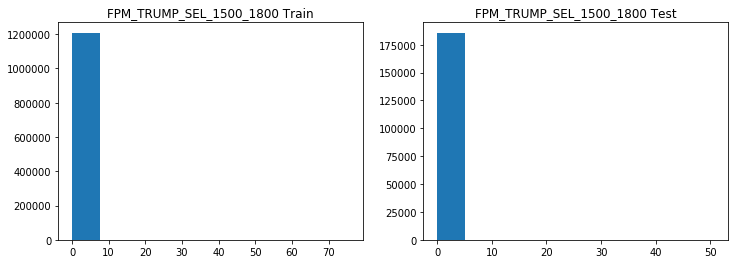

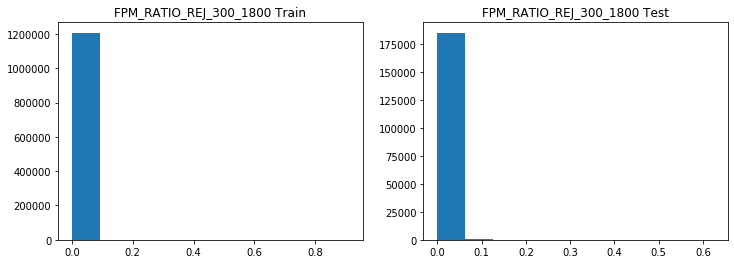

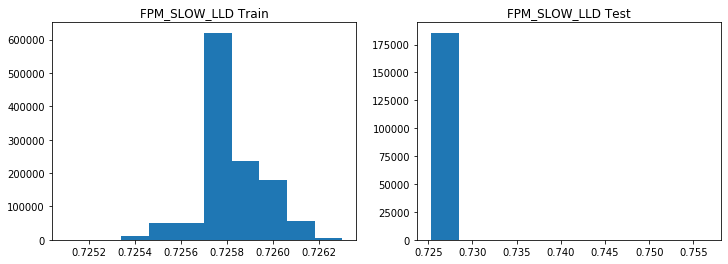

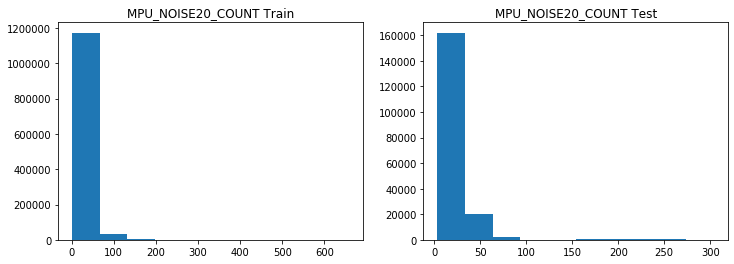

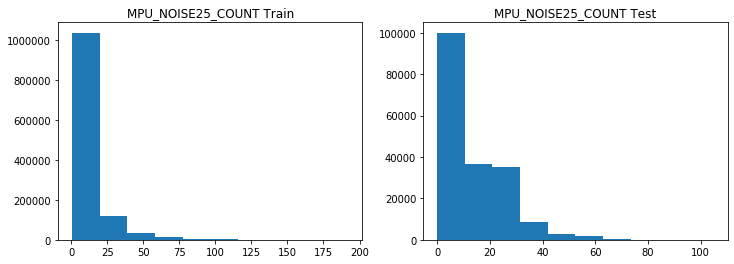

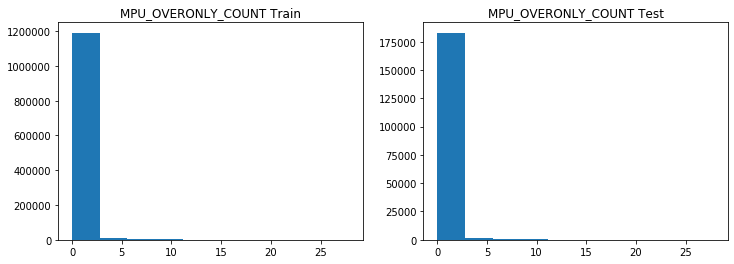

In [5]:
from config import *
from sklearn.model_selection import train_test_split
seed = 42

""" 2.1. Randomly Select Train, Val, Test time-series backgrounds"""
list_bgds = df_metadata['bID'].unique()
test_bgds = [bgd for bgd in list_bgds if 'b5' in bgd]
val_bgds = [bgd for bgd in list_bgds if 'b4' in bgd]
train_bgds = [bgd for bgd in list_bgds if bgd not in test_bgds+val_bgds]

print(f'Total backgrounds = {len(list_bgds)}')
print(f'\t Val backgrounds: {val_bgds}')
print(f'\t Test backgrounds: {test_bgds}')
print(f'%Train = {len(train_bgds) / len(list_bgds)}')
print(f'%Train = {len(val_bgds) / len(list_bgds)}')
print(f'%Test = {len(test_bgds) / len(list_bgds)}')

""" 2.2. Split Train, Val, Test {X, y}"""

# 1
if 'X_train' not in globals():
    X_train = X[df_metadata['bID'].isin(train_bgds)]
    X_val = X[df_metadata['bID'].isin(val_bgds)]
    X_test = X[df_metadata['bID'].isin(test_bgds)]
    del X
    y_train = y[df_metadata['bID'].isin(train_bgds)]
    y_val = y[df_metadata['bID'].isin(val_bgds)]
    y_test = y[df_metadata['bID'].isin(test_bgds)]
    del y
    train_metadata = df_metadata.loc[X_train.index]
    val_metadata = df_metadata.loc[X_val.index]
    test_metadata = df_metadata.loc[X_test.index]

""" 3.1. Investigate Data Quantity"""
print(f'# Training samples = {len(X_train)}.')
print(f'# Training samples = {len(X_val)}.')
print(f'# Testing samples = {len(X_test)}.')
print(X_train.columns)
print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')

""" 3.2. Investigate Data Distribution"""
for fname in input_features:
    fig, ax = plt.subplots(ncols=2, figsize=(12,4))
    ax[0].set_title(fname + ' Train')
    ax[0].hist(X_train[fname])
    ax[1].set_title(fname + ' Test')
    ax[1].hist(X_test[fname])
    plt.show()

## 5. Preprocessing: Standardization
----
1. Compute $\mu$ and $\sigma$ of EACH feature in the training set.
2. Standardization: $x = (x-\mu) / \sigma$
3. Save $\mu$ and $\sigma$ for each feature in a `npz` file for reuse.

In [7]:
# from tqdm.notebook import tqdm

# """ ################################################################
#     Store features' mean and std in a dictionary
#     format:
#         <feature_name> -> (mu, sigma)
# ################################################################"""
# feature_mu_sigma = {}
# for i, fname in tqdm(enumerate(input_features)):
#     print(f'{i+1}. Computing mean & std of {fname} ...')
#     mu, sigma = X_train[fname].mean(), X_train[fname].std()
#     feature_mu_sigma[fname] = (mu, sigma)
    
# """ Save mu and sigma of each feature in an npy file"""
# with open('feature_mu_sigma.pkl', 'wb') as f:
#     pkl.dump(feature_mu_sigma, f)
# # print(feature_mu_sigma)

In [6]:
"""################################################################
        Execute Standardization Process
################################################################"""
""" 1. Load features' mean and std (computed using X_train)"""
with open('feature_mu_sigma.pkl', 'rb') as f:
    feature_mu_sigma = pkl.load(f)

""" 2. Create a new dataset for preprocessed X"""
X_train_processed = X_train.copy()
X_val_processed = X_val.copy()
X_test_processed = X_test.copy()

""" 3. Standardization"""
for fname in tqdm(input_features):
    mu, sigma = feature_mu_sigma[fname]
    X_train_processed[fname] = (X_train[fname] - mu) / (sigma + 1e-3)
    X_val_processed[fname] = (X_val[fname] - mu) / (sigma + 1e-3)
    X_test_processed[fname] = (X_test[fname] - mu) / (sigma + 1e-3)
    
display(X_train_processed[:5])
display(X_val_processed[:5])
display(X_test_processed[:5])

""" 4. Save dataframe for reuse"""
# os.system('mkdir -p dataset_processed')
# X_train_processed.to_csv('./dataset_processed/X_train_processed.csv', index=False)
# X_val_processed.to_csv('./dataset_processed/X_val_processed.csv', index=False)
# X_test_processed.to_csv('./dataset_processed/X_test_processed.csv', index=False)
# y_train.to_csv('./dataset_processed/y_train.csv', index=False)
# y_val.to_csv('./dataset_processed/y_val.csv', index=False)
# y_test.to_csv('./dataset_processed/y_test.csv', index=False)

ROLL   SAT_LAT   SAT_LON   SAT_ALT       ELV  BR_EARTH  SUNSHINE  \
1280  0.817364 -0.804571 -1.132263 -1.021830 -1.051379  1.508757 -1.526955   
1282  0.818491 -0.807995 -1.131550 -1.021667 -1.046265  1.508757 -1.526955   
1284  0.819609 -0.811385 -1.130827 -1.021505 -1.041423  1.508757 -1.526955   
1286  0.820638 -0.814809 -1.130114 -1.021343 -1.036357  1.508757 -1.526955   
1288  0.821739 -0.818200 -1.129391 -1.021173 -1.031507  1.508757 -1.526955   

      TIME_SINCE_SUNSET  SUN_ANGLE  BETA_ANGLE  ...   COR_NYM  ANG_DIST_X  \
1280           1.350729  -0.812806    1.197994  ...  1.617296    3.512044   
1282           1.353846  -0.812766    1.197994  ...  1.612356    4.845749   
1284           1.356962  -0.812779    1.197991  ...  1.607372    2.692809   
1286           1.360079  -0.812733    1.197991  ...  1.602324    3.097696   
1288           1.363196  -0.812773    1.197991  ...  1.597234    2.612046   

      ANG_DIST_Y  FPM_TRUMP_SEL_1500_1800  FPM_RATIO_REJ_300_1800  \
1280   -0.980646                -0.051587               -0.389337   
1282   -0.269386                -0.051587               -0.389337   
1284   -0.828791                -0.051587               -0.389337   
1286   -0.218121                -0.051587               -0.389337   
1288   -0.792165                -0.051587               -0.389337   

      FPM_SLOW_LLD  MPU_NOISE20_COUNT  MPU_NOISE25_COUNT  MPU_OVERONLY_COUNT  \
1280     -0.953681          -0.435809          -0.482814           -0.347924   
1282     -0.947627          -0.437739          -0.484127           -0.313871   
1284     -0.953681          -0.430018          -0.477541           -0.279817   
1286     -0.953681          -0.419395          -0.459101           -0.296892   
1288     -0.941573          -0.429051          -0.474907           -0.313871   

      MPU_UNDERONLY_COUNT  
1280            -0.786423  
1282            -0.785675  
1284            -0.785675  
1286            -0.787171  
1288            -0.787546  

[5 rows x 46 columns]

ROLL   SAT_LAT   SAT_LON   SAT_ALT       ELV  BR_EARTH  SUNSHINE  \
0  0.399392  0.575574  0.346052 -1.083174  0.295233 -0.519066  0.637974   
2  0.399738  0.572889  0.347241 -1.083019  0.304107 -0.518269  0.637974   
4  0.400244  0.570170  0.348429 -1.082857  0.312906 -0.517496  0.637974   
6  0.400475  0.567451  0.349618 -1.082698  0.321848 -0.516657  0.637974   
8  0.401034  0.564732  0.350797 -1.082536  0.330641 -0.515857  0.637974   

   TIME_SINCE_SUNSET  SUN_ANGLE  BETA_ANGLE  ...   COR_NYM  ANG_DIST_X  \
0          -0.559774  -0.195667    1.950621  ... -0.419781    2.719662   
2          -0.559774  -0.195592    1.950623  ... -0.416366    2.255574   
4          -0.559774  -0.195592    1.950626  ... -0.412929    2.430858   
6          -0.559774  -0.195466    1.950629  ... -0.409471    1.597368   
8          -0.559774  -0.195437    1.950629  ... -0.406012    1.416833   

   ANG_DIST_Y  FPM_TRUMP_SEL_1500_1800  FPM_RATIO_REJ_300_1800  FPM_SLOW_LLD  \
0   -4.910527                -0.051587               -0.389337     -0.947627   
2   -3.990523                -0.051587               -0.389337     -0.947627   
4   -3.684429                -0.051587               -0.389337     -0.947627   
6   -2.315354                -0.051587                0.949597     -0.947627   
8   -1.980736                -0.051587               -0.389337     -0.947627   

   MPU_NOISE20_COUNT  MPU_NOISE25_COUNT  MPU_OVERONLY_COUNT  \
0          -0.403948          -0.443301           -0.177657   
2          -0.411674          -0.449881           -0.228689   
4          -0.417464          -0.457788           -0.092475   
6          -0.428083          -0.474907           -0.177657   
8          -0.420362          -0.463054           -0.177657   

   MPU_UNDERONLY_COUNT  
0            -0.732552  
2            -0.733300  
4            -0.732926  
6            -0.733486  
8            -0.732364  

[5 rows x 46 columns]

ROLL   SAT_LAT   SAT_LON   SAT_ALT       ELV  BR_EARTH  SUNSHINE  \
29466  0.214664 -0.303436  1.534321 -1.051414  1.068749  1.508757 -1.526955   
29468  0.214283 -0.306826  1.535064 -1.051229  1.077305  1.508757 -1.526955   
29470  0.213883 -0.310183  1.535806 -1.051048  1.085509  1.508757 -1.526955   
29472  0.213768 -0.313539  1.536549 -1.050875  1.094140  1.508757 -1.526955   
29474  0.213395 -0.316930  1.537302 -1.050694  1.102080  1.508757 -1.526955   

       TIME_SINCE_SUNSET  SUN_ANGLE  BETA_ANGLE  ...   COR_NYM  ANG_DIST_X  \
29466           0.781942   1.765994    0.899243  ...  1.381293   -2.259673   
29468           0.785058   1.765961    0.899240  ...  1.382968   -1.195996   
29470           0.788175   1.765964    0.899240  ...  1.384579   -1.358311   
29472           0.791291   1.766001    0.899240  ...  1.386190   -0.807955   
29474           0.794408   1.765899    0.899240  ...  1.386727   -0.482906   

       ANG_DIST_Y  FPM_TRUMP_SEL_1500_1800  FPM_RATIO_REJ_300_1800  \
29466   -4.452841                -0.051587               -0.389337   
29468   -2.923297                -0.051587               -0.389337   
29470   -3.217616                -0.051587               -0.389337   
29472   -1.067566                -0.051587               -0.389337   
29474   -3.081187                -0.051587               -0.389337   

       FPM_SLOW_LLD  MPU_NOISE20_COUNT  MPU_NOISE25_COUNT  MPU_OVERONLY_COUNT  \
29466     -0.947627          -0.447395          -0.495981           -0.262743   
29468     -0.941573          -0.444497          -0.493347           -0.330945   
29470     -0.941573          -0.432911          -0.478861           -0.296892   
29472     -0.947627          -0.427121          -0.469641           -0.279817   
29474     -0.947627          -0.416502          -0.457788           -0.364999   

       MPU_UNDERONLY_COUNT  
29466            -0.788107  
29468            -0.786611  
29470            -0.786797  
29472            -0.786049  
29474            -0.786423  

[5 rows x 46 columns]

' 4. Save dataframe for reuse'

## II. ML Pipeline
----
**NOTES:**
* This Problem is a **Highly Imbalanced Problem**.
    1. Most samples have low photon counts (0-2) -> we need to fairly treats high photon counts cases to **avoid biases**.
    2. Consider using **Fairness algorithm**.
    3. Consider using a **Fair Metric** -> heavily penalize incorrect predictions for high photon count cases.
        -> use IOU
   
   
* This Problem has mutiple target variables.
    1. 22-output regression: 22 X-Ray channels for the Spectra.
    2. Advantages over multiple Single-Target models:
        * More computationally efficient
        * Model dependencies between target variables

**IDEAS:**
1. Simple idea (classify first -> regress on high count spectrums later): 
    * Instead of using many K-means clusters, we use only 2 cluster to differentiate between small photon counts observations from high photon counts observations
    * then we train the main model on High Photon counts category.
    
    
2. More complex idea:
    * Using Deep Network with Gradient Descents will give more flexibility for state-of-the-art techniques.
    * Use Gradient-Conflict approach to Unsupervised-ly split the dataset into different Network branches.
    * Specifically, more similar observations share more weights, while conflicting observations have their weights split.
    * Reference: Statistically-Guided Deep Network Transformation (ICDM best paper): 
    https://ieeexplore.ieee.org/document/9679027.
    * Challenge: the dataset is very large, so the splitting can be computationally very expensive.

PLANS:
1. Test a simple baseline model without Fairness: XGBoost.
2. Test a deep baseline model without Fairness: Neural Network.
3. Test a deep temporal baseline model without Fairness: LSTM? --> see Questions.

**QUESTIONS:**
1. We are using independent prediction for each timestep. Is there a Temporal relationship?
2. Is there a Spatial relationship?
3. If we use K-means, how can we model the accurate photon counts? The variance might be too high.
4. What is minimum $dt$ to be scientifically meaningful / useful?

### 0. Training Fair Metric: still researching ...
1. Use RRMSE instead of RMSE --> Relative RRMSE
2. Add weighted RMSE for fairer evaluation
    * E.g: 10,000 samples y=1 VS 10 samples y=5000, then the weight = 1000:1 for the RRMSE.
    * Divide the Values into different Group Bins: <br>
        1. $[0, 10]$: num samples $n_1$ $\rightarrow$ weight $\beta_1 = \frac{1000}{n_1}$
        2. $[10, 100]$: num samples $n_2$ $\rightarrow$ weight $\beta_2 = \frac{100}{n_2}$
        3. $[100, 1000]$: num samples $n_3$ $\rightarrow$ weight $\beta_3 = \frac{10}{n_3}$
        4. $[1000, 10000]$: num samples $n_4$ $\rightarrow$ weight $\beta_4 = \frac{1}{n_4}$ <br>
    * Evaluation Metric: <br>
        $\sum Err = \sum \beta_i {Err}_i$

In [7]:
""" 
    Evaluation metric compatible to all target range (0 to 10^6)
    :preds - predicted 22-channel X-Ray counts
    :gts   - ground-truth 22-channel X-Ray counts
    
    return:
        IOU of preds & gts -> in [0,1] range
        E.g: pred = [10, 5, 2, 0, 0]
             gt   = [10, 0, 0, 0, 0]
         -> I = [10, 0, 0, 0, 0]
            U = [10, 5, 2, 0, 0]
         -> IOU = Sum(I) / Sum(U) = 10 / 17 
                = 0.58
"""
def spectra_IOU(preds, gts):
    """ 
        1. Create `Intersection` X-Ray & `Union` X-Ray 
        with shape (N x C x 2)
    """
    I = np.zeros((preds.shape[0], preds.shape[1], 2))
    U = np.zeros((preds.shape[0], preds.shape[1], 2))
    
    """ 2. Fill I[0] = preds; I[1] = gts"""
    # Add 1 to avoid division by 0 in case all counts = 0
    I[:,:,0] = preds
    I[:,:,1] = gts
    U[:,:,0] = preds
    U[:,:,1] = gts
    
    """ 3. Compute Intersected X-Ray counts & Union X-Ray counts"""
    I = np.min(I, axis=2)
    U = np.max(U, axis=2)
    # print(I, U)
    
    """ 4. Compute IOU for all observations"""
    # a. Total Intersecting photon counts
    I_count = I.sum(axis=1) + 1
    # b. Total Union photon counts
    U_count = U.sum(axis=1) + 1
    # c. Suppress all Intersection & Union photon counts to be >= 1
    IOU = I_count / U_count
    # print(IOU.shape)
    
    return IOU
    
IOU = spectra_IOU(y_test, y_test)
print(IOU.mean())
print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')

1.0
RAM Used: 28.41 Gb


### Loss function

In [8]:
import torch
import torch.nn as nn
from torch.nn import PoissonNLLLoss

""" loss.py """

""" 
    Mean Squared Log Error
    -> more unbiased optimization for different target scales (0 to 10^5)
    
    :gamma: weight, if necessary for Multitask learning
"""
class MSLELoss(nn.Module):
    def __init__(self, gamma=20):
        super().__init__()
        self.mse = nn.MSELoss()
        self.gamma = gamma
        
    def forward(self, preds, labels):
        return self.gamma * self.mse(torch.log10(preds + 1), torch.log10(labels + 1))

""" 
    Root Mean Squared Error
"""
class RMSELoss(nn.Module):
    def __init__(self, gamma=20):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self, preds, labels):
        return torch.sqrt(self.mse(preds, labels))
"""
    Focal loss
    -> resolve imbalance class problem
    
    :alpha: scale of the loss
    :gamma: higher values indicate higher attention to "hard" samples
"""
class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, logits=False, reduce=True):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.logits = logits
        self.reduce = reduce
        
    def forward(self, inputs, targets):
        BCE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1-pt)**self.gamma * BCE_loss
        # print(BCE_loss)
        # print(F_loss)
        
        if self.reduce:
            return torch.mean(F_loss)
        else:
            return F_loss
        
""" 
    KL Divergence loss between predicted & ground-truth spectra
    
    KL_loss = Sum {all i} KL(p{i}, phat{i})
        where:
            + KL(p{i}, phat{i}) = p{i} log(p{i} / phat{i})
            + p{i} = y{i} / Sum (y{j})
            + phat{i} = yhat{i} / Sum (yhat{j})
"""
class KL_Loss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, preds, gts):
        """ 1. Normalize predicted spectra to make each spectrum 
               become probability distribution (sum = 1)"""
        total_cts = (preds.sum(axis=1)).view(-1,1)
        preds_norm = torch.div((preds), total_cts+1e-6)
        # print(preds_norm.sum(axis=1)) -> assert probability sum to 1.0
        """ 2. Normalize ground-truth spectra to make each spectrum 
               become probability distribution (sum = 1)"""
        total_cts = (gts.sum(axis=1)).view(-1,1)
        gts_norm = torch.div((gts), total_cts+1e-6)
        # print(gts_norm.sum(axis=1)) -> assert probability sum to 1.0
        """ 3. Compute KL divergence between each predicted & ground-truth spectrum"""
        # Sum p(x) * log(p(x) / q(x))
        KLs = gts_norm * torch.log((gts_norm+1e-6) / (preds_norm+1e-6))
        KLs = KLs.mean()
        """ 4. Compute KL divergence loss"""
        KL_loss = KLs.mean(axis=0)

        return KL_loss

""" 
    Function to compute Accuracy
"""
def accuracy(preds, targets):
    acc = (preds == targets).sum() / len(preds)
    acc = round(float(acc), 4)
    return acc

### 1. Benchmark ML model: XGBoost Regressor
* Next Steps: 
    1. find a Fair Metrics for Extreme Imbalance Dataset
    2. improve Multi-Target Regression

In [19]:
# # !ls
# # !ls ~/.local/lib/python3.9/site-packages
# # !pwd
# %cd /home/anhu/Deep_XRay_Spectral_Predictions

In [20]:
# %load_ext autoreload
# %autoreload 2

# import os
# import xgboost as xgb
# from config import *

# seed = 42

# os.system('mkdir -p checkpoints')

# """ 1. Model initialization"""
# hyperparams = {'max_depth': 6, 'learning_rate': 1e-3, 'n_estimators': 400, 
#                'subsample': 0.75, 'objective': 'reg:squaredlogerror', 
#                'nthread': 32, 'early_stopping_rounds': 10, 'seed': seed}
# model = xgb.XGBRegressor(**hyperparams)

# """ 2. Model training"""
# print('Full mode: use full Training data:')
# model.fit(X_train_processed, y_train, 
#           eval_set=[(X_train_processed, y_train)],
#           verbose=True)

# """ 3. Save trained model"""
# with open('XGBoost.pkl', 'wb') as f:
#     pkl.dump(model, f)
# # X_train_processed

In [21]:
# %load_ext autoreload
# %autoreload 2

# import os
# import lightgbm as lgb
# from config import *

# seed = 42

# os.system('mkdir -p checkpoints')

# """ 1. Model initialization"""
# hyperparams = {'max_depth': 6, 'learning_rate': 1e-3, 'n_estimators': 400, 
#                'subsample': 0.75, 'objective': 'reg:squaredlogerror', 
#                'nthread': 32, 'early_stopping_rounds': 10, 'seed': seed}
# model = lgb.LGBMRegressor(**hyperparams)

# """ 2. Model training"""
# print('Full mode: use full Training data:')
# model.fit(X_train_processed, y_train, 
#           eval_set=[(X_train_processed, y_train)],
#           verbose=True)

# """ 3. Save trained model"""
# with open('LightGBM.pkl', 'wb') as f:
#     pkl.dump(model, f)
# # X_train_processed

In [22]:
# with open('XGBoost.pkl', 'rb') as f:
#     model = pkl.load(f)
    
# preds = model.predict(X_test_processed)
# err = rmse(preds, y_test)

# X_train_processed
# y_train

In [23]:
# with open('XGBoost.pkl', 'rb') as f:
#     model = pkl.load(f)
    
# """ Evaluation on a sample test data with high photon counts"""
# obsids = y_test[y_test['1000'] >= 1000].index
# smpl_X_test = X_test_processed.loc[obsids, :]
# smpl_X_test = smpl_X_test.iloc[:1]
# smpl_y_test = y_test.loc[obsids]
# smpl_y_test = smpl_y_test.iloc[:1]
# preds = model.predict(smpl_X_test)
# preds = np.round(preds)

# """ Ground Truth Spectrum Visualization"""
# # display(smpl_y_test)
# print(smpl_y_test.columns)
# ax = smpl_y_test.iloc[0].plot(kind='bar', 
#                               title=f'Ground Truth Spectrum', 
#                               figsize=(8,4))
# ax.set_xlabel('X-Ray Spectral Bin')
# ax.set_ylabel('Photon Counts')
# # ax.set_ylim([0, 9000])
# ax.grid(axis='y')
# plt.show()

# """ Predicted Spectrum Visualization"""
# # display(preds)
# df_preds = pd.DataFrame(preds.reshape(1,-1), columns=y.columns)
# ax = df_preds.iloc[0].plot(kind='bar', 
#                            title=f'Predicted Spectrum', 
#                            figsize=(8,4))
# ax.set_xlabel('X-Ray Spectral Bin')
# ax.set_ylabel('Photon Counts')
# # ax.set_ylim([0, 9000])
# ax.grid(axis='y')
# plt.show()
# # print(np.round(preds))
# # print(np.array(smpl_y_test))

### 2. Benchmark Deep Model: Simple Neural Nework
* Decriptions:
    1. Vanilla Neural Network: 128-128-128-128
    2. Adam Optimizer + config lr + plateau decays
    3. MSE loss
* Next Steps: 
    1. Deep Imbalanced Regression (ICML Long Oral Paper - top 2%): https://arxiv.org/pdf/2102.09554.pdf
    2. Consider using MSLE (Mean Squared Loss Error) to make fairer gradients

In [15]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

""" 1. Tensor conversion"""
TensorX_train = torch.Tensor(np.array(X_train_processed)) # [scale_indexes['Train'][3]]
TensorX_val = torch.Tensor(np.array(X_val_processed)) # [scale_indexes['Train'][3]]
TensorX_test = torch.Tensor(np.array(X_test_processed))
Tensory_train = torch.Tensor(np.array(y_train)) # [scale_indexes['Train'][3]]
Tensory_val = torch.Tensor(np.array(y_val)) # [scale_indexes['Train'][3]]
Tensory_test = torch.Tensor(np.array(y_test))

# """ Reduce training size to 10% for debugging mode """
# if config.debug:
#     TensorX_train = TensorX_train[::10]|
#     Tensory_train = Tensory_train[::10]

print(f'Training data = {len(Tensory_train)} | Shape = {TensorX_train.shape}, {Tensory_train.shape}')
print(f'Validation data = {len(Tensory_val)} | Shape = {TensorX_val.shape}, {Tensory_val.shape}')
print(f'Testing data = {len(Tensory_test)} | Shape = {TensorX_test.shape}, {Tensory_test.shape}')
print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')

cuda
Training data = 1208935 | Shape = torch.Size([1208935, 46]), torch.Size([1208935, 1180])
Validation data = 123726 | Shape = torch.Size([123726, 46]), torch.Size([123726, 1180])
Testing data = 185947 | Shape = torch.Size([185947, 46]), torch.Size([185947, 1180])
RAM Used: 40.89 Gb


In [10]:
"""####################################
    Groups of related variables
####################################"""
group_vars = {}
group_vars['iss_vars'] = ['ROLL', 'SAT_LAT', 'SAT_LON', 'SAT_ALT', 'RAM_ANGLE', 'EAST_ANGLE', 
                          'ATT_ANG_AZ', 'ATT_ANG_EL', 'XTI_PNT_JITTER', 
                          'ANG_DIST', 'ANG_DIST_X', 'ANG_DIST_Y']
group_vars['sun_vars'] = ['SUNSHINE', 'TIME_SINCE_SUNSET', 'SUN_ANGLE', 
                          'BETA_ANGLE', 'LOCAL_TIME', 'MOON_ANGLE']
group_vars['geomag_vars'] = ['SAA', 'SAA_TIME', 'COR_ASCA', 'COR_SAX', 'MCILWAIN_L', 'MAGFIELD', 
                             'MAGFIELD_MIN', 'MAG_ANGLE', 'AP8MIN', 'AE8MIN',  'KP', 
                             'SOLAR_PHI', 'COR_NYM', 'ELV', 'BR_EARTH']
group_vars['detector_vars_1'] = ['FPM_RATIO_REJ_COUNT',  'FPM_FT_COUNT', 'FPM_NOISE25_COUNT', 
                               'FPM_TRUMP_SEL_1500_1800', 'FPM_RATIO_REJ_300_1800', 'FPM_SLOW_LLD', 
                               'MPU_NOISE20_COUNT', 'MPU_NOISE25_COUNT']
group_vars['detector_vars_2'] = ['FPM_OVERONLY_COUNT', 'FPM_UNDERONLY_COUNT', 'FPM_DOUBLE_COUNT', 
                                 'MPU_OVERONLY_COUNT', 'MPU_UNDERONLY_COUNT']

# group_vars['iss_vars'] = ['ROLL', 'SAT_LAT', 'SAT_LON', 'SAT_ALT', 'RAM_ANGLE',
#                           'ATT_ANG_AZ', 'ATT_ANG_EL', 'XTI_PNT_JITTER',
#                           'ANG_DIST', 'ANG_DIST_X', 'ANG_DIST_Y']
# # cite: https://dmrowan.github.io/assets/Rowan_Thesis.pdf
# group_vars['solar_vars'] = ['SUN_ANGLE', 'BETA_ANGLE', 'SUNSHINE', 'TIME_SINCE_SUNSET', 
#                             'ELV', 'BR_EARTH', 'MOON_ANGLE', 'LOCAL_TIME']
# # cite: https://heasarc.gsfc.nasa.gov/docs/nicer/analysis_threads/scorpeon-overview/
# group_vars['saa_vars'] = ['SAA', 'SAA_TIME']
# group_vars['cosmic_ray_vars'] = ['COR_SAX', 'COR_ASCA', 'COR_NYM', 'MCILWAIN_L',
#                                  'MAGFIELD', 'MAGFIELD_MIN', 'MAG_ANGLE', 'EAST_ANGLE',
#                                  'AP8MIN', 'AE8MIN', 'KP', 'COR_NYM', 'SOLAR_PHI', ]
# group_vars['detector_vars_1'] = ['FPM_RATIO_REJ_COUNT',  'FPM_FT_COUNT', 'FPM_NOISE25_COUNT', 
#                                  'FPM_SLOW_LLD', 'MPU_NOISE20_COUNT', 'MPU_NOISE25_COUNT']
# group_vars['detector_vars_2'] = ['FPM_OVERONLY_COUNT', 'FPM_UNDERONLY_COUNT', 'FPM_DOUBLE_COUNT', 
#                                  'MPU_OVERONLY_COUNT', 'MPU_UNDERONLY_COUNT']
# group_vars['3c50'] = ['FPM_TRUMP_SEL_1500_1800', 'FPM_RATIO_REJ_300_1800']

"""####################################
    list of iloc (column id) of 
    variables in each group
####################################"""
group_col_id = {}
for group in group_vars:
    list_vars = group_vars[group]
    group_col_id[group] = [X_train.columns.get_loc(col) for col in list_vars]
    print(group, group_col_id[group])

"""------------------------------------
    Assertion
------------------------------------"""
# print(len(set(group_vars['iss_vars'] + group_vars['sun_vars'] + group_vars['geomag_vars'] + 
#               group_vars['detector_vars_1'] + group_vars['detector_vars_2'])))

display(X_train_processed[group_vars['iss_vars']])

iss_vars [0, 1, 2, 3, 12, 13, 25, 26, 33, 14, 37, 38]
sun_vars [6, 7, 8, 9, 10, 11]
geomag_vars [15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 34, 35, 36, 4, 5]
detector_vars_1 [27, 31, 32, 39, 40, 41, 42, 43]
detector_vars_2 [28, 29, 30, 44, 45]


ROLL   SAT_LAT   SAT_LON   SAT_ALT  RAM_ANGLE  EAST_ANGLE  \
1280     0.817364 -0.804571 -1.132263 -1.021830  -0.931265    2.243148   
1282     0.818491 -0.807995 -1.131550 -1.021667  -0.928890    2.245187   
1284     0.819609 -0.811385 -1.130827 -1.021505  -0.926851    2.247111   
1286     0.820638 -0.814809 -1.130114 -1.021343  -0.924561    2.249135   
1288     0.821739 -0.818200 -1.129391 -1.021173  -0.922362    2.251068   
...           ...       ...       ...       ...        ...         ...   
3033728  0.743796  0.416127 -0.374821 -0.998794  -1.680953   -0.265697   
3033730  0.744097  0.422001 -0.372731 -0.998953  -1.672479   -0.262033   
3033732  0.744284  0.424921 -0.371681 -0.999030  -1.668422   -0.260368   
3033734  0.744577  0.427875 -0.370631 -0.999108  -1.664268   -0.258640   
3033736  0.745127  0.436637 -0.367472 -0.999344  -1.651588   -0.253133   

         ATT_ANG_AZ  ATT_ANG_EL  XTI_PNT_JITTER  ANG_DIST  ANG_DIST_X  \
1280      -0.005610   -1.156909        3.114499  2.417950    3.512044   
1282      -0.005266   -1.152319        3.873810  3.566288    4.845749   
1284      -0.004741   -1.147942        1.978420  1.652391    2.692809   
1286      -0.003951   -1.142117        1.451196  1.971374    3.097696   
1288      -0.003162   -1.137747        1.059431  1.588595    2.612046   
...             ...         ...             ...       ...         ...   
3033728   -0.606756    0.267056        0.812046 -0.835674   -0.311548   
3033730   -0.605964    0.288467       -0.729648  0.216969   -0.616380   
3033732   -0.605700    0.299883       -0.692789 -0.803776   -0.219795   
3033734   -0.605436    0.307021       -0.640495 -0.165810   -0.276170   
3033736   -0.604381    0.329867       -0.680698 -0.739979    0.171315   

         ANG_DIST_Y  
1280      -0.980646  
1282      -0.269386  
1284      -0.828791  
1286      -0.218121  
1288      -0.792165  
...             ...  
3033728   -0.195826  
3033730    1.294320  
3033732   -0.451648  
3033734   -1.295034  
3033736    0.028276  

[1208935 rows x 12 columns]

In [11]:
input_dim = len(X_train.columns)
output_dim = len(y_train.columns)
hidden_dim = 128

""" Linear Regression"""
# dnn = Linear(input_dim, output_dim).to(device)
""" MLP """
# dnn = DNN4(input_dim, output_dim).to(device)
# dnn = FR_DNN(input_dim, hidden_dim, output_dim).to(device)
""" ResNet"""
# dnn = ResNet4(input_dim, output_dim).to(device)
dnn = FR_ResNet(input_dim, hidden_dim, output_dim).to(device)
""" BERTGround (x4 TransformerEncoder) / MLP predictor"""
# dnn = NumericContextualTransformer_MLP(input_dim, output_dim, group_col_id, 
#                                  token_size=32, nhead=8, 
#                                  n_transformers=4, embed_dim=16).to(device)
""" BERTGround (x4 TransformerEncoder)"""
# dnn = NumericContextualTransformer(input_dim, output_dim, group_col_id, 
#                                    token_size=32, nhead=8, 
#                                    n_transformers=4, embed_dim=16).to(device)
""" BERTGround (x6 TransformerEncoder)"""
# dnn = NumericContextualTransformer(input_dim, output_dim, group_col_id, 
#                                    token_size=32, nhead=8, 
#                                    n_transformers=4, embed_dim=16).to(device)

""" BERTGround (x4 TransformerEncoder) - testing diff token_size
        * smaller: maybe less overfit? because ResNet already perform very well
        * larger : better contextualization?
        
        experiment 1: nhead: 8 -> 8; token_size: 32 -> 16; embed_dim: 16 -> 4 
                      (token_size per head = R^2)
        experiment 2: nhead: 8 -> 16; token_size: 32 -> 64; embed_dim: 16 -> 8 
                      (token_size per head = R^4)
"""
# dnn = NumericContextualTransformer(input_dim, output_dim, group_col_id, 
#                                    token_size=32, nhead=8, 
#                                    n_transformers=4, embed_dim=16).to(device)
# dnn = Poisson_BERTground(input_dim, output_dim, group_col_id, 
#                          token_size=32, nhead=8, 
#                          n_transformers=4, embed_dim=16).to(device)
# dnn = FR_BERTground(input_dim, output_dim, 
#                     group_col_id, 
#                     token_size=32, nhead=8, 
#                     n_transformers=4, embed_dim=16).to(device)

""" NicerNAM - Neural Additive Model
        * Physically motivated: 
            the background consists of different background components
            caused by different variables
"""
# dnn = NicerNAM(input_dim, output_dim, group_col_id)

dnn = dnn.to(device)
dnn.apply(init_DNN)
# dnn = torch.load(ckpt_name)
print(dnn)

""" 2. Hyperparameters"""
NUM_EPOCHS = 200
max_plateau = 40
lr = 1e-4
bs = 512
# criterion = torch.nn.MSELoss()
""" MSLE Loss for direct photon counts error"""
criterion = MSLELoss()
# criterion = RMSELoss()
criterion_aux = MSLELoss()
# criterion_aux = RMSELoss()
""" KL Loss for shape error"""
klLoss = KL_Loss()
""" Weighted loss function"""
lambda0 = 20    # overall loss
lambda1 = 0.1   # spectra loss weight
lambda2 = 0.05   # 0.01 # total counts loss weight
lambda3 = 0 # 0  # KL divergence weight (for spectra)
lambda4 = 0 # Poisson Loss

""" 3. Curriculum Learning indexes"""
""" Indexes sorted from easy to hard -> for curriculum learning"""
indexes_cl = np.concatenate([np.where(y_train.sum(axis=1) < 10)[0], 
                             np.where((y_train.sum(axis=1) >= 10) & (y_train.sum(axis=1) < 100))[0], 
                             np.where((y_train.sum(axis=1) >= 100))[0]])
indexes_random = np.array([i for i in range(len(y_train))])
print(indexes_cl[:5])
print(indexes_random[:5])
print(len(indexes_cl), len(indexes_random))

FR_ResNet(
  (customLayer): CustomLayer()
  (hidden1): Sequential(
    (0): Linear(in_features=46, out_features=128, bias=True)
  )
  (resblock1): Sequential(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (resblock2): Sequential(
    (0): Linear(in_features=174, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (resblock3): Sequential(
    (0): Linear(in_features=174, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (resblock4): Sequential(
    (0): Linear(in_features=174, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (output): Sequential(
    (0): Linear(in_features=174, out_features=1180, bias=True)
    (1): ReLU()
  )
)
[0 1 2 3 4]
[0 1 2 3 4]
1208935 1208935


In [ ]:
from random import shuffle

# ckpt_name = 'dnn_logmse_interval_2.pt'
# ckpt_name = 'dnn_logmse_interval_3.pt'
# ckpt_name = 'dnn_logmse_bkgd.pt'
# ckpt_name = 'dnn_logmse_bkgd_v5t8.pt'
# ckpt_name = 'dnn_logmse_bkgd_nval_t5.pt'
# ckpt_name = 'dnn_0.2_10kev_bkgd_nval_t5.pt'
# ckpt_name = 'dnn_logmse_bkgd_v5t8_128neuron_bin3.pt'
# ckpt_name = 'mtl_energy_bkgd_v5t8.pt'
# ckpt_name = 'mtl_energy_bkgd_v4t1.pt'
# ckpt_name = 'mtl_energy_bkgd_v4t1.pt'
# ckpt_name = 'mtl_energy_bkgd_nval_t5.pt'
# ckpt_name = 'dnn_hard.pt'
# ckpt_name = 'dnn_full_bkgd_nval_t5.pt'

# ckpt_name = 'checkpoints/linear.pt'
# ckpt_name = 'checkpoints/dnn_full_bkgd_v4_t5_46features_v1.pt'
# ckpt_name = 'checkpoints/dnn_full_bkgd_v4_t5_46features_v2.pt'
# ckpt_name = 'checkpoints/dnn_full_bkgd_v4_t5_46features_v3.pt'
# ckpt_name = 'checkpoints/dnn_freq_reduced_v4_t5_46features_v1.pt'
# ckpt_name = 'checkpoints/resnet4_full_bkgd_v4_t5_46features.pt'
# ckpt_name = 'checkpoints/resnet4_full_bkgd_v4_t5_46features_v2.pt'
# ckpt_name = 'checkpoints/resnet4_full_bkgd_v4_t5_46features_v3.pt'
# ckpt_name = 'checkpoints/resnet4_full_bkgd_v4_t5_46features_v4.pt'
# ckpt_name = 'checkpoints/mtl2_resnet4_full_bkgd_v4_t5_46features.pt'
# ckpt_name = 'checkpoints/mtl2_resnet4_full_bkgd_v4_t5_46features_v2.pt'
# ckpt_name = 'checkpoints/resnet4_tok_full_bkgd_v4_t5_46features.pt'
# ckpt_name = 'checkpoints/mtl_resnet4_full_bkgd_v4_t5_46features.pt'
# ckpt_name = 'checkpoints/transformer_full_bkgd_v4_t5_46features.pt'
# ckpt_name = 'checkpoints/transformerx1_full_bkgd_v4_t5_46features.pt'
# ckpt_name = 'checkpoints/transformerx2_full_bkgd_v4_t5_46features.pt'
# ckpt_name = 'checkpoints/transformerx3_full_bkgd_v4_t5_46features.pt'
# ckpt_name = 'checkpoints/transformerx4_full_bkgd_v4_t5_46features.pt'
# ckpt_name = 'checkpoints/transformer_full_bkgd_v4_t5_46features_v2.pt'

# ckpt_name = 'checkpoints/bertx4_mlp_full_bkgd_v4_t5_46features.pt'

# ckpt_name = 'checkpoints/bert_full_bkgd_v4_t5_46features.pt'
# ckpt_name = 'checkpoints/bertx4_full_bkgd_v4_t5_46features.pt'
# ckpt_name = 'checkpoints/bertx4_full_bkgd_v4_t5_46features_v2.pt'
# ckpt_name = 'checkpoints/bertx4_full_bkgd_v4_t5_46features_v3.pt'
# ckpt_name = 'checkpoints/bertx4_full_bkgd_v4_t5_46features_v4.pt'
# ckpt_name = 'checkpoints/bertx4_full_bkgd_v4_t5_46features_v5.pt'
# ckpt_name = 'checkpoints/bertx4_full_bkgd_v4_t5_46features_v6.pt'
# ckpt_name = 'checkpoints/bertx4_full_bkgd_v4_t5_46features_v7.pt'
# ckpt_name = 'checkpoints/bertx4_full_bkgd_v4_t5_46features_v8.pt'
# ckpt_name = 'checkpoints/bertx4_full_bkgd_v4_t5_46features_v9.pt'
# ckpt_name = 'checkpoints/bertx4_full_bkgd_v4_t5_46features_v10.pt'
# ckpt_name = 'checkpoints/bertx4_full_bkgd_v4_t5_46features_v11.pt'
# ckpt_name = 'checkpoints/bertx4_full_bkgd_v4_t5_46features_v12.pt'

# ckpt_name = 'checkpoints/resnet_freq_reduced_v4_t5_46features_v1.pt'
# ckpt_name = 'checkpoints/resnet_freq_reduced_v4_t5_46features_v2.pt'
# ckpt_name = 'checkpoints/resnet_freq_reduced_v4_t5_46features_v3.pt'
# ckpt_name = 'checkpoints/resnet_freq_reduced_poissonLoss_v4_t5_46features_v1.pt'
# ckpt_name = 'checkpoints/bertx4_freq_reduced_v4_t5_46features_v1.pt'
# ckpt_name = 'checkpoints/bertx4_freq_reduced_v4_t5_46features_v2.pt'
# ckpt_name = 'checkpoints/bertx4_freq_reduced_v4_t5_46features_v3.pt'



# ckpt_name = 'checkpoints/nicernam_full_bkgd_v4_t5_46features_v1.pt'


# ckpt_name = 'checkpoints/resnet4_full_bkgd_v4_t5_46features_+1e-3.pt'

# ckpt_name = 'checkpoints/bertx4_full_bkgd_v4_t5_46features_+1e-2.pt'
# ckpt_name = 'checkpoints/bertx4_full_bkgd_v4_t5_46features_+1e-3.pt'

# ckpt_name = 'checkpoints/bertx4_large_full_bkgd_v4_t5_46features.pt'

# ckpt_name = 'checkpoints/bertx4_full_bkgd_v4_t5_46features_KL.pt'

# ckpt_name = 'checkpoints/serverCrash_bertx4_full_bkgd_v4_t5_46features_v1.pt'


# ckpt_name = 'checkpoints/bertx4_nhead4_full_bkgd_v4_t5_46features_v1.pt'
# ckpt_name = 'checkpoints/bertx4_nhead4_full_bkgd_v4_t5_46features_v2.pt'
# ckpt_name = 'checkpoints/bertx4_nhead4_full_bkgd_v4_t5_46features_v3.pt'
# ckpt_name = 'checkpoints/bertx4_nhead4_full_bkgd_v4_t5_46features_v4.pt'

# ckpt_name = 'bertx6_full_bkgd_v4_t5_46features_v1.pt'
# ckpt_name = 'bertx1_full_bkgd_v4_t5_46features.pt'

print(dnn)

# """ Load pretrained weights, if it is available"""
# pretrain_dnn = torch.load('checkpoints/bertx4_full_bkgd_v4_t5_46features_v3.pt')
# dnn.load_state_dict(pretrain_dnn.state_dict())

if os.path.exists(ckpt_name):
    raise Exception(f'{ckpt_name} already exists. Consider specifying another checkpoint path.')
print(f'Checkpoint path: {ckpt_name}')

""" 3. Training loop"""
min_loss = 9999 # 0.1714
num_plateau = 0
dnn = dnn.to(device)
# lr = 1e-4
optimizer = torch.optim.Adam(dnn.parameters(), lr=lr)

print('USING STOCHASTIC INDEXES')
# print('USING CURRICULUM INDEXES')
for epoch in tqdm(range(NUM_EPOCHS)):
    epoch_train_loss = 0
    # 
    epoch_overall_loss = 0
    #
    epoch_spec_loss = 0
    #
    epoch_agg_loss = 0
    epoch_vhigh_cts_loss = 0
    epoch_high_cts_loss = 0
    epoch_mid_cts_loss = 0
    epoch_low_cts_loss = 0
    #
    epoch_shape_loss = 0
    #
    epoch_poisson_loss = 0
    
    """#########################################################
            TRAINING OPTIMIZATION
    #########################################################"""
    """ 1. Stochastic batch Training"""
    dnn.train()
    shuffle(indexes_random)
    # if (epoch+1) % 10 == 0:
    #     indexes_cl = np.flip(indexes_cl)
        
    for batch in range(0, len(TensorX_train), bs):
        optimizer.zero_grad()
        
        """ curriculum learning sampling"""
        # indexes = indexes_cl[batch:batch+bs].copy()
        indexes = indexes_random[batch:batch+bs]
        # print(indexes)
        batch_X = TensorX_train[indexes].to(device)
        batch_y = Tensory_train[indexes].to(device)
        preds = dnn(batch_X)
        # print(preds.shape, batch_X.shape, batch_y.shape)
        
        """ Overall loss across all energy bins & intensity level (unweighted) """
        overall_loss = lambda0 * criterion(preds, batch_y)
        
        """ Photon count error by Energy bins """
        # softEnergy_loss = criterion(preds[:, :81], batch_y[:, :81])
        # lowMidEnergy_loss = criterion(preds[:, 81:230], batch_y[:, 81:230])
        # highMidEnergy_loss = criterion(preds[:, 230:730], batch_y[:, 230:730])
        # hardEnergy_loss = criterion(preds[:, 730:], batch_y[:, 730:])
        
        ebin1_loss = criterion(preds[:, :6].sum(axis=1), batch_y[:, :6].sum(axis=1))
        ebin2_loss = criterion(preds[:, 6:11].sum(axis=1), batch_y[:, 6:11].sum(axis=1))
        ebin3_loss = criterion(preds[:, 11:21].sum(axis=1), batch_y[:, 11:21].sum(axis=1))
        ebin4_loss = criterion(preds[:, 21:41].sum(axis=1), batch_y[:, 21:41].sum(axis=1))
        ebin5_loss = criterion(preds[:, 41:81].sum(axis=1), batch_y[:, 41:81].sum(axis=1))
        ebin6_loss = criterion(preds[:, 81:181].sum(axis=1), batch_y[:, 81:181].sum(axis=1))
        ebin7_loss = criterion(preds[:, 181:381].sum(axis=1), batch_y[:, 181:381].sum(axis=1))
        ebin8_loss = criterion(preds[:, 381:].sum(axis=1), batch_y[:, 381:].sum(axis=1))
        spec_loss = lambda1 * (ebin1_loss + ebin2_loss + ebin3_loss + ebin4_loss + 
                               ebin5_loss + ebin6_loss + ebin7_loss + ebin8_loss)
        
        """ Photon count error by Intensity """
        tot_cts_gt = batch_y.sum(axis=1).detach().cpu().numpy()
        vhigh_indexes = np.where(tot_cts_gt >= 1000)[0]
        vhigh_count_loss = criterion_aux(preds[vhigh_indexes].sum(axis=1), batch_y[vhigh_indexes].sum(axis=1)) if \
                            len(vhigh_indexes) > 0 else torch.Tensor([0]).to(device)
        high_indexes = np.where((tot_cts_gt >= 100) & (tot_cts_gt < 1000))[0]
        high_count_loss = criterion_aux(preds[high_indexes].sum(axis=1), batch_y[high_indexes].sum(axis=1)) if \
                            len(high_indexes) > 0 else torch.Tensor([0]).to(device)
        mid_indexes = np.where((tot_cts_gt >= 10) & (tot_cts_gt < 100))[0]
        mid_count_loss = criterion_aux(preds[mid_indexes].sum(axis=1), batch_y[mid_indexes].sum(axis=1)) if \
                            len(mid_indexes) > 0 else torch.Tensor([0]).to(device)
        low_indexes = np.where(tot_cts_gt < 10)[0]
        low_count_loss = criterion_aux(preds[low_indexes].sum(axis=1), batch_y[low_indexes].sum(axis=1)) if \
                            len(low_indexes) > 0 else torch.Tensor([0]).to(device)
        assert len(preds) == len(vhigh_indexes) + len(high_indexes) + len(mid_indexes) + len(low_indexes)

        aggregation_loss = (vhigh_count_loss + high_count_loss + mid_count_loss + low_count_loss)
        aggregation_loss = lambda2 * aggregation_loss
        
        """ Shape Loss: KL-divergence"""
        shape_loss = lambda3 * klLoss(preds, batch_y)
        
        """ Poisson Loss"""
        poisson_loss = lambda4 * PoissonNLLLoss()(preds, batch_y)
        
        """ Total Loss"""
        loss = overall_loss + spec_loss + aggregation_loss + shape_loss + poisson_loss
        loss.backward()
        optimizer.step()
        
        """ Epoch loss computation using all batches' errors"""
        epoch_train_loss += loss.detach().cpu().numpy()
        epoch_overall_loss += overall_loss.detach().cpu().numpy()
        epoch_spec_loss += spec_loss.detach().cpu().numpy()
        
        epoch_agg_loss += aggregation_loss.detach().cpu().numpy()
        epoch_vhigh_cts_loss += vhigh_count_loss.detach().cpu().numpy()
        epoch_high_cts_loss += high_count_loss.detach().cpu().numpy()
        epoch_mid_cts_loss += mid_count_loss.detach().cpu().numpy()
        epoch_low_cts_loss += low_count_loss.detach().cpu().numpy()
        
        epoch_shape_loss += shape_loss.detach().cpu().numpy()
        epoch_poisson_loss += poisson_loss.detach().cpu().numpy()
    
    epoch_train_loss = round(float(epoch_train_loss / (len(TensorX_train) // bs)), 4)
    epoch_overall_loss = round(float(epoch_overall_loss / (len(TensorX_train) // bs)), 4)
    epoch_spec_loss = round(float(epoch_spec_loss / (len(TensorX_train) // bs)), 4)
    
    epoch_agg_loss = round(float(epoch_agg_loss / (len(TensorX_train) // bs)), 4)
    epoch_vhigh_cts_loss = round(float(epoch_vhigh_cts_loss / (len(TensorX_train) // bs)), 4)
    epoch_high_cts_loss = round(float(epoch_high_cts_loss / (len(TensorX_train) // bs)), 4)
    epoch_mid_cts_loss = round(float(epoch_mid_cts_loss / (len(TensorX_train) // bs)), 4)
    epoch_low_cts_loss = round(float(epoch_low_cts_loss / (len(TensorX_train) // bs)), 4)
    
    epoch_shape_loss = round(float(epoch_shape_loss / (len(TensorX_train) // bs)), 4)
    epoch_poisson_loss = round(float(epoch_poisson_loss / (len(TensorX_train) // bs)), 4)
        
    print(f'{epoch} - Training:')
    print(f'     TotalLoss = {epoch_train_loss}; Overall Loss = {epoch_overall_loss}; Spec Loss = {epoch_spec_loss}; Agg Loss = {epoch_agg_loss}; Shape Loss (KL) = {epoch_shape_loss}')
    # print(f'     Loss by Energy: Soft = {epoch_softE_loss}; Low Mid = {epoch_lowMidE_loss}; High Mid = {epoch_highMidE_loss}; Hard = {epoch_hardE_loss}')
    print(f'     Loss by Counts: VHigh = {epoch_vhigh_cts_loss}; High = {epoch_high_cts_loss}; Mid = {epoch_mid_cts_loss}; Low = {epoch_low_cts_loss}')
    print(f'     Shape Loss (KL-Divergence) = {epoch_shape_loss}; Poisson Loss = {epoch_poisson_loss}.')

    
    
    """#########################################################
            VALIDATION LOSS
    #########################################################"""
    dnn.eval()
    
    epoch_val_loss = 0
    #
    epoch_overall_loss = 0
    #
    epoch_spec_loss = 0
    #
    epoch_agg_loss = 0
    epoch_vhigh_cts_loss = 0
    epoch_high_cts_loss = 0
    epoch_mid_cts_loss = 0
    epoch_low_cts_loss = 0
    #
    epoch_shape_loss = 0
    #
    epoch_poisson_loss = 0
    
    for batch in range(0, len(TensorX_val), bs):
        # print(indexes)
        batch_X = TensorX_val[batch:batch+bs].to(device)
        batch_y = Tensory_val[batch:batch+bs].to(device)
        preds = dnn(batch_X)
        # print(preds.shape, batch_X.shape, batch_y.shape)
        
        """ Overall loss across all energy bins & intensity level (unweighted) """
        overall_loss = lambda0 * criterion(preds, batch_y)
        
        """ Photon count error by Energy bins """
        # softEnergy_loss = criterion(preds[:, :81], batch_y[:, :81])
        # lowMidEnergy_loss = criterion(preds[:, 81:230], batch_y[:, 81:230])
        # highMidEnergy_loss = criterion(preds[:, 230:730], batch_y[:, 230:730])
        # hardEnergy_loss = criterion(preds[:, 730:], batch_y[:, 730:])
        # spec_loss = lambda1 * (softEnergy_loss + lowMidEnergy_loss + highMidEnergy_loss + hardEnergy_loss)
        
        ebin1_loss = criterion(preds[:, :6].sum(axis=1), batch_y[:, :6].sum(axis=1))
        ebin2_loss = criterion(preds[:, 6:11].sum(axis=1), batch_y[:, 6:11].sum(axis=1))
        ebin3_loss = criterion(preds[:, 11:21].sum(axis=1), batch_y[:, 11:21].sum(axis=1))
        ebin4_loss = criterion(preds[:, 21:41].sum(axis=1), batch_y[:, 21:41].sum(axis=1))
        ebin5_loss = criterion(preds[:, 41:81].sum(axis=1), batch_y[:, 41:81].sum(axis=1))
        ebin6_loss = criterion(preds[:, 81:181].sum(axis=1), batch_y[:, 81:181].sum(axis=1))
        ebin7_loss = criterion(preds[:, 181:381].sum(axis=1), batch_y[:, 181:381].sum(axis=1))
        ebin8_loss = criterion(preds[:, 381:].sum(axis=1), batch_y[:, 381:].sum(axis=1))
        spec_loss = lambda1 * (ebin1_loss + ebin2_loss + ebin3_loss + ebin4_loss + 
                               ebin5_loss + ebin6_loss + ebin7_loss + ebin8_loss)
        
        """ Photon count error by Intensity """
        tot_cts_gt = batch_y.sum(axis=1).detach().cpu().numpy()
        vhigh_indexes = np.where(tot_cts_gt >= 1000)[0]
        vhigh_count_loss = criterion_aux(preds[vhigh_indexes].sum(axis=1), batch_y[vhigh_indexes].sum(axis=1)) if \
                            len(vhigh_indexes) > 0 else torch.Tensor([0]).to(device)
        high_indexes = np.where((tot_cts_gt >= 100) & (tot_cts_gt < 1000))[0]
        high_count_loss = criterion_aux(preds[high_indexes].sum(axis=1), batch_y[high_indexes].sum(axis=1)) if \
                            len(high_indexes) > 0 else torch.Tensor([0]).to(device)
        mid_indexes = np.where((tot_cts_gt >= 10) & (tot_cts_gt < 100))[0]
        mid_count_loss = criterion_aux(preds[mid_indexes].sum(axis=1), batch_y[mid_indexes].sum(axis=1)) if \
                            len(mid_indexes) > 0 else torch.Tensor([0]).to(device)
        low_indexes = np.where(tot_cts_gt < 10)[0]
        low_count_loss = criterion_aux(preds[low_indexes].sum(axis=1), batch_y[low_indexes].sum(axis=1)) if \
                            len(low_indexes) > 0 else torch.Tensor([0]).to(device)
        assert len(preds) == len(vhigh_indexes) + len(high_indexes) + len(mid_indexes) + len(low_indexes)

        aggregation_loss = (vhigh_count_loss + high_count_loss + mid_count_loss + low_count_loss)
        aggregation_loss = lambda2 * aggregation_loss
        
        """ Shape Loss: KL-divergence"""
        shape_loss = lambda3 * klLoss(preds, batch_y)
        
        """ Poisson Loss"""
        poisson_loss = lambda4 * PoissonNLLLoss()(preds, batch_y)
        
        """ Total Loss"""
        loss = overall_loss + spec_loss + aggregation_loss + shape_loss + poisson_loss
        
        """ Epoch loss computation using all batches' errors"""
        epoch_val_loss += loss.detach().cpu().numpy()
        
        epoch_overall_loss += overall_loss.detach().cpu().numpy()
        
        epoch_spec_loss += spec_loss.detach().cpu().numpy()
        
        epoch_agg_loss += aggregation_loss.detach().cpu().numpy()
        epoch_vhigh_cts_loss += vhigh_count_loss.detach().cpu().numpy()
        epoch_high_cts_loss += high_count_loss.detach().cpu().numpy()
        epoch_mid_cts_loss += mid_count_loss.detach().cpu().numpy()
        epoch_low_cts_loss += low_count_loss.detach().cpu().numpy()
        
        epoch_shape_loss += shape_loss.detach().cpu().numpy()
        epoch_poisson_loss += poisson_loss.detach().cpu().numpy()
    
    epoch_val_loss = round(float(epoch_val_loss / (len(TensorX_val) // bs)), 4)
    epoch_overall_loss = round(float(epoch_overall_loss / (len(TensorX_val) // bs)), 4)
    epoch_spec_loss = round(float(epoch_spec_loss / (len(TensorX_val) // bs)), 4)
    
    epoch_agg_loss = round(float(epoch_agg_loss / (len(TensorX_val) // bs)), 4)
    epoch_vhigh_cts_loss = round(float(epoch_vhigh_cts_loss / (len(TensorX_val) // bs)), 4)
    epoch_high_cts_loss = round(float(epoch_high_cts_loss / (len(TensorX_val) // bs)), 4)
    epoch_mid_cts_loss = round(float(epoch_mid_cts_loss / (len(TensorX_val) // bs)), 4)
    epoch_low_cts_loss = round(float(epoch_low_cts_loss / (len(TensorX_val) // bs)), 4)
    
    epoch_shape_loss = round(float(epoch_shape_loss / (len(TensorX_val) // bs)), 4)
    epoch_poisson_loss = round(float(epoch_poisson_loss / (len(TensorX_val) // bs)), 4)
    
    print(f'{epoch} - Validation:')
    print(f'     TotalLoss = {epoch_val_loss}; Overall Loss = {epoch_overall_loss}; Spec Loss = {epoch_spec_loss}; Agg Loss = {epoch_agg_loss}; Shape Loss (KL) = {epoch_shape_loss}')
    # print(f'     Loss by Energy: Soft = {epoch_softE_loss}; Low Mid = {epoch_lowMidE_loss}; High Mid = {epoch_highMidE_loss}; Hard = {epoch_hardE_loss}')
    print(f'     Loss by Counts: VHigh = {epoch_vhigh_cts_loss}; High = {epoch_high_cts_loss}; Mid = {epoch_mid_cts_loss}; Low = {epoch_low_cts_loss}')
    print(f'     Shape Loss (KL-Divergence) = {epoch_shape_loss}; Poisson Loss = {epoch_poisson_loss}.')
    
    """ 3. Monitor loss trajectory"""
    if min_loss > epoch_val_loss:
        num_plateau = 0
        min_loss = epoch_val_loss
        torch.save(dnn, ckpt_name)
        print('\t checkpoint.')
    else:
        num_plateau += 1
        
    """ 4. Decay learning rate"""
    # if (epoch+1) % 100 == 0:
    if (num_plateau+1)%max_plateau == 0:
        lr = lr / 10
        for g in optimizer.param_groups:
            g['lr'] = lr
        print(f'Learning rate updated to {lr}.')
        
    """ 5. Early stopping"""
    if (num_plateau+1) >= 2*max_plateau:
        print('Early stopping.')
        break
    print('-'*100)

## IV. Evaluations

In [52]:
from helpers_prediction import bin_photon_counts, predict_lightcurve, predict_normalized_spectra, smooth
from helpers_prediction import plotSpecs_freq_domain, plotSpecs_time_domain
from eval_metrics import spectra_rmse, spectra_harnessRatio_rmse, ns3_score
from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score

In [12]:
""" Estimated background from SCORPEON model"""
# del scorp_specs
try:
    scorp_specs
except:
    scorp_specs = pd.read_csv('/group/wanglei/data/QG_outputs/spec_bgd_5_sc.csv')
    # Set appropriate index for GTI matching
    scorp_specs.set_index('Unnamed: 0', inplace=True)
    # Extract energy bins 0.2 - 12 keV only
    scorp_specs = scorp_specs[spec_list]
    # Rename index column and sort
    scorp_specs.index.names = [None]
    scorp_specs.sort_index(inplace=True)
    # Normalize the photon counts by 1e9 (for SCORPEON outputs)
    scorp_specs = scorp_specs / 1e9
    # Adjust index due to errors while running numerical model
    # scorp_specs.index = scorp_specs.index+1
    
display(scorp_specs)
print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')

20         21        22        23        24        25  \
29465     0.040510   0.056799  0.075952  0.097084  0.118858  0.139733   
29466     0.037216   0.010535  0.003971  0.002879  0.003051  0.003445   
29467     0.036838   0.010428  0.003945  0.002873  0.003050  0.003444   
29468     0.037200   0.010531  0.003970  0.002878  0.003050  0.003444   
29469     0.037132   0.010512  0.003965  0.002877  0.003050  0.003444   
...            ...        ...       ...       ...       ...       ...   
3036017  13.603979   7.669355  4.030811  1.975499  0.903478  0.386351   
3036018  18.677780  10.832927  5.872637  2.976148  1.410556  0.625937   
3036019  13.278701   7.502732  3.952357  1.941678  0.890208  0.381656   
3036020  12.451139   6.866459  3.524814  1.684823  0.750537  0.312401   
3036021  10.454516   5.710394  2.900524  1.370583  0.603173  0.248047   

               26        27        28        29  ...      1190      1191  \
29465    0.158358  0.173939  0.186404  0.196246  ...  0.000961  0.000960   
29466    0.003819  0.004127  0.004352  0.004501  ...  0.000179  0.000179   
29467    0.003819  0.004126  0.004352  0.004501  ...  0.000179  0.000179   
29468    0.003819  0.004126  0.004352  0.004501  ...  0.000179  0.000179   
29469    0.003818  0.004126  0.004351  0.004500  ...  0.000179  0.000179   
...           ...       ...       ...       ...  ...       ...       ...   
3036017  0.155392  0.059822  0.023174  0.010154  ...  0.000138  0.000138   
3036018  0.260902  0.103109  0.039701  0.016007  ...  0.000134  0.000134   
3036019  0.153918  0.059425  0.023089  0.010143  ...  0.000138  0.000138   
3036020  0.122453  0.046281  0.018028  0.008342  ...  0.000138  0.000137   
3036021  0.096293  0.036386  0.014547  0.007204  ...  0.000138  0.000138   

             1192      1193      1194      1195      1196      1197      1198  \
29465    0.000959  0.000959  0.000958  0.000957  0.000956  0.000955  0.000954   
29466    0.000179  0.000179  0.000179  0.000178  0.000178  0.000178  0.000177   
29467    0.000179  0.000179  0.000179  0.000178  0.000178  0.000178  0.000177   
29468    0.000179  0.000179  0.000179  0.000178  0.000178  0.000178  0.000177   
29469    0.000179  0.000179  0.000179  0.000178  0.000178  0.000178  0.000177   
...           ...       ...       ...       ...       ...       ...       ...   
3036017  0.000137  0.000137  0.000137  0.000137  0.000137  0.000136  0.000136   
3036018  0.000134  0.000134  0.000134  0.000133  0.000133  0.000133  0.000132   
3036019  0.000138  0.000137  0.000137  0.000137  0.000137  0.000136  0.000136   
3036020  0.000137  0.000137  0.000137  0.000137  0.000136  0.000136  0.000136   
3036021  0.000138  0.000137  0.000137  0.000137  0.000137  0.000136  0.000136   

             1199  
29465    0.000954  
29466    0.000177  
29467    0.000177  
29468    0.000177  
29469    0.000177  
...           ...  
3036017  0.000136  
3036018  0.000132  
3036019  0.000136  
3036020  0.000136  
3036021  0.000136  

[100574 rows x 1180 columns]

RAM Used: 29.39 Gb


In [49]:
""" Quantitative Investigate Errors for different scales"""
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# dnn = torch.load('linear.pt')
# dnn = torch.load('checkpoints/dnn_full_bkgd_v4_t5_46features_v1.pt')

# dnn = torch.load('resnet34_full_bkgd_v4_t5_46features.pt')
# dnn = torch.load('resnet4_full_bkgd_v4_t5_46features.pt')
# dnn = torch.load('checkpoints/resnet4_full_bkgd_v4_t5_46features_v2.pt')
# dnn = torch.load('checkpoints/resnet4_full_bkgd_v4_t5_46features_v4.pt')
# dnn = torch.load('checkpoints/resnet_freq_reduced_v4_t5_46features_v1.pt')
# dnn = torch.load('checkpoints/resnet_freq_reduced_v4_t5_46features_v2.pt')
dnn = torch.load('checkpoints/resnet_freq_reduced_v4_t5_46features_v3.pt')
# dnn = torch.load('checkpoints/resnet_freq_reduced_poissonLoss_v4_t5_46features_v1.pt')


# dnn = torch.load('mtl2_resnet4_full_bkgd_v4_t5_46features.pt')
# dnn = torch.load('mtl2_resnet4_full_bkgd_v4_t5_46features_v2.pt')

# dnn = torch.load('resnet4_tok_full_bkgd_v4_t5_46features.pt')
# dnn = torch.load('mtl_resnet4_full_bkgd_v4_t5_46features.pt')
# dnn = torch.load('transformer_full_bkgd_v4_t5_46features.pt')
# dnn = torch.load('transformerx2_full_bkgd_v4_t5_46features.pt')
# dnn = torch.load('transformerx3_full_bkgd_v4_t5_46features.pt')
# dnn = torch.load('transformer_full_bkgd_v4_t5_46features_v2.pt')
# dnn = torch.load('bert_full_bkgd_v4_t5_46features.pt')
# dnn = torch.load('bertx4_full_bkgd_v4_t5_46features.pt')
# dnn = torch.load('bertx4_full_bkgd_v4_t5_46features_v2.pt')

# dnn = torch.load('bertx4_mlp_full_bkgd_v4_t5_46features.pt')

# dnn = torch.load('checkpoints/bertx4_full_bkgd_v4_t5_46features_v3.pt')
# dnn = torch.load('checkpoints/bertx4_full_bkgd_v4_t5_46features_v4.pt')
# dnn = torch.load('checkpoints/bertx4_full_bkgd_v4_t5_46features_v5.pt')
# dnn = torch.load('checkpoints/bertx4_full_bkgd_v4_t5_46features_v6.pt')
# dnn = torch.load('checkpoints/bertx4_full_bkgd_v4_t5_46features_v7.pt')
# dnn = torch.load('checkpoints/bertx4_full_bkgd_v4_t5_46features_v8.pt')
# dnn = torch.load('checkpoints/bertx4_full_bkgd_v4_t5_46features_v9.pt')
# dnn = torch.load('checkpoints/bertx4_full_bkgd_v4_t5_46features_v10.pt')
# dnn = torch.load('checkpoints/bertx4_full_bkgd_v4_t5_46features_v11.pt')
# dnn = torch.load('checkpoints/bertx4_full_bkgd_v4_t5_46features_v12.pt')

# dnn = torch.load('checkpoints/bertx4_fourier_full_bkgd_v4_t5_46features_v1.pt')
# dnn = torch.load('checkpoints/bertx4_fourier_full_bkgd_v4_t5_46features_v2.pt')

# dnn = torch.load('checkpoints/bertx4_freq_reduced_v4_t5_46features_v1.pt')
# dnn = torch.load('checkpoints/bertx4_freq_reduced_v4_t5_46features_v2.pt')
# dnn = torch.load('checkpoints/bertx4_freq_reduced_v4_t5_46features_v3.pt')




# dnn = torch.load('checkpoints/nicernam_full_bkgd_v4_t5_46features_v1.pt')
# dnn = torch.load('checkpoints/nicernam_full_bkgd_v4_t5_46features_v1.pt')


# dnn = torch.load('checkpoints/resnet_lc_22bins_warmup_v2.pt')


# dnn = torch.load('checkpoints/bertx4_full_bkgd_v4_t5_46features_KL.pt')

# dnn = torch.load('checkpoints/bertx6_full_bkgd_v4_t5_46features_v1.pt')
# dnn = torch.load('checkpoints/bertx1_full_bkgd_v4_t5_46features.pt')

# dnn = torch.load('checkpoints/bertx4_nhead4_full_bkgd_v4_t5_46features_v1.pt')
# dnn = torch.load('checkpoints/bertx4_nhead4_full_bkgd_v4_t5_46features_v2.pt')
# dnn = torch.load('checkpoints/bertx4_nhead4_full_bkgd_v4_t5_46features_v3.pt')

# dnn = torch.load('checkpoints/bertx4_full_bkgd_v4_t5_46features_+1e-2.pt')
# dnn = torch.load('checkpoints/bertx4_full_bkgd_v4_t5_46features_+1e-3.pt')

dnn = dnn.to(device)
dnn.eval()
criterion = MSLELoss()

""" 1.  Run Predictions for Test set"""
preds = []
eval_bs = 128
for batch in tqdm(range(0, len(TensorX_test), eval_bs)):
    yhat = dnn(TensorX_test[batch:batch+eval_bs].to(device))
    preds.append(yhat)  
preds = torch.concat(preds, axis=0).cpu()
preds = preds.detach().cpu().numpy()

# """ 2. Compute Errors for the Whole test set"""
# err = criterion(torch.Tensor(preds), Tensory_test)
# err = err.detach().cpu().numpy()
# iou = spectra_IOU(preds, Tensory_test.detach().cpu().numpy())
# print('='*40)
# print(f'Whole testing set: {len(preds)} samples: ')
# print(f'\t MSE = {np.round(err, 4)};\n\t IOU = {np.round(iou.mean(), 4)}')

total_count_preds = preds.sum(axis=1)
total_count_targets = Tensory_test.sum(axis=1).detach().cpu().numpy()
max_count = max(total_count_targets)

"""######################################
    Scatter plot density (log scale)
######################################"""
plt.figure(figsize=(9,9))
plt.title('Total Photon Counts\n($0.2keV$ to $12keV$)', fontsize=20)
log_preds = np.log10(total_count_preds+1)
log_gts = np.log10(total_count_targets+1)

# plt.scatter(total_count_preds, total_count_targets, alpha=0.2)
plt.hist2d(log_preds, log_gts, vmin=0, vmax=5e3, bins=(40,40), cmap=plt.cm.jet)
# plt.scatter(np.log10(total_count_preds+1), np.log10(total_count_targets+1))
plt.plot([0, max_count], [0, max_count], '--', color='red')

""" Axis labeling by ticks"""
linear_ticks = [0, 1, 10, 1e2, 1e3]
log_ticks = [np.log10(n+1) for n in linear_ticks]
axis_labels = ['$0$', '$1$', '$10$', '$10^2$', '$10^3$']
plt.xticks(log_ticks, axis_labels, fontsize=12)
plt.yticks(log_ticks, axis_labels, fontsize=12)
# plt.xscale('symlog')
# plt.yscale('symlog')

plt.xlabel('Estimated Total Photon Counts\n($cts/s/10eV$)', fontsize=16)
plt.ylabel('Observed Total Photon Counts\n($cts/s/10eV$)', fontsize=16)

r2 = r2_score(total_count_targets, total_count_preds)
R2line = f'$R^2$ = {round(r2,2)}'
plt.plot([], [], ' ', label=R2line)
plt.legend(fontsize=16)

"""######################################
    Scatter plot density (linear scale)
######################################"""
plt.figure(figsize=(9,9))
plt.title('Total Photon Counts\n($0.2keV$ to $12keV$)', fontsize=20)
plt.scatter(total_count_preds, total_count_targets, alpha=0.2)
plt.plot([0, max_count], [0, max_count], '--', color='red')

plt.xlabel('Estimated Total Photon Counts\n($cts/s/10eV$)', fontsize=16)
plt.ylabel('Observed Total Photon Counts\n($cts/s/10eV$)', fontsize=16)

r2 = r2_score(total_count_targets, total_count_preds)
err = mean_squared_log_error(total_count_targets, total_count_preds)
R2line = f'$R^2$ = {round(r2,2)}'
MSLEline = f'$MSLE$ = {round(float(err),3)}'
plt.plot([], [], ' ', label=R2line)
plt.plot([], [], ' ', label=MSLEline)
plt.legend(fontsize=16)

print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')


RAM Used: 42.0 Gb


In [20]:
tot_counts = y_test.sum(axis=1)

"""##############################################
    Overall Performance
##############################################"""
print('Overall')
# a. Extract both .loc and .iloc indexes (we have both pd.dataframe & np.array)

""" Save test data for debugging"""
# X_test.loc[indexes].to_csv('/group/wanglei/data/QG_outputs/new_features_Test.csv', index=False)
# y_test.loc[indexes].to_csv('/group/wanglei/data/QG_outputs/full_spectras_Test.csv', index=False)

"""-------------------------------------------
    Scatter plot density (DNN linear scale)
-------------------------------------------"""
indexes = [i for i in y_test.index if i in scorp_specs.index]
total_count_targets = y_test.loc[indexes].sum(axis=1)
total_count_preds = scorp_specs.loc[indexes].sum(axis=1)

plt.figure(figsize=(16,16))
plt.title('Background Intensity Scatterplot\n($0.2keV$ to $12keV$)', fontsize=40)
plt.scatter(total_count_preds, total_count_targets, s=120, alpha=0.2)
plt.plot([0, max_count], [0, max_count], '--', color='red')
plt.xlabel('SCORPEON Estimated Total Photon Counts\n($cts/s$)', fontsize=32)
plt.ylabel('Observed Total Photon Counts\n($cts/s$)', fontsize=32)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
r2 = r2_score(total_count_targets, total_count_preds)
err = mean_squared_log_error(total_count_targets, total_count_preds)
R2line = f'$R^2$ = {round(r2,2)}'
MSLEline = f'$MSLE$ = {round(float(err),3)}'
plt.plot([], [], ' ', label=R2line)
plt.plot([], [], ' ', label=MSLEline)
plt.legend(fontsize=40, loc='lower right')
"""-------------------------------------------
    Scatter plot density (SCORPEON linear scale)
-------------------------------------------"""
indexes = [i for i in y_test.index if i in scorp_specs.index]
indexes_iloc = y_test.reset_index()[y_test.reset_index()['index'].isin(indexes)].index
total_count_targets = y_test.loc[indexes].sum(axis=1)
total_count_preds = preds[indexes_iloc].sum(axis=1)

plt.figure(figsize=(16,16))
plt.title('Background Intensity Scatterplot\n($0.2keV$ to $12keV$)', fontsize=40)
plt.scatter(total_count_preds, total_count_targets, s=120, alpha=0.2)
plt.plot([0, max_count], [0, max_count], '--', color='red')
plt.xlabel('BERTground Estimated Total Photon Counts\n($cts/s$)', fontsize=32)
plt.ylabel('Observed Total Photon Counts\n($cts/s$)', fontsize=32)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
r2 = r2_score(total_count_targets, total_count_preds)
err = mean_squared_log_error(total_count_targets, total_count_preds)
R2line = f'$R^2$ = {round(r2,2)}'
MSLEline = f'$MSLE$ = {round(float(err),3)}'
plt.plot([], [], ' ', label=R2line)
plt.plot([], [], ' ', label=MSLEline)
plt.legend(fontsize=40, loc='lower right')

# b. Compute Error
err = {}
r2 = {}
err['sc'] = mean_squared_error(y_test.loc[indexes].sum(axis=1), scorp_specs.loc[indexes].sum(axis=1))**0.5
err['resnet'] = mean_squared_error(y_test.iloc[indexes_iloc].sum(axis=1), preds[indexes_iloc].sum(axis=1))**0.5
# err['sc soft'] = mean_squared_error(y_test.loc[indexes].iloc[:, :101], scorp_specs.loc[indexes].iloc[:, :101])**0.5
# err['resnet soft'] = mean_squared_error(y_test.iloc[indexes_iloc, :101], preds[indexes_iloc, :101])**0.5
# err['sc hard'] = mean_squared_error(y_test.loc[indexes].iloc[:, 730:], scorp_specs.loc[indexes].iloc[:, 730:])**0.5
# err['resnet hard'] = mean_squared_error(y_test.iloc[indexes_iloc, 730:], preds[indexes_iloc, 730:])**0.5
r2['sc'] = r2_score(y_test.loc[indexes].sum(axis=1), scorp_specs.loc[indexes].sum(axis=1))
r2['resnet'] = r2_score(y_test.iloc[indexes_iloc].sum(axis=1), preds[indexes_iloc].sum(axis=1))

print('Num samples: ', len(indexes))
print('\t RMSE(SCORPEON):', round(err['sc'], 4))
print('\t RMSE(DL)', round(err['resnet'], 4))
# print('\t RMSE(SCORPEON - Soft energy):', round(err['sc soft'], 4))
# print('\t RMSE(DL - Soft energy)', round(err['resnet soft'], 4))
# print('\t RMSE(SCORPEON - Hard energy):', round(err['sc hard'], 4))
# print('\t RMSE(DL - Hard energy)', round(err['resnet hard'], 4))
print('\t R2(SCORPEON):', round(r2['sc'], 4))
print('\t R2(DL)', round(r2['resnet'], 4))
print('\t', '-'*40)

# """##############################################
#     Case *: total counts >= 10000
# ##############################################"""
# print('Case *: total counts >= 10000')
# # a. Extract both .loc and .iloc indexes (we have both pd.dataframe & np.array)
# indexes = [i for i in y_test[tot_counts >= 10000].index if i in scorp_specs.index]
# indexes_iloc = y_test.reset_index()[y_test.reset_index()['index'].isin(indexes)].index

# # b. Compute Error
# err = {}
# r2 = {}
# err['sc'] = mean_squared_error(y_test.loc[indexes], scorp_specs.loc[indexes])**0.5
# err['resnet'] = mean_squared_error(y_test.iloc[indexes_iloc], preds[indexes_iloc])**0.5
# r2['sc'] = r2_score(y_test.loc[indexes].sum(axis=1), scorp_specs.loc[indexes].sum(axis=1))
# r2['resnet'] = r2_score(y_test.iloc[indexes_iloc].sum(axis=1), preds[indexes_iloc].sum(axis=1))

# print('Num samples: ', len(indexes))
# print('\t RMSE(SCORPEON):', round(err['sc'], 4))
# print('\t RMSE(Resnet)', round(err['resnet'], 4))
# print('\t R2(SCORPEON):', round(r2['sc'], 4))
# print('\t R2(Resnet)', round(r2['resnet'], 4))
# print('\t', '-'*40)


"""##############################################
    Case 1: total counts >= 1000
##############################################"""
print('Case 1: total counts in >= 1000')
# a. Extract both .loc and .iloc indexes (we have both pd.dataframe & np.array)
indexes = [i for i in y_test[tot_counts >= 1000].index if i in scorp_specs.index]
indexes_iloc = y_test.reset_index()[y_test.reset_index()['index'].isin(indexes)].index

# b. Compute Error
err = {}
r2 = {}
err['sc'] = mean_squared_error(y_test.loc[indexes].sum(axis=1), scorp_specs.loc[indexes].sum(axis=1))**0.5
err['resnet'] = mean_squared_error(y_test.iloc[indexes_iloc].sum(axis=1), preds[indexes_iloc].sum(axis=1))**0.5
r2['sc'] = r2_score(y_test.loc[indexes].sum(axis=1), scorp_specs.loc[indexes].sum(axis=1))
r2['resnet'] = r2_score(y_test.iloc[indexes_iloc].sum(axis=1), preds[indexes_iloc].sum(axis=1))

print('Num samples: ', len(indexes))
print('\t RMSE(SCORPEON):', round(err['sc'], 4))
print('\t RMSE(DL)', round(err['resnet'], 4))
print('\t R2(SCORPEON):', round(r2['sc'], 4))
print('\t R2(DL)', round(r2['resnet'], 4))
print('\t', '-'*40)


"""##############################################
    Case 2: total counts in [100, 1000]
##############################################"""
print('Case 2: total counts in [100, 1000]')
# a. Extract both .loc and .iloc indexes (we have both pd.dataframe & np.array)
indexes = [i for i in y_test[(tot_counts >= 100) & (tot_counts < 1000)].index if i in scorp_specs.index]
indexes_iloc = y_test.reset_index()[y_test.reset_index()['index'].isin(indexes)].index

# b. Compute Error
err = {}
r2 = {}
err['sc'] = mean_squared_error(y_test.loc[indexes].sum(axis=1), scorp_specs.loc[indexes].sum(axis=1))**0.5
err['resnet'] = mean_squared_error(y_test.iloc[indexes_iloc].sum(axis=1), preds[indexes_iloc].sum(axis=1))**0.5
r2['sc'] = r2_score(y_test.loc[indexes].sum(axis=1), scorp_specs.loc[indexes].sum(axis=1))
r2['resnet'] = r2_score(y_test.iloc[indexes_iloc].sum(axis=1), preds[indexes_iloc].sum(axis=1))

print('Num samples: ', len(indexes))
print('\t RMSE(SCORPEON):', round(err['sc'], 4))
print('\t RMSE(DL)', round(err['resnet'], 4))
print('\t R2(SCORPEON):', round(r2['sc'], 4))
print('\t R2(Resnet)', round(r2['resnet'], 4))
print('\t', '-'*40)

"""##############################################
    Case 3: total counts in [100, 1000]
##############################################"""
print('Case 3: total counts in [10, 100]')
# a. Extract both .loc and .iloc indexes (we have both pd.dataframe & np.array)
indexes = [i for i in y_test[(tot_counts >= 10) & (tot_counts < 100)].index if i in scorp_specs.index]
indexes_iloc = y_test.reset_index()[y_test.reset_index()['index'].isin(indexes)].index

# b. Compute Error
err = {}
r2 = {}
err['sc'] = mean_squared_error(y_test.loc[indexes].sum(axis=1), scorp_specs.loc[indexes].sum(axis=1))**0.5
err['resnet'] = mean_squared_error(y_test.iloc[indexes_iloc].sum(axis=1), preds[indexes_iloc].sum(axis=1))**0.5
r2['sc'] = r2_score(y_test.loc[indexes].sum(axis=1), scorp_specs.loc[indexes].sum(axis=1))
r2['resnet'] = r2_score(y_test.iloc[indexes_iloc].sum(axis=1), preds[indexes_iloc].sum(axis=1))

print('Num samples: ', len(indexes))
print('\t RMSE(SCORPEON):', round(err['sc'], 4))
print('\t RMSE(DL)', round(err['resnet'], 4))
print('\t R2(SCORPEON):', round(r2['sc'], 4))
print('\t R2(DL)', round(r2['resnet'], 4))
print('\t', '-'*40)

"""##############################################
    Case 4: total counts < 10
##############################################"""
print('Case 4: total counts < 10')
# a. Extract both .loc and .iloc indexes (we have both pd.dataframe & np.array)
indexes = [i for i in y_test[(tot_counts < 10)].index if i in scorp_specs.index]
indexes_iloc = y_test.reset_index()[y_test.reset_index()['index'].isin(indexes)].index

# b. Compute Error
err = {}
r2 = {}
err['sc'] = mean_squared_error(y_test.loc[indexes].sum(axis=1), scorp_specs.loc[indexes].sum(axis=1))**0.5
err['resnet'] = mean_squared_error(y_test.iloc[indexes_iloc].sum(axis=1), preds[indexes_iloc].sum(axis=1))**0.5
r2['sc'] = r2_score(y_test.loc[indexes].sum(axis=1), scorp_specs.loc[indexes].sum(axis=1))
r2['resnet'] = r2_score(y_test.iloc[indexes_iloc].sum(axis=1), preds[indexes_iloc].sum(axis=1))

print('Num samples: ', len(indexes))
print('\t RMSE(SCORPEON):', round(err['sc'], 4))
print('\t RMSE(DL)', round(err['resnet'], 4))
print('\t R2(SCORPEON):', round(r2['sc'], 4))
print('\t R2(DL)', round(r2['resnet'], 4))
print('\t', '-'*40)

# """##############################################
#     Case 5: total counts in [1, 10]
# ##############################################"""
# print('Case 5: total counts = 0')
# # a. Extract both .loc and .iloc indexes (we have both pd.dataframe & np.array)
# indexes = [i for i in y_test[(tot_counts == 0)].index if i in scorp_specs.index]
# indexes_iloc = y_test.reset_index()[y_test.reset_index()['index'].isin(indexes)].index

# # b. Compute Error
# err = {}
# r2 = {}
# err['sc'] = mean_squared_error(y_test.loc[indexes], scorp_specs.loc[indexes])**0.5
# err['resnet'] = mean_squared_error(y_test.iloc[indexes_iloc], preds[indexes_iloc])**0.5
# r2['sc'] = r2_score(y_test.loc[indexes].sum(axis=1), scorp_specs.loc[indexes].sum(axis=1))
# r2['resnet'] = r2_score(y_test.iloc[indexes_iloc].sum(axis=1), preds[indexes_iloc].sum(axis=1))

# print('Num samples: ', len(indexes))
# print('\t RMSE(SCORPEON):', round(err['sc'], 4))
# print('\t RMSE(Resnet)', round(err['resnet'], 4))
# print('\t R2(SCORPEON):', round(r2['sc'], 4))
# print('\t R2(Resnet)', round(r2['resnet'], 4))
# print('\t', '-'*40)

# del tot_counts

Overall
Num samples:  50252
	 RMSE(SCORPEON): 754.6179
	 RMSE(DL) 244.673
	 R2(SCORPEON): 0.0306
	 R2(DL) 0.8981
	 ----------------------------------------
Case 1: total counts in >= 1000
Num samples:  319
	 RMSE(SCORPEON): 9466.678
	 RMSE(DL) 3059.7765
	 R2(SCORPEON): -1.7409
	 R2(DL) 0.7137
	 ----------------------------------------
Case 2: total counts in [100, 1000]
Num samples:  553
	 RMSE(SCORPEON): 208.976
	 RMSE(DL) 188.0865
	 R2(SCORPEON): 0.1672
	 R2(Resnet) 0.3254
	 ----------------------------------------
Case 3: total counts in [10, 100]
Num samples:  14509
	 RMSE(SCORPEON): 14.4356
	 RMSE(DL) 11.4926
	 R2(SCORPEON): 0.1507
	 R2(DL) 0.4617
	 ----------------------------------------
Case 4: total counts < 10
Num samples:  34871
	 RMSE(SCORPEON): 4.146
	 RMSE(DL) 2.9195
	 R2(SCORPEON): -1.2449
	 R2(DL) -0.1132
	 ----------------------------------------


In [ ]:
# """ Test data for this project: RXTE_BKGD_5 
#     that matches Dr. Zoghbi's provided SCORPEON predictions
#     (he only ran 2/3 of all samples in RXTE_BKGD_5)
# """
# # display(X_test.loc[indexes])
# # display(y_test.loc[indexes])
# # display(X_test_processed.loc[indexes])

# """ Save test data for debugging"""
# # X_test.loc[indexes].to_csv('/group/wanglei/data/QG_outputs/new_features_Test.csv', index=False)
# # y_test.loc[indexes].to_csv('/group/wanglei/data/QG_outputs/full_spectras_Test.csv', index=False)

### Stage 2: Spectra Clustering

In [84]:
# import pickle
# from sklearn.cluster import KMeans
# from sklearn.mixture import GaussianMixture

# """#################################################
#         Train K-means Spectra clustering based on 
#         photon counts in different energy bins
# #################################################"""
# """ 0. define number of clusters"""
# n_clusters = 15

# """ 1. define energy bins"""
# kmeans_ebins = []
# kmeans_ebins.append([str(e) for e in range(20, 25,1)])    # 0.2 - 0.3 kev
# kmeans_ebins.append([str(e) for e in range(25, 30,1)])    # 0.2 - 0.3 kev
# kmeans_ebins.append([str(e) for e in range(30, 40,1)])    # 0.2 - 0.3 kev
# kmeans_ebins.append([str(e) for e in range(40, 60,1)])   # 0.4 - 1.0 kev
# kmeans_ebins.append([str(e) for e in range(60, 80,1)])   # 0.4 - 1.0 kev
# kmeans_ebins.append([str(e) for e in range(80, 100,1)])   # 0.4 - 1.0 kev
# kmeans_ebins.append([str(e) for e in range(100, 120,1)])  # 1.0 - 2.0 kev
# kmeans_ebins.append([str(e) for e in range(120, 200,1)])  # 1.0 - 2.0 kev
# kmeans_ebins.append([str(e) for e in range(200, 400,1)])  # 2.0 - 4.0 kev
# kmeans_ebins.append([str(e) for e in range(400, 600,1)])  # 2.0 - 4.0 kev
# kmeans_ebins.append([str(e) for e in range(600, 800,1)])  # 2.0 - 4.0 kev
# kmeans_ebins.append([str(e) for e in range(800, 1200,1)]) # 4.0 - 12 kev

# """ 2. group photon counts by energy bins"""
# n = len(y_train) + len(y_val)
# ybin_train = pd.DataFrame({ebin[0]: [0]*n for ebin in kmeans_ebins})
# for i, ebin in enumerate(kmeans_ebins):
#     col_name = ebin[0]
#     for e in tqdm(ebin, desc=f'Aggregating photon counts for energy bin {i+1}'):
#         # concatenate train & val set at energy level e
#         e_cts = np.concatenate([np.array(y_train[e]), np.array(y_val[e])], axis=0)
#         # aggregate all photon counts at energy level e \in ebin
#         ybin_train[col_name] += e_cts

# """ 3. take the log counts in of each energy bin"""
# ybin_sqrt_train = np.sqrt(ybin_train)
# display(ybin_sqrt_train)

# """ 4. spectra clustering using k-means on ybin_log_train"""
# model_cluster = KMeans(n_clusters=n_clusters, random_state=0)
# model_cluster.fit(ybin_sqrt_train)

Training LEVEL 1 clustering: k = 10


20         25         30         40         60        80  \
0         0.000000   0.000000   0.000000   0.000000   0.000000  0.000000   
1         0.000000   0.000000   0.000000   0.000000   0.000000  0.000000   
2         0.000000   0.000000   0.000000   0.000000   0.000000  0.000000   
3         0.000000   0.000000   0.000000   0.000000   0.000000  0.000000   
4         0.000000   0.000000   0.000000   0.000000   0.000000  0.000000   
...            ...        ...        ...        ...        ...       ...   
1208930  48.135226  37.589892  24.939928   4.000000   0.000000  0.000000   
1208931  48.228622  38.845849  29.461840   6.633250   0.000000  0.000000   
1208932  47.602521  36.918830  23.643181   3.316625   0.000000  0.000000   
1208933  47.833043  35.566838  23.622024   3.162278   0.000000  0.000000   
1208934  15.329710   6.244998  16.852300  35.805028  17.832555  8.485281   

               100        120  200  400  600  800  
0         0.000000   0.000000  0.0  0.0  0.0  1.0  
1         0.000000   0.000000  0.0  0.0  0.0  0.0  
2         0.000000   0.000000  1.0  0.0  0.0  0.0  
3         0.000000   0.000000  0.0  0.0  0.0  0.0  
4         0.000000   0.000000  0.0  0.0  0.0  0.0  
...            ...        ...  ...  ...  ...  ...  
1208930   0.000000   0.000000  0.0  0.0  0.0  0.0  
1208931   0.000000   0.000000  0.0  0.0  0.0  0.0  
1208932   0.000000   0.000000  0.0  0.0  0.0  0.0  
1208933   0.000000   0.000000  0.0  0.0  1.0  0.0  
1208934  10.198039  28.195744  1.0  0.0  0.0  0.0  

[1208935 rows x 12 columns]


Training LEVEL 2 clustering: k = dynamic = log10(# observations)+2


20
0         1.000000
1         0.000000
2         1.000000
3         0.000000
4         0.000000
...            ...
1208930  66.090847
1208931  68.898476
1208932  64.799691
1208933  64.202804
1208934  55.946403

[1208935 rows x 1 columns]

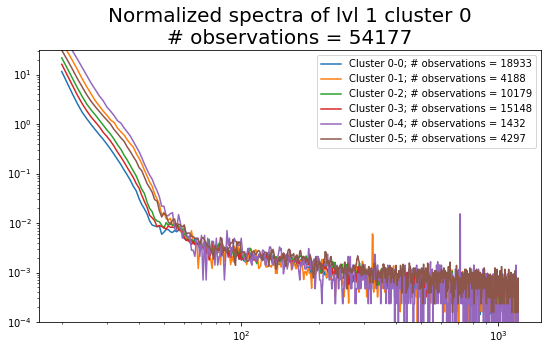

/apps/spack/gilbreth/apps/anaconda/2020.02-py37-gcc-4.8.5-mmvdvsv/lib/python3.7/site-packages/ipykernel_launcher.py:238: UserWarning: Data has no positive values, and therefore cannot be log-scaled.


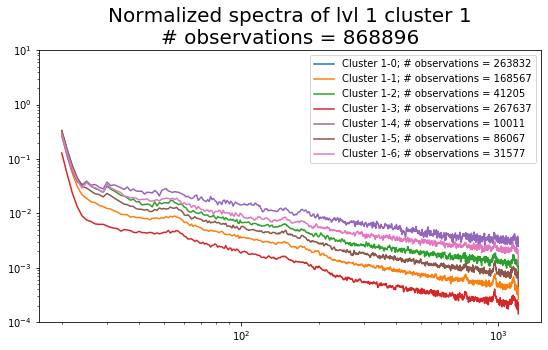

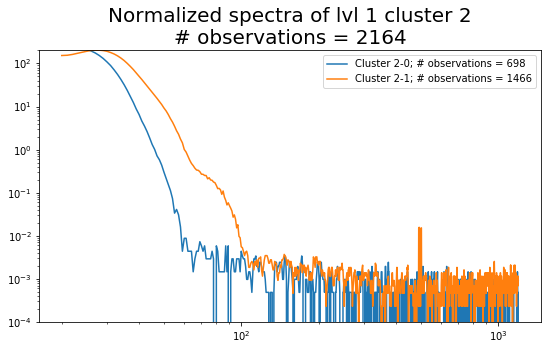

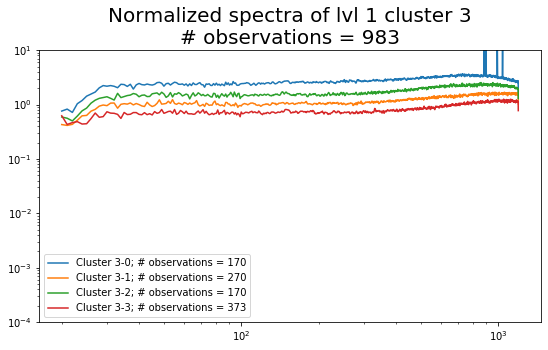

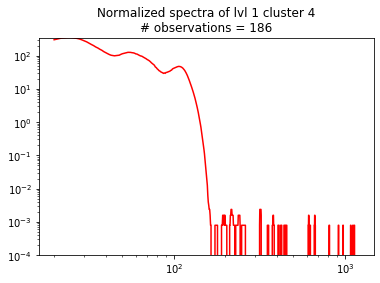

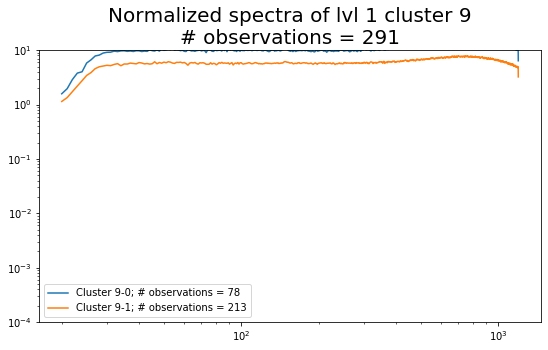

In [44]:
import pickle
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture

"""################################################################
    Train K-means Spectra clustering based on 
    photon counts in different energy bins

    There are 2-level spectra clustering:
        1. Level 1: cluster all clusters to k1 clusters
            -> use sqrt(counts) in 12 energy bins
        2. Level 2: further cluster each lvl 1's cluster
                    to k2 clusters (k2 <= 3).
                    Req: size(lvl_cluster) >= 10^3
            -> use sqrt(counts) in 2 energy bins
      
    ----------------------------------------------------------
    Overall workflow:
        1. define parameters: 
            -> ebins, spec_library, n_cluster, min_sample_cluster_2
        2. Initialize 2-level clustering model:
            -> model_cluster; model_cluster_2
            
        3. Train LEVEL 1 Spectra Clustering:
            -> define ebin groups
            -> aggregate photon counts based on ebins
            -> take sqrt
            -> fit model
            
        4. Train LEVEL 2 Spectra Clustering:
            -> define ebin groups
            -> aggregate photon counts based on ebins
            -> take sqrt
            -> for each LEVEL 1 cluster_id:
                 -> fit LEVEL 2 model
                     * NOTE: keep decreaseing n_clusters_2 
                             if each cluster not have min_samples_per_cluster
                 -> SAVE `spec_library`
                 -> Plot 
     ----------------------------------------------------------
################################################################"""

"""=====================================================================
    Function to check if each cluster has minimum number of samples
====================================================================="""
def check_minSample_perCluster(kmeans_model, num_clusters, min_samples_per_cluster):
    for cluster_id in range(num_clusters):
        if len(np.where(kmeans_model.labels_ == cluster_id)[0]) < min_samples_per_cluster:
            return False
        
    return True

""" ======================================================
    ============ IMPORTANT PARAMETERS ====================
    ======================================================
"""

""" ----- 1. original energy bins -----"""
ebins = list(y_train.columns.astype(int))
""" -----
    2. library of spectra by cluster
        spec_libary[<lvl 1 cluster ID>][<lvl 2 cluster ID>] = <normalized spectra of cluster>
-----"""
spec_library = {}

""" ----- 3. define number of clusters -----"""
n_clusters = 10 # n_cluster for level 1 clustering 
# n_clusters_2 = 2 # c_cluster for level 2 clustering -> change to dynamic mode
min_samples_per_cluster = 50
min_samples_cluster_2 = 2e2 # minimum samples in level 1 for further clustering in level 2

""" ----- 4. 2-level clustering models -----"""
model_cluster = None # Level 1 Clustering Model
models_cluster_2 = {cluster_id: None for cluster_id in range(n_clusters)} # Level 2 Clustering Model


""" ======================================================
    ============ SPECTRA CLUSTERING: LEVEL 1 =============
    ======================================================
"""
print('='*40)
print(f'Training LEVEL 1 clustering: k = {n_clusters}')

""" ----- 1. define energy bins for level 1 clustering -----"""
kmeans_ebins = []
kmeans_ebins.append([str(e) for e in range(20, 25,1)])    # 0.2 - 0.25 kev
kmeans_ebins.append([str(e) for e in range(25, 30,1)])    # 0.25 - 0.3 kev
kmeans_ebins.append([str(e) for e in range(30, 40,1)])    # 0.3 - 0.4 kev
kmeans_ebins.append([str(e) for e in range(40, 60,1)])   # 0.4 - 0.6 kev
kmeans_ebins.append([str(e) for e in range(60, 80,1)])   # 0.6 - 0.8 kev
kmeans_ebins.append([str(e) for e in range(80, 100,1)])   # 0.8 - 1.0 kev
kmeans_ebins.append([str(e) for e in range(100, 120,1)])  # 1.0 - 1.2 kev
kmeans_ebins.append([str(e) for e in range(120, 200,1)])  # 1.2 - 2.0 kev
kmeans_ebins.append([str(e) for e in range(200, 400,1)])  # 2.0 - 4.0 kev
kmeans_ebins.append([str(e) for e in range(400, 600,1)])  # 4.0 - 6.0 kev
kmeans_ebins.append([str(e) for e in range(600, 800,1)])  # 6.0 - 8.0 kev
kmeans_ebins.append([str(e) for e in range(800, 1200,1)]) # 8.0 - 12 kev

""" ----- 2. group photon counts by energy bins -----"""
n = len(y_train)
ybin_train = pd.DataFrame({ebin[0]: [0]*n for ebin in kmeans_ebins})
for i, ebin in enumerate(kmeans_ebins):
    col_name = ebin[0]
    for e in tqdm(ebin, desc=f'Aggregating photon counts for energy bin {i+1}'):
        # concatenate train & val set at energy level e
        e_cts = np.array(y_train[e])
        # aggregate all photon counts at energy level e \in ebin
        ybin_train[col_name] += e_cts

""" ----- 3. take the sqrt counts in of each energy bin -----"""
ybin_sqrt_train = np.sqrt(ybin_train)
display(ybin_sqrt_train)

""" ----- 4. LEVEL 1 spectra clustering using k-means on ybin_log_train -----"""
model_cluster = KMeans(n_clusters=n_clusters, random_state=0)
model_cluster.fit(ybin_sqrt_train)

print('='*40)
print()



""" ======================================================
    ============ SPECTRA CLUSTERING: LEVEL 2 =============
    ======================================================
"""
print('='*40)
print(f'Training LEVEL 2 clustering: k = dynamic = log10(# observations)+2')

""" ----- 1. define energy bins for level 2 clustering ----- """
kmeans_ebins_2 = []
kmeans_ebins_2.append([str(e) for e in range(20, 1200,1)])    # 0.2 - 1.2 kev
# kmeans_ebins_2.append([str(e) for e in range(240, 600,1)])    # 1.2 - 4 kev

""" ----- 2. group photon counts by energy bins -----"""
n = len(y_train)
ybin_train = pd.DataFrame({ebin[0]: [0]*n for ebin in kmeans_ebins_2})
for i, ebin in enumerate(kmeans_ebins_2):
    col_name = ebin[0]
    for e in tqdm(ebin, desc=f'Aggregating photon counts for energy bin {i+1}'):
        # concatenate train & val set at energy level e
        e_cts = np.array(y_train[e])
        # aggregate all photon counts at energy level e \in ebin
        ybin_train[col_name] += e_cts

""" ----- 3. take the sqrt counts in of each energy bin -----"""
ybin_sqrt_train = np.sqrt(ybin_train)
display(ybin_sqrt_train)

""" -----
    4. LEVEL 2 spectra clustering using k-means on ybin_log_train
        * if no LEVEL 2 -> add normalize spectra to spec_library[cluster_id]
        * if has LEVEL 2 -> add normalize spectra to spec_library[cluster_id][cluster2_id]
        
        * NOTE: Adaptive number of clusters: n_clusters_2 = np.log10(n_samples)-1
            where n_samples = # samples from LEVEL 1's cluster
    -----
"""
for cluster_id in tqdm(range(n_clusters), 
                       desc='training level 2 clustering'):
    """ 4.1. iloc indexes of samples correspond to current cluster_id"""
    indexes_iloc = np.where(model_cluster.labels_ == cluster_id)[0]
    n_samples = len(indexes_iloc)
    # Total count distribution -> sqrt() scale -> quite normal -> we can use GMM
    # plt.figure()
    # plt.title(f'Intensity distribution for cluster {cluster_id}')
    # plt.hist(np.sqrt(y_train.iloc[indexes_iloc].sum(axis=1)), bins=20)
    # plt.show()
    
    """ 4.2. skip if level 1 cluster doesnt have enough samples
            -> add normalized spectra to spec_library 
    """
    if n_samples < min_samples_cluster_2:
        """ compute normalized spectra from extracted iloc indexes"""
        y_cluster = y_train.iloc[indexes_iloc]
        """ remove outliers in the clusters for smoother curves"""
        y_cluster = y_cluster[y_cluster.sum(axis=1) <= y_cluster.sum(axis=1).quantile(0.99)]
        y_cluster = y_cluster[y_cluster.sum(axis=1) >= y_cluster.sum(axis=1).quantile(0.01)]
        cluster_spec = y_cluster.mean(axis=0)
        cluster_spec[80:] = smooth(cluster_spec[80:], window=7)
        
        """ ***** Add to lvl 1 spectra to spectra_library *****"""
        spec_library[cluster_id] = cluster_spec
        
        """ plot the cluster spec"""
        title = f'Normalized spectra of lvl 1 cluster {cluster_id}\n# observations = {len(indexes_iloc)}'
        plt.figure()
        plt.title(title)
        plt.plot(ebins, spec_library[cluster_id], color='red')
        plt.xscale('log')
        plt.yscale('log')
        plt.ylim([1e-4, max(10, cluster_spec.max())])
        plt.show()
        
        continue
    else:
        """ Initialize dict() to store level 2 spectra for cluster_id """
        spec_library[cluster_id] = {}
        """ Dynamically chosen n_clusters_2 based on # data"""
        n_clusters_2 = int(np.floor(np.log10(n_samples))+2)
        
        """ 4.3. spectra clustering using k-means on cluster 1's samples"""
        model_cluster_2 = KMeans(n_clusters=n_clusters_2, random_state=0)
        model_cluster_2.fit(ybin_sqrt_train.iloc[indexes_iloc])
        
        """ * Keep reducing number of centroids until all have min_samples_per_cluster """
        while not check_minSample_perCluster(model_cluster_2, n_clusters_2, min_samples_per_cluster):
            # reduce number of clusters
            n_clusters_2 = n_clusters_2 - 1
            # train level 2 model
            model_cluster_2 = KMeans(n_clusters=n_clusters_2, random_state=0)
            model_cluster_2.fit(ybin_sqrt_train.iloc[indexes_iloc])
    
    """ ***** LEVEL 2 model for LEVEL 1's cluster_id *****"""
    models_cluster_2[cluster_id] = model_cluster_2
    
    """ 4.4. 2-level spectra clustering plots"""
    plt.figure(figsize=(9,5))
    plt.title(f'Normalized spectra of lvl 1 cluster {cluster_id}\n# observations = {len(indexes_iloc)}', fontsize=20)
    
    
    """ PLOTS & SAVING TO SPEC_LIBRARY """
    for cluster2_id in range(n_clusters_2):
        indexes_iloc_lvl2 = np.where(model_cluster_2.labels_ == cluster2_id)[0]
        """ compute normalized spectra from extracted iloc indexes"""
        y_cluster = y_train.iloc[indexes_iloc].iloc[indexes_iloc_lvl2]
        """ remove outliers in the clusters for smoother curves"""
        y_cluster = y_cluster[y_cluster.sum(axis=1) <= y_cluster.sum(axis=1).quantile(0.99)]
        y_cluster = y_cluster[y_cluster.sum(axis=1) >= y_cluster.sum(axis=1).quantile(0.01)]
        cluster_spec = y_cluster.mean(axis=0)
        cluster_spec[80:] = smooth(cluster_spec[80:], window=3)
        
        """ ***** Add to lvl 2 spectra to spectra_library *****"""
        spec_library[cluster_id][cluster2_id] = cluster_spec
        
        plt.plot(ebins, cluster_spec, label=f'Cluster {cluster_id}-{cluster2_id}; # observations = {len(indexes_iloc_lvl2)}')
        plt.xscale('log')
        plt.yscale('log')
        plt.ylim([1e-4, max(10, cluster_spec.max())])
    plt.legend()
    plt.show()

print('='*40)
print()

In [46]:
"""#################################################
    Save trained clustering model AND 
    spectra library for each spectra cluster
#################################################"""
cluster_saveDir = 'cluster_model/2levels'
os.system(f'mkdir -p {cluster_saveDir}')
    
# Save energy bin group used to train the cluster model
with open(f"{cluster_saveDir}/kmeans_ebins_lvl1.pkl", "wb") as f:
    pickle.dump(kmeans_ebins, f)
with open(f"{cluster_saveDir}/kmeans_ebins_lvl2.pkl", "wb") as f:
    pickle.dump(kmeans_ebins_2, f)
    
# Save trained LEVEL 1 cluster model
with open(f"{cluster_saveDir}/kmeans_k1={n_clusters}_k2=dynamic_lvl1_v2.pkl", "wb") as f:
    pickle.dump(model_cluster, f)
# Save trained LEVEL 2 cluster model
with open(f"{cluster_saveDir}/kmeans_k1={n_clusters}_k2=dynamic_lvl2_v2.pkl", "wb") as f:
    pickle.dump(models_cluster_2, f)
    
# Save spectra library for each cluster
with open(f"{cluster_saveDir}/spec_library_k={n_clusters}_2lvls_v2.pkl", "wb") as f:
    pickle.dump(spec_library, f)

In [40]:
# """#################################################
#         Construct spectra library by 
#         computing normalized spectra 
#         of different clusters defined by 
#         trained k-means clustering
# #################################################"""

# """ 1. original energy bins"""
# ebins = list(y_train.columns.astype(int))

# """ 
#     2. library of spectra by cluster
#         spec_libary[brightness][k] = normalized spectra of cluster k-th 
#                                      for specified`brightness` level
# """
# spec_library = []

# for cluster_id in tqdm(range(n_clusters), 
#                        desc='compute normalized spectra of different clusters'):
#     """ iloc indexes of samples correspond to current cluster_id"""
#     indexes_iloc = np.where(model_cluster.labels_ == cluster_id)[0]

#     """ compute normalized spectra from extracted iloc indexes"""
#     y_cluster = y_train.iloc[indexes_iloc]
#     """ remove outliers in the clusters for smoother curves"""
#     y_cluster = y_cluster[y_cluster.sum(axis=1) <= y_cluster.sum(axis=1).quantile(0.98)]
#     y_cluster = y_cluster[y_cluster.sum(axis=1) >= y_cluster.sum(axis=1).quantile(0.02)]
#     cluster_spec = y_cluster.mean(axis=0)
#     cluster_spec[80:] = smooth(cluster_spec[80:], window=3)
    
#     spec_library.append(cluster_spec)

#     """ plot the cluster spec"""
#     plt.figure()
#     plt.title(f'Normalized spectra of cluster {cluster_id}\nTotal events = {len(indexes_iloc)}')
#     plt.plot(ebins, spec_library[cluster_id])
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.ylim([1e-4, max(10, cluster_spec.max())])
#     plt.show()

## Qualitative Testing

In [88]:
# spec_library

In [47]:
cluster_saveDir = 'cluster_model/2levels'
n_clusters = 10 # 15
ver = 'v2' # 'v3'

# load energy bin group used to train the cluster model
with open(f"{cluster_saveDir}/kmeans_ebins_lvl1.pkl", "rb") as f:
    kmeans_ebins = pkl.load(f)
with open(f"{cluster_saveDir}/kmeans_ebins_lvl2.pkl", "rb") as f:
    kmeans_ebins_2 = pkl.load(f)

    
# load trained cluster model
with open(f"{cluster_saveDir}/kmeans_k1={n_clusters}_k2=dynamic_lvl1_{ver}.pkl", "rb") as f:
    model_cluster = pkl.load(f)
with open(f"{cluster_saveDir}/kmeans_k1={n_clusters}_k2=dynamic_lvl2_{ver}.pkl", "rb") as f:
    models_cluster_2 = pkl.load(f)
    
# load spectra library for each cluster
with open(f"{cluster_saveDir}/spec_library_k={n_clusters}_2lvls_{ver}.pkl", "rb") as f:
    spec_library = pkl.load(f)

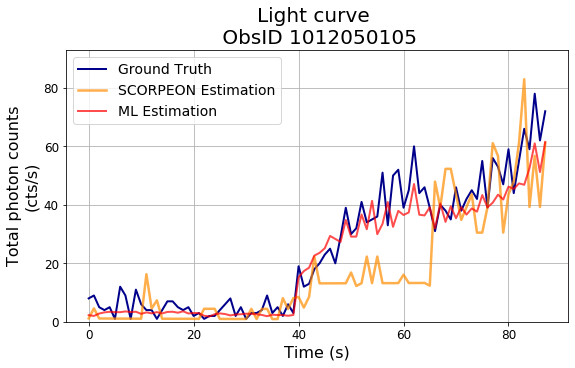

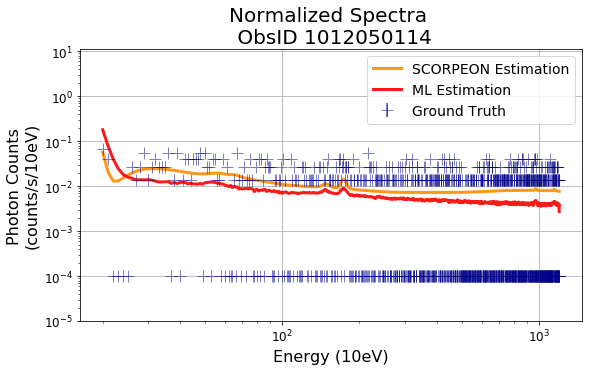

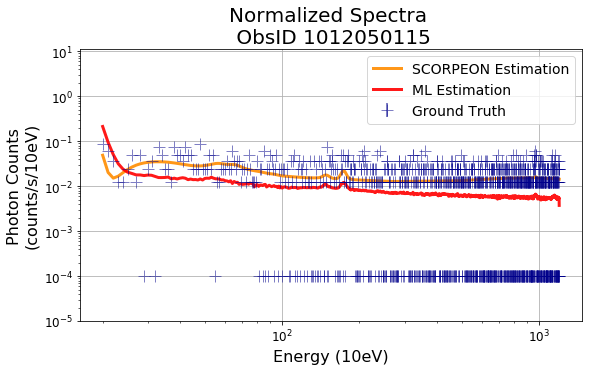

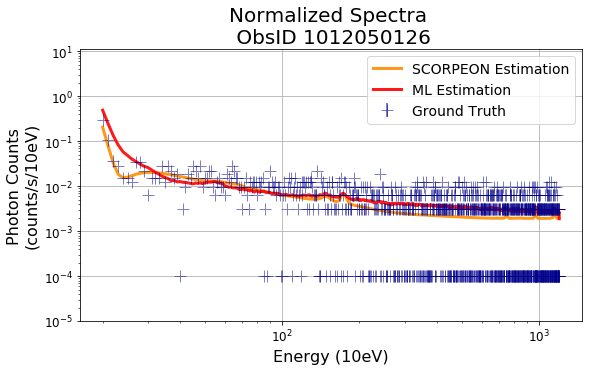

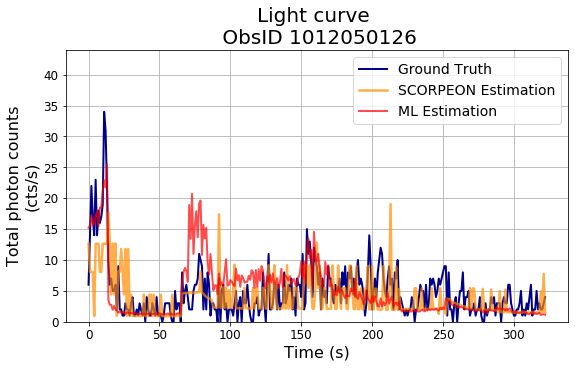

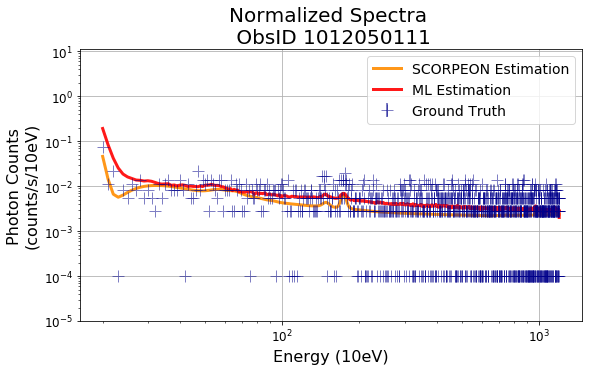

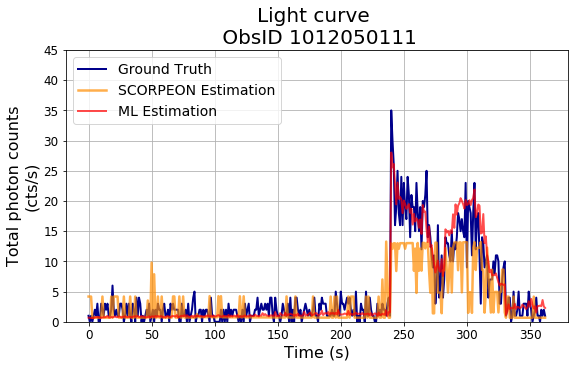

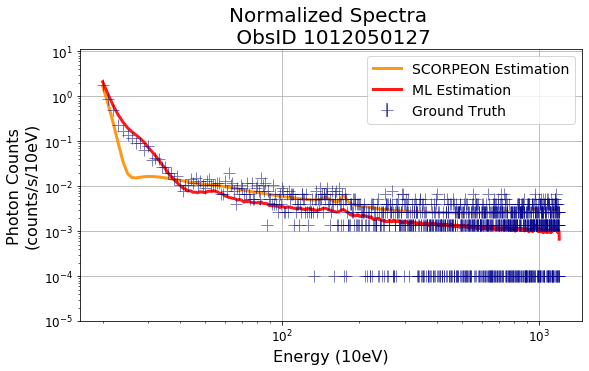

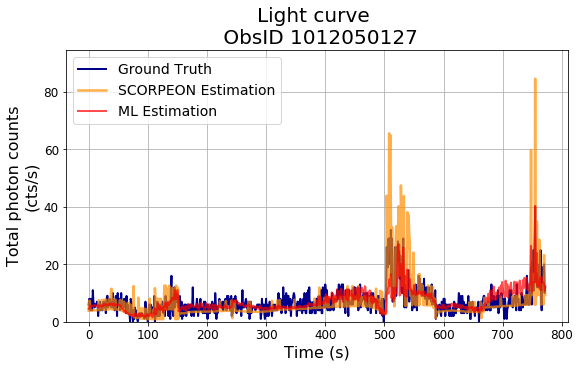

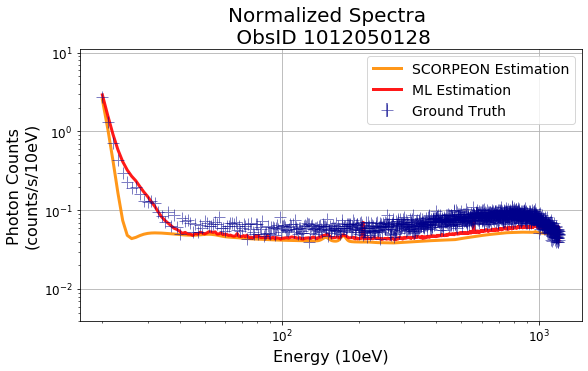

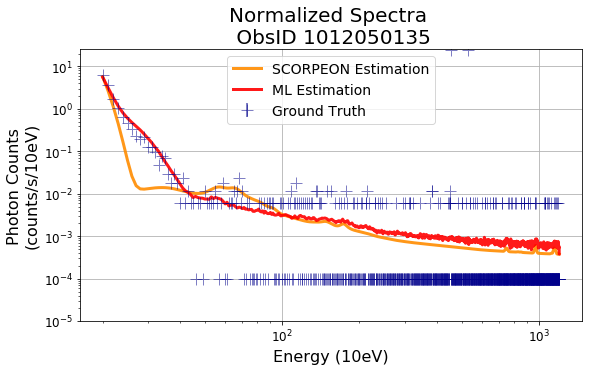

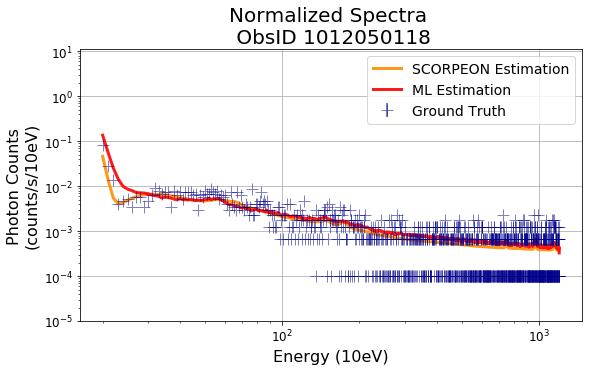

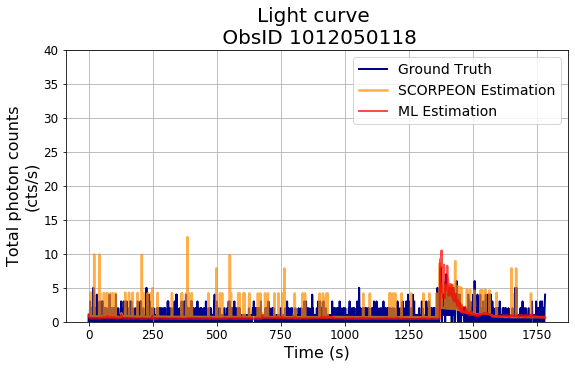

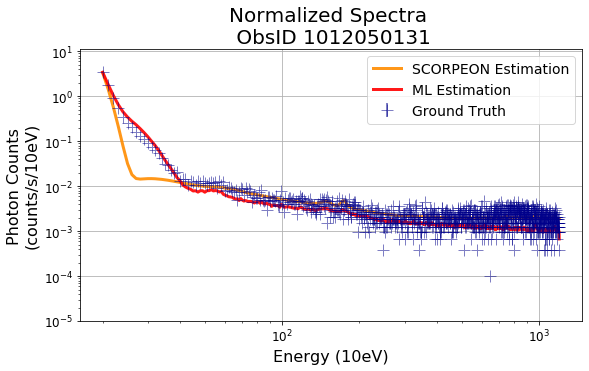

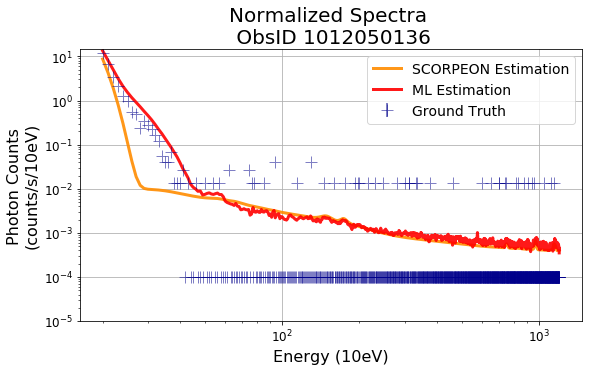

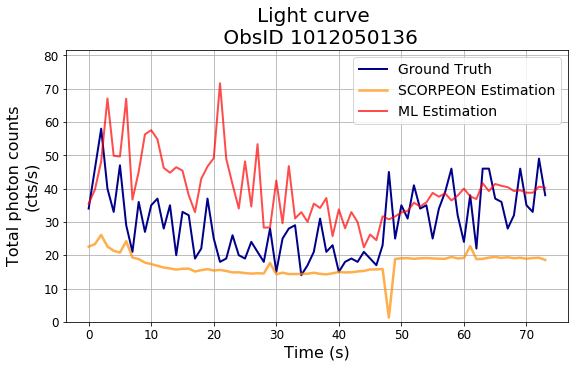

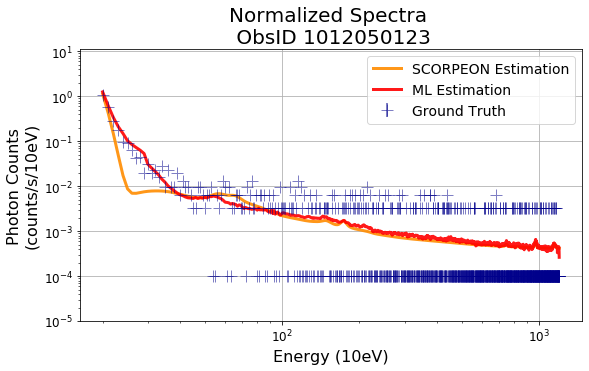

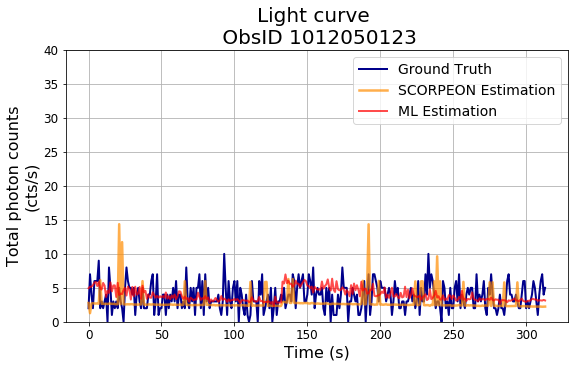

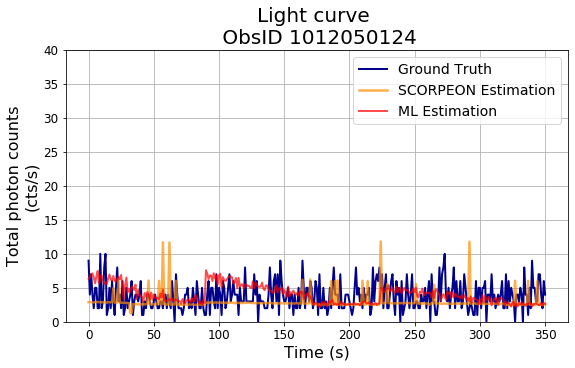

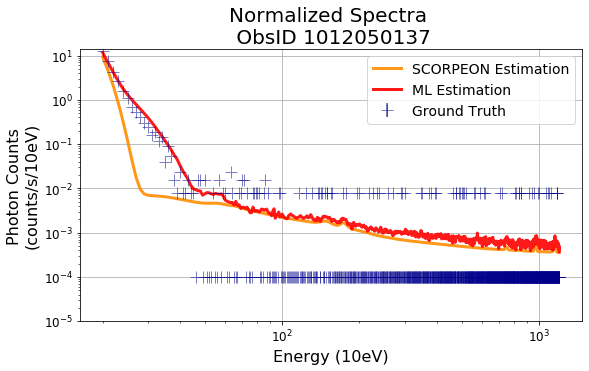

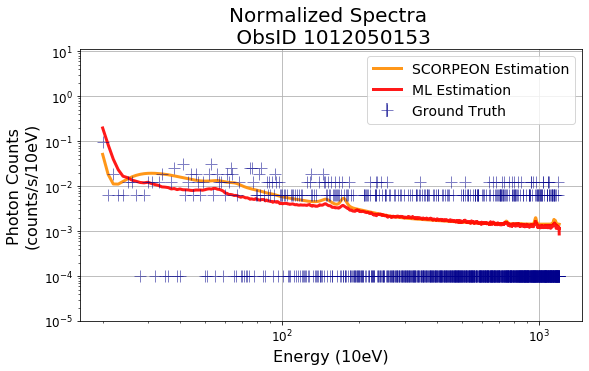

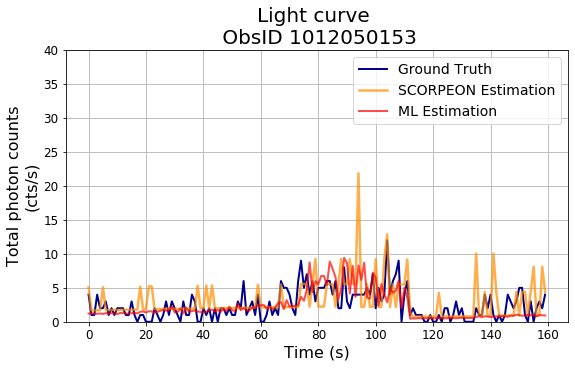

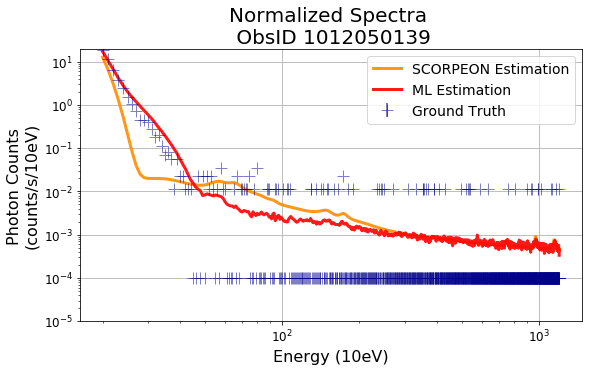

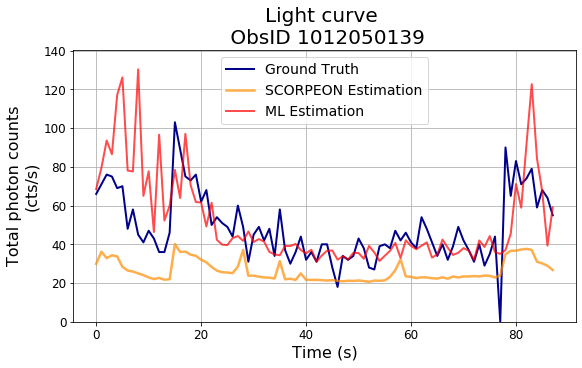

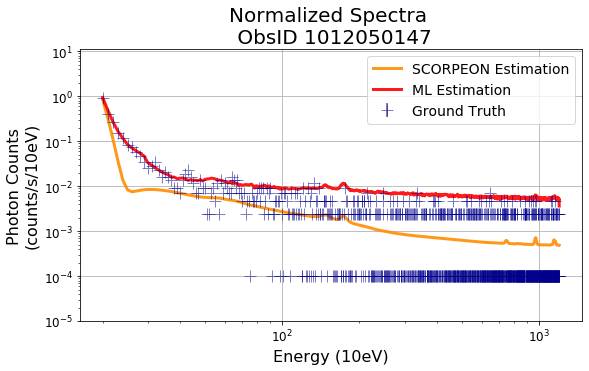

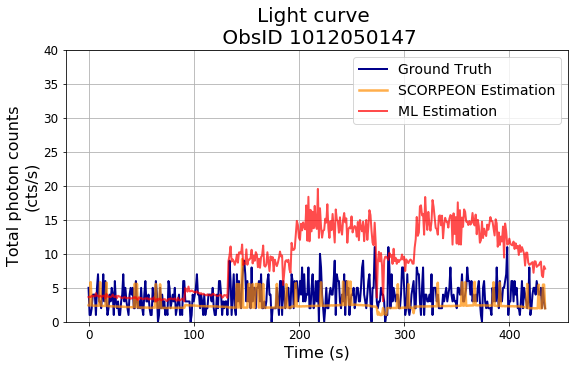

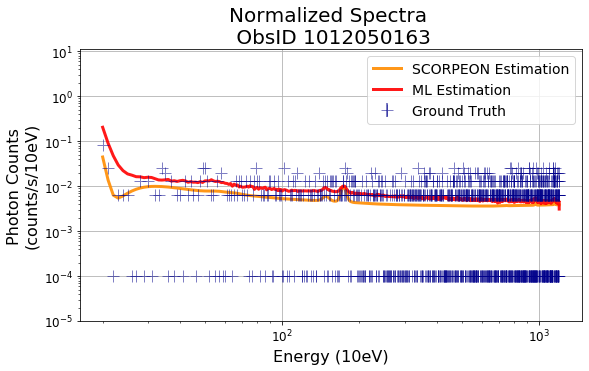

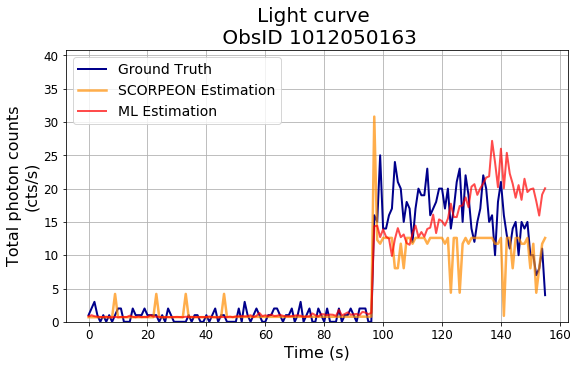

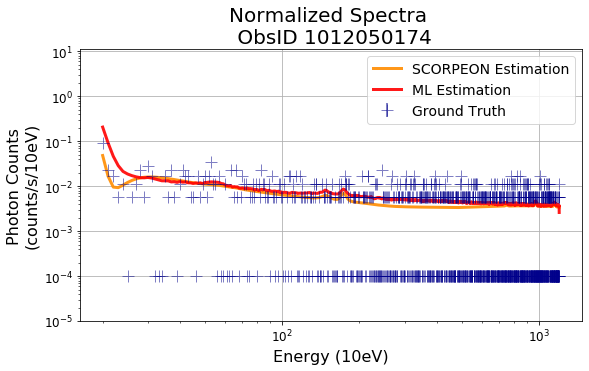

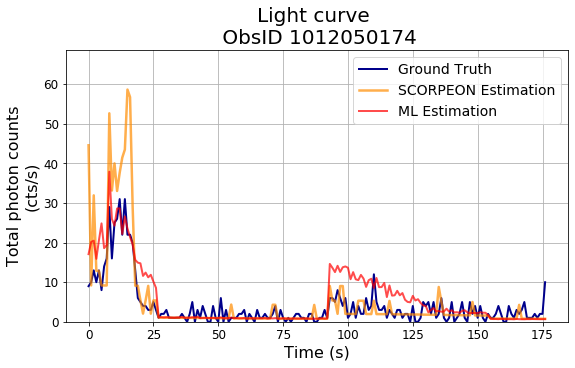

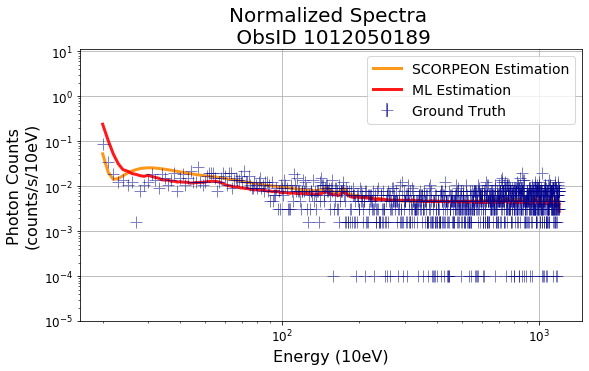

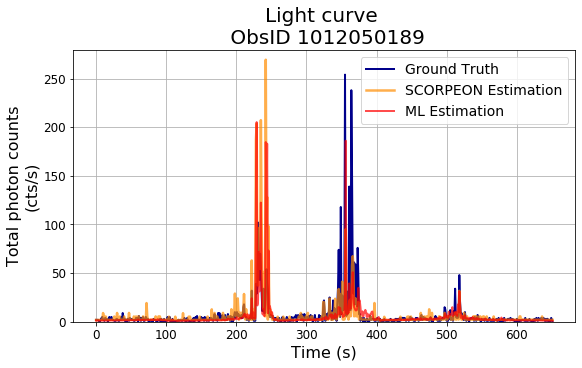

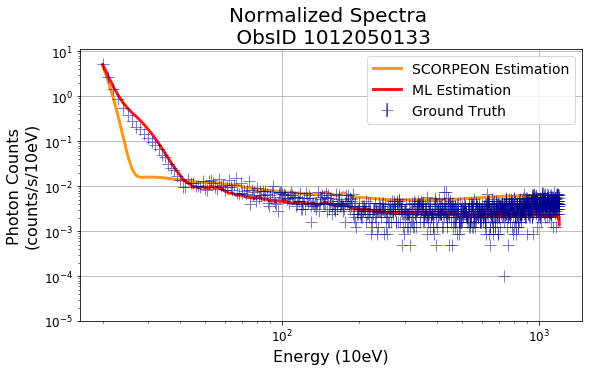

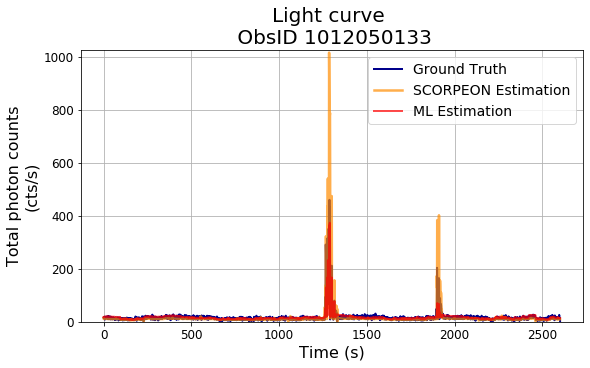

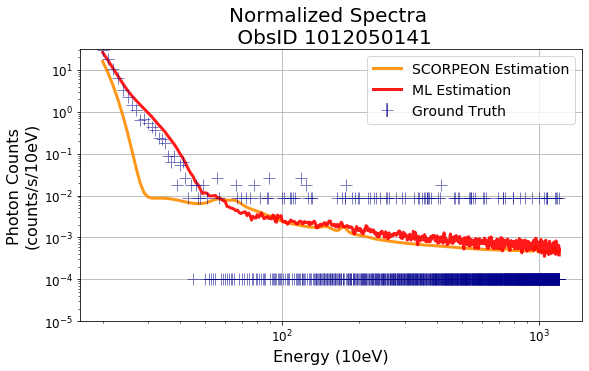

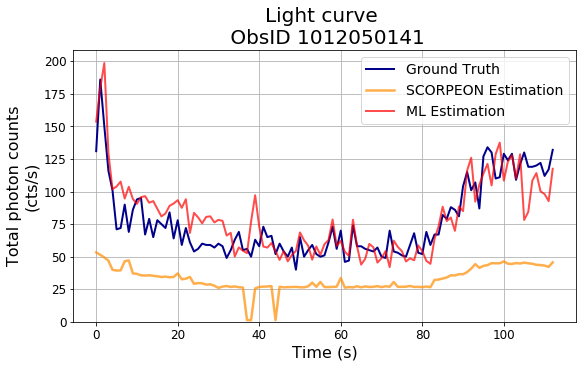

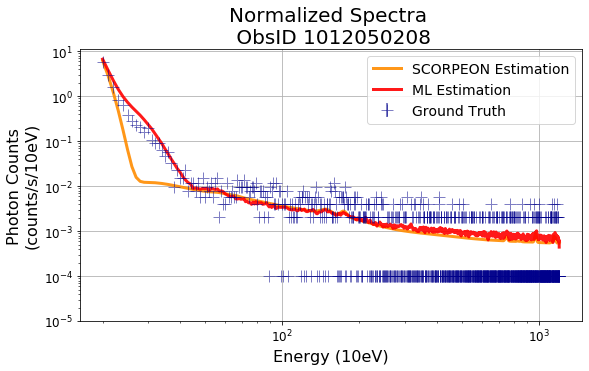

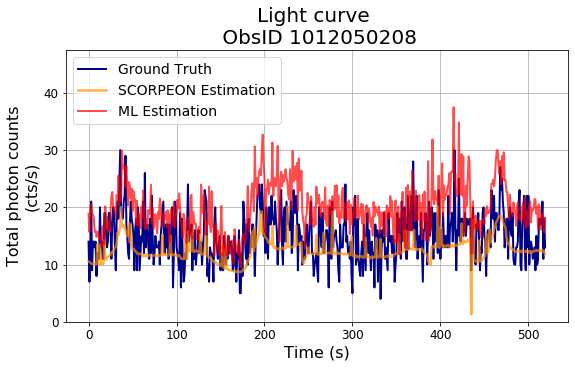

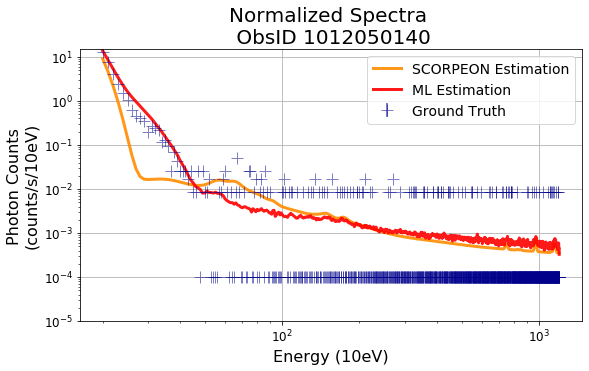

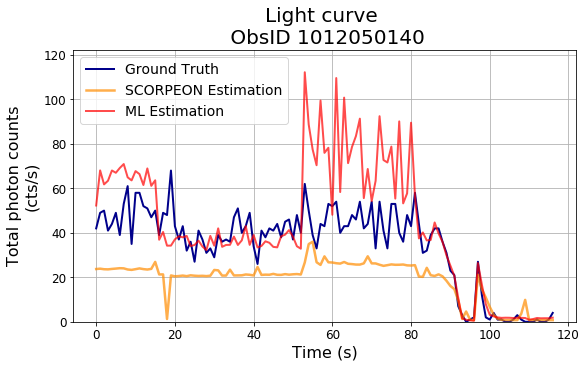

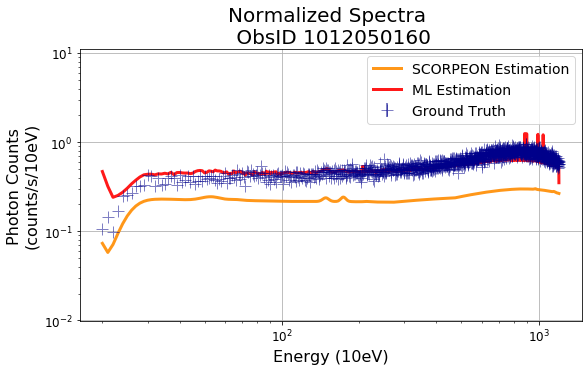

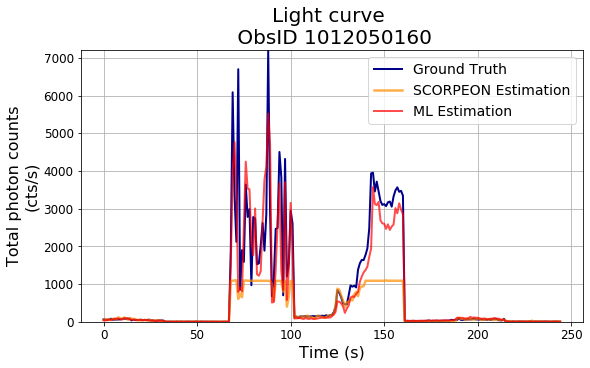

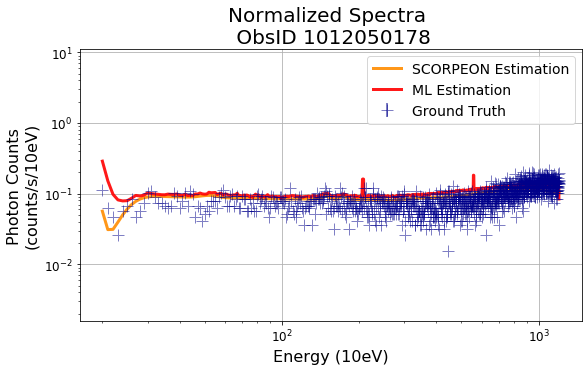

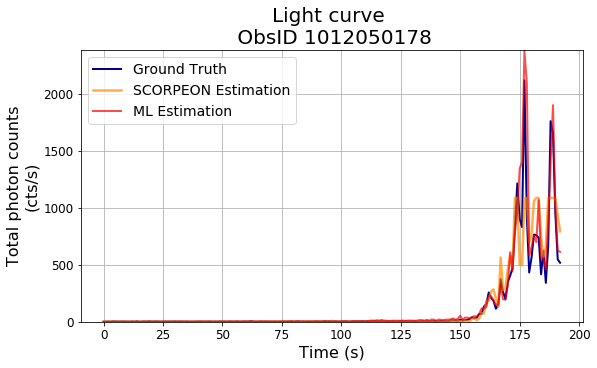

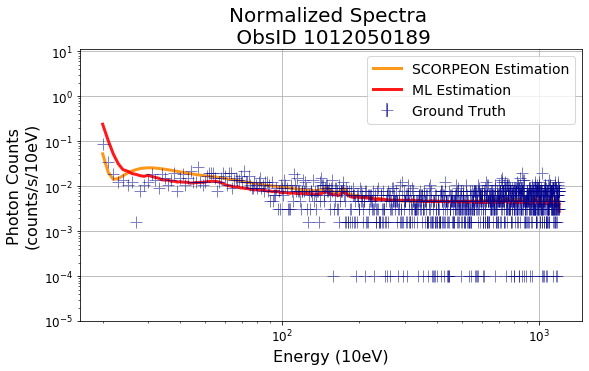

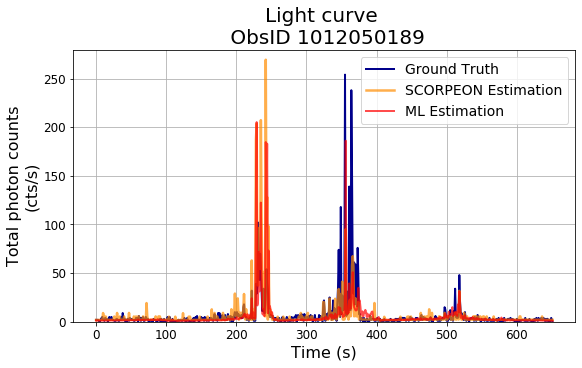

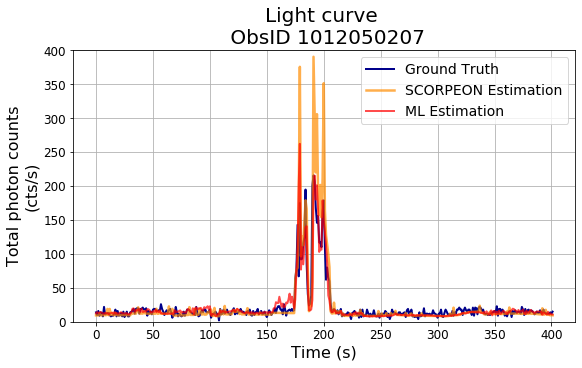

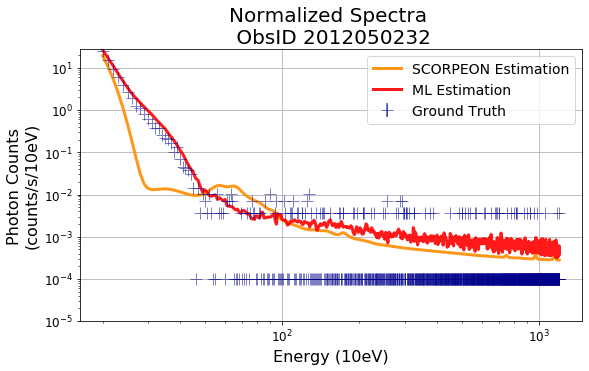

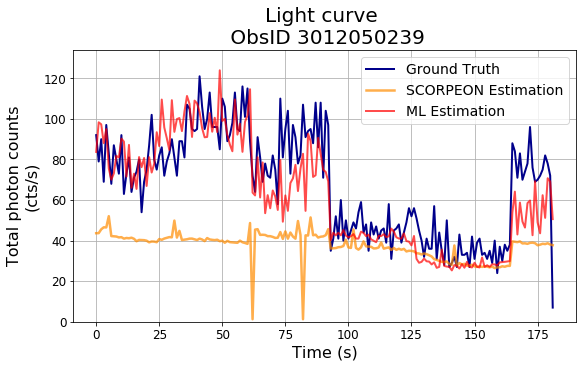

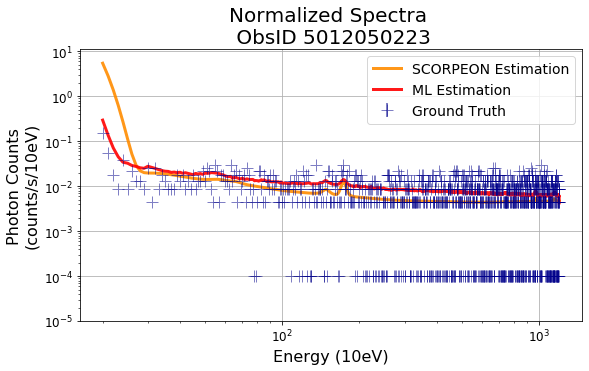

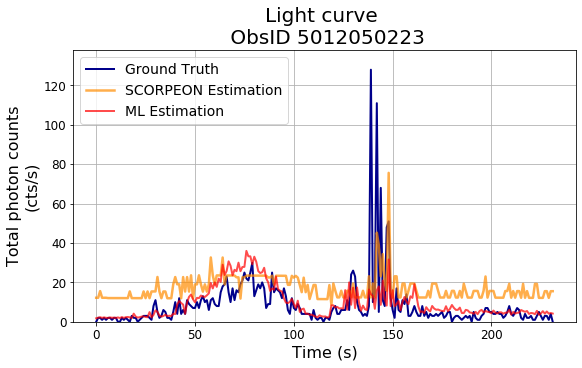

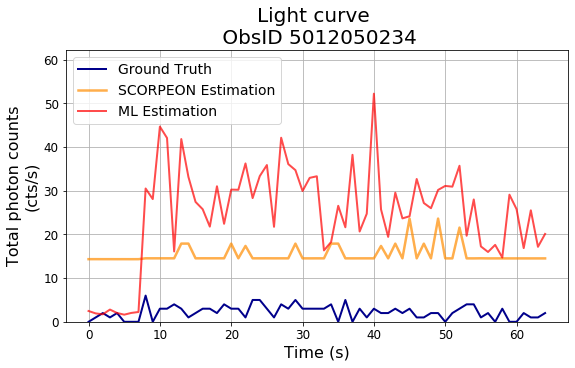

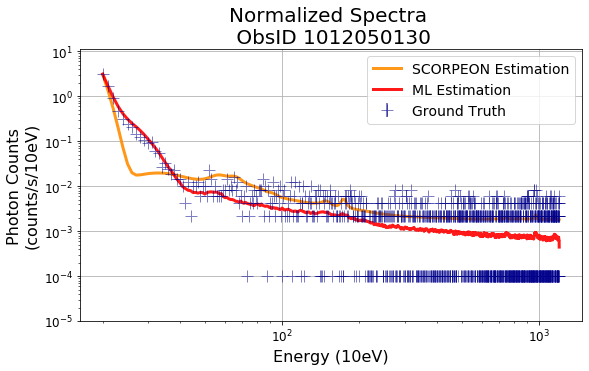

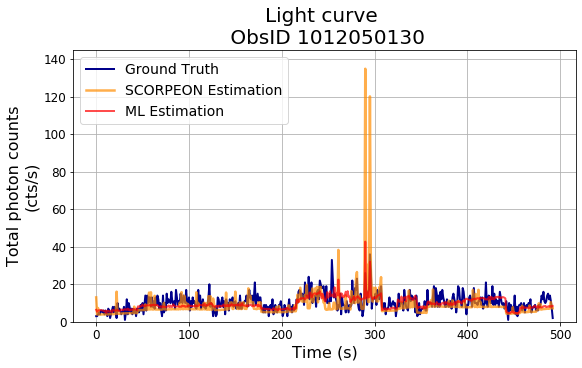

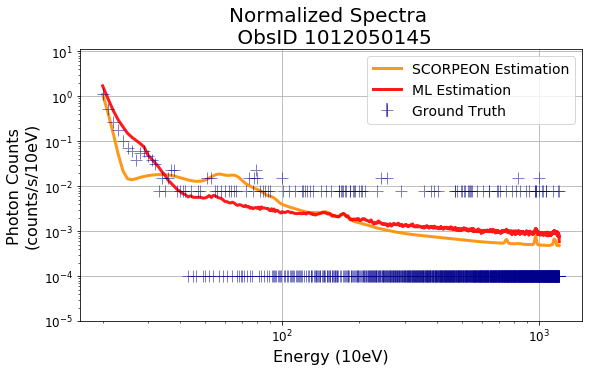

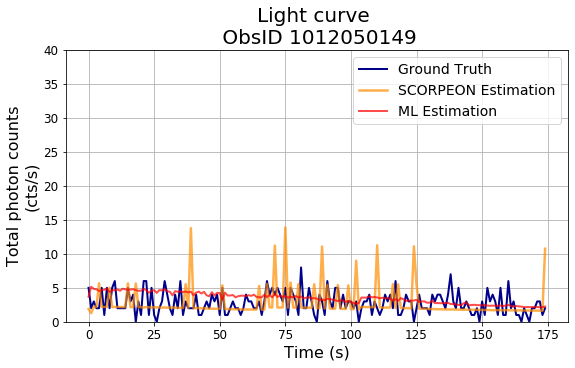

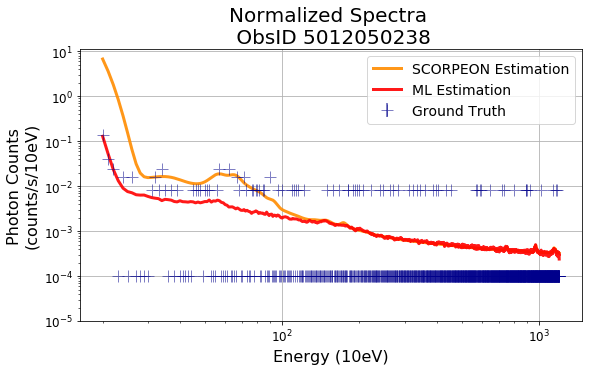

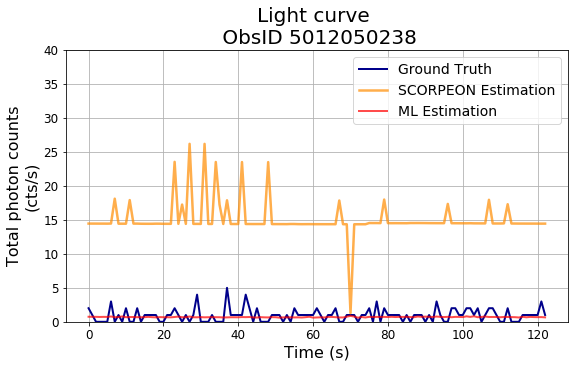

In [57]:
""" Energy bins & Normalized Spectra"""
ebins = list(y_train.columns.astype(int))

""" 
    Extract all events from each ObsID 
    Store results in format:
        obsID => (specs_gt, specs_gt_std, specs_scorps, specs_preds, lc_gt, lc_scorps, lc_preds)
"""
obsid_results = {}
indexes = [i for i in y_test.index if i in obsid_df.index]
obsid_df.loc[indexes]

test_obsid_df = obsid_df.loc[indexes]
obsid_list = [1012050105, 1012050114, 1012050115, 1012050126, 
              1012050111, 1012050127, 1012050128, 1012050132, 
              1012050135, 1012050118, 1012050131, 1012050136, 
              1012050123, 1012050124, 1012050137, 1012050153,
              1012050139, 1012050147, 1012050163, 1012050174, 
              1012050189, 1012050133, 1012050141, 1012050208,
              1012050140, 1012050160, 1012050178, 1012050179, 
              1012050189, 1012050207, 2012050232, 3012050239, 
              4012050230, 5012050223, 5012050231, 5012050234, 
              1012050130, 1012050145, 1012050149, 5012050238,]
# obsid_list = [i for i in test_obsid_df.obsID.unique() if i not in obsid_list]

""" 
    Iterate through each ObsID to plot the normalized spectra & lightcurve
"""
for obsid in tqdm(obsid_list):
    ########################################################
    # 1. Store results here
    ########################################################
    obsid_results[obsid] = {}
    
    ###############################################################
    # 2. Extract events from the same ObsID AND is in scorp_specs
    ###############################################################
    # 2a. Get .loc indexes of obsid
    indexes = test_obsid_df[test_obsid_df['obsID'] == obsid].index
    indexes = [idx for idx in indexes if idx in scorp_specs.index]
    
    # ignore ObsID with fewer than 60 observations
    if len(indexes) < 60: 
        continue
        
    # 2b. Get .iloc indexes of obsid
    #     + create new test_obsid_df
    #     + create new column call 'iloc_index'
    X_test_iloc = X_test.copy()
    X_test_iloc['index_iloc'] = X_test_iloc.reset_index().index
    indexes_iloc = list(X_test_iloc.loc[indexes]['index_iloc'])

    ########################################################
    # 3. Compute normalized spectra from extracted ObsID
    ########################################################
    obsid_specs_gt = y_test.loc[indexes].mean(axis=0)
    obsid_specs_gt_std = y_test.loc[indexes].std(axis=0)
    obsid_specs_scorps = scorp_specs.loc[indexes].mean(axis=0)
    obsid_specs_preds = predict_normalized_spectra(dnn, 
                                                   X=TensorX_test[indexes_iloc].to(device), 
                                                   model_cluster=model_cluster, 
                                                   models_cluster_2=models_cluster_2,
                                                   cluster_ebins=kmeans_ebins, 
                                                   cluster_ebins_2=kmeans_ebins_2,
                                                   spec_library=spec_library)
    
    ########################################################
    # 4. Compute light curve from extracted ObsID
    ########################################################
    # obsid_preds = dnn(TensorX_test[indexes_iloc].to(device)).detach().cpu().numpy()
    # obsid_lc_preds = obsid_preds.sum(axis=1)
    obsid_lc_preds = predict_lightcurve(dnn, 
                                        X=TensorX_test[indexes_iloc].to(device))
    obsid_lc_gt = y_test.loc[indexes].sum(axis=1)
    obsid_lc_gt = np.array(obsid_lc_gt)
    obsid_lc_scorps = scorp_specs.loc[indexes].sum(axis=1)
    obsid_lc_scorps = np.array(obsid_lc_scorps)
    
    ########################################################
    # 5. Plot normalized spectra and light curves
    ########################################################
    # Add 1e-4 to all ground-truth & predictions for visualization purpose
    obsid_specs_gt = obsid_specs_gt + 1e-4
    obsid_specs_preds = obsid_specs_preds + 1e-4
    # Plotting functions
    plotSpecs_freq_domain(ebins, obsid_specs_preds, obsid_specs_gt, 0,
                          obsid_specs_scorps, title=f'Normalized Spectra \n ObsID {obsid}')
    plotSpecs_time_domain(ebins, obsid_lc_preds, obsid_lc_gt, 
                          obsid_lc_scorps, title=f'Light curve \n ObsID {obsid}')

In [51]:
""" list of ObsID in test set"""
test_indexes = [i for i in y_test.index if i in obsid_df.index]
test_obsid_df = obsid_df.loc[test_indexes]
obsid_list = test_obsid_df.obsID.unique()

"""==================================================
        Iterate through each ObsID 
        to compute normalized spectra
=================================================="""
all_specs_gt = []
all_specs_scorps = []
all_specs_preds = []

for obsid in tqdm(obsid_list, desc='compute normalized spectra for each ObsID'):
    # 1. Get .loc indexes of obsid
    indexes = test_obsid_df[test_obsid_df['obsID'] == obsid].index
    indexes = [idx for idx in indexes if idx in scorp_specs.index]
    
    # ignore ObsID with fewer than 60 observations
    if len(indexes) < 60: 
        continue
        
    # 2b. Get .iloc indexes of obsid
    #     + create new test_obsid_df
    #     + create new column call 'iloc_index'
    X_test_iloc = X_test.copy()
    X_test_iloc['index_iloc'] = X_test_iloc.reset_index().index
    indexes_iloc = list(X_test_iloc.loc[indexes]['index_iloc'])

    ########################################################
    # 3. Compute normalized spectra from extracted ObsID
    ########################################################
    obsid_specs_gt = y_test.loc[indexes].mean(axis=0)
    obsid_specs_gt_std = y_test.loc[indexes].std(axis=0)
    obsid_specs_scorps = scorp_specs.loc[indexes].mean(axis=0)
    obsid_specs_preds = predict_normalized_spectra(dnn, 
                                                   X=TensorX_test[indexes_iloc].to(device), 
                                                   model_cluster=model_cluster, 
                                                   models_cluster_2=models_cluster_2,
                                                   cluster_ebins=kmeans_ebins, 
                                                   cluster_ebins_2=kmeans_ebins_2,
                                                   spec_library=spec_library)
   
    # raw prediction without spec_cluster
    # obsid_specs_preds = dnn(TensorX_test[indexes_iloc].to(device)).detach().cpu().numpy().mean(axis=0)
    
    ########################################################
    # 4. record normalized spectra for each ObsID
    #     + ground-truth normalized spectra
    #     + SCORPEON normalized spectra
    #     + ML predicted normalized spectra
    ########################################################
    all_specs_gt.append(obsid_specs_gt)
    all_specs_scorps.append(obsid_specs_scorps)
    all_specs_preds.append(obsid_specs_preds)
    
"""==================================================
        Compute normalized spectra loss
=================================================="""
all_specs_gt = np.array(all_specs_gt)
all_specs_scorps = np.array(all_specs_scorps)
all_specs_preds = np.array(all_specs_preds)

spec_err = {}
# evaluation: root-mean-squared-error
spec_err['sc (rmse)'] = spectra_rmse(all_specs_gt, all_specs_scorps)
spec_err['ml (rmse)'] = spectra_rmse(all_specs_gt, all_specs_preds)
# evaluation: n3 similarity score
spec_err['sc (n3)'] = ns3_score(all_specs_gt, all_specs_scorps)
spec_err['ml (n3)'] = ns3_score(all_specs_gt, all_specs_preds)
# evaluation: hardness ratio rmse
# faint_bkgds = np.where(all_specs_gt.sum(axis=1) < 20)
spec_err['sc (HR rmse)'] = spectra_harnessRatio_rmse(all_specs_gt[:], all_specs_scorps[:])
spec_err['ml (HR rmse)'] = spectra_harnessRatio_rmse(all_specs_gt[:], all_specs_preds[:])

print('1a. Root MSE -> pure mean error \n(lower the better):')
print('\t SCORPEON (Normalized Spectra):', spec_err['sc (rmse)'])
print('\t ML (Normalized Spectra):', spec_err['ml (rmse)'])\
#
print('2. N3 Similarity Score (error + shape)\n(lower the better -> stronger match):')
print('\t SCORPEON (Normalized Spectra):', spec_err['sc (n3)'])
print('\t ML (Normalized Spectra):', spec_err['ml (n3)'])
#
print('3. Hardness Ratio Root MSE -> mean error of Hardness Ratios \n(lower the better):')
print('\t SCORPEON (Normalized Spectra):', spec_err['sc (HR rmse)'])
print('\t ML (Normalized Spectra):', spec_err['ml (HR rmse)'])


1a. Root MSE -> pure mean error 
(lower the better):
	 SCORPEON (Normalized Spectra): 0.5668061931291187
	 ML (Normalized Spectra): 0.37695177601698826
2. N3 Similarity Score (error + shape)
(lower the better -> stronger match):
	 SCORPEON (Normalized Spectra): 0.7295501177404241
	 ML (Normalized Spectra): 0.5340723840439462
3. Hardness Ratio Root MSE -> mean error of Hardness Ratios 
(lower the better):
	 SCORPEON (Normalized Spectra): 0.16739006490707353
	 ML (Normalized Spectra): 0.17689638778949604


In [75]:
# indexes_iloc = np.where(spec_model.labels_ == 12)[0]
# y_train.iloc[indexes_iloc].mean(axis=0)

In [211]:
# """ Qualitative Investigate random sample with GT photon counts is high"""
# dnn = dnn.cpu()
# dnn.eval()

# for logscale in scale_indexes['Test']:
#     """ 1. Load samples with XRAY_TOTAL_COUNT in a specific logscale"""
#     y_temp = y_test.reset_index(drop=True)
#     indexes = scale_indexes['Test'][logscale]
#     if len(indexes) == 0:
#         continue
#     # indexes = [i for i in range(55770, 56130)]
#     # gti = GTIs_test[20]
#     # indexes = [i for i in range(gti[0], gti[1], 1)]
#     # indexes = y_temp[y_temp.sum(axis=1) == 0].index
    
#     smpl_X_test = TensorX_test[indexes]
#     smpl_y_test = y_test.iloc[indexes]

#     """ 2. Run Model Inference"""
#     # print(smpl_y_test.sum(axis=1))
#     preds = dnn(smpl_X_test)
#     # preds = torch.round(preds)
#     preds = preds.detach().cpu().numpy()
#     # temp = preds
    

#     """ 3.1. Ground Truth Spectrum Visualization"""
#     # display(smpl_y_test)
#     # print(smpl_y_test.columns)
#     plt.figure(figsize=(16,6))
#     plt.title('X-Ray Spectrum\nTotal Photon counts $\in$' + scale_lists[logscale][0], fontsize=20)
#     specs_gt = smpl_y_test.mean(axis=0)
#     plt.plot(ebins, specs_gt, '+', color='green', label=f'Ground Truth Spectrum', alpha=1)

#     """ 3.2. Predicted Spectrum Visualization"""
#     # print(preds.shape)
#     num_samples = len(preds)
#     preds = pd.DataFrame(preds.reshape(num_samples,-1), columns=y_test.columns)
#     specs_pred = preds.mean(axis=0)
#     specs_pred = smooth(specs_pred, 10)
#     print(spectra_IOU(np.array([specs_gt]), np.array([specs_pred])))
#     plt.plot(ebins, specs_pred, color='red', label=f'Predicted Spectrum', alpha=0.5)
#     # temp = preds.mean()
#     # plt.ylim([0.5e-4, 1e3])
#     plt.xlabel('Energy (keV)', fontsize=16)
#     plt.ylabel('Photon Counts', fontsize=16)
#     plt.xscale('log')
#     plt.yscale('log')
#     plt.xticks(fontsize=12)
#     plt.yticks(fontsize=12)
#     # ax.set_ylim([0, 9000])
#     plt.grid('--', axis='y')
#     plt.legend(fontsize=12)
#     plt.show()

#     del smpl_X_test, smpl_y_test, preds
        
# del y_temp, indexes
# print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')

Index(['ROLL', 'SAT_LAT', 'SAT_LON', 'SAT_ALT', 'ELV', 'BR_EARTH', 'SUNSHINE',
       'TIME_SINCE_SUNSET', 'SUN_ANGLE', 'BETA_ANGLE', 'LOCAL_TIME',
       'MOON_ANGLE', 'RAM_ANGLE', 'EAST_ANGLE', 'ANG_DIST', 'SAA', 'SAA_TIME',
       'COR_ASCA', 'COR_SAX', 'MCILWAIN_L', 'MAGFIELD', 'MAGFIELD_MIN',
       'MAG_ANGLE', 'AP8MIN', 'AE8MIN', 'ATT_ANG_AZ', 'ATT_ANG_EL',
       'FPM_RATIO_REJ_COUNT', 'FPM_OVERONLY_COUNT', 'FPM_UNDERONLY_COUNT',
       'FPM_DOUBLE_COUNT', 'FPM_FT_COUNT', 'FPM_NOISE25_COUNT',
       'XTI_PNT_JITTER', 'KP', 'SOLAR_PHI', 'COR_NYM', 'ANG_DIST_X',
       'ANG_DIST_Y', 'FPM_TRUMP_SEL_1500_1800', 'FPM_RATIO_REJ_300_1800',
       'FPM_SLOW_LLD', 'MPU_NOISE20_COUNT', 'MPU_NOISE25_COUNT',
       'MPU_OVERONLY_COUNT', 'MPU_UNDERONLY_COUNT'],
      dtype='object')


ROLL    SAT_LAT     SAT_LON      SAT_ALT        ELV  \
29466    211.640106  11.436400  334.718201  6779.921387  78.697601   
29468    211.597595  11.335900  334.793488  6779.945801  78.824097   
29470    211.552704  11.235500  334.868713  6779.969727  78.945396   
29472    211.539597  11.135000  334.943909  6779.992676  79.072998   
29474    211.497498  11.034500  335.019012  6780.016602  79.190399   
...             ...        ...         ...          ...        ...   
3037642   60.483601 -32.141899  166.326996  6797.324219  83.964897   
3037644   60.662800 -32.053902  166.430099  6797.311035  83.931297   
3037646   60.982201 -31.921600  166.584305  6797.291016  83.858902   
3037648   61.171299 -31.833300  166.686798  6797.278320  83.811501   
3037650   61.335098 -31.744900  166.789093  6797.264648  83.762398   

           BR_EARTH  SUNSHINE  TIME_SINCE_SUNSET   SUN_ANGLE  BETA_ANGLE  ...  \
29466    200.000000       0.0              861.0  149.762299   34.727001  ...   
29468    200.000000       0.0              863.0  149.761307   34.726898  ...   
29470    200.000000       0.0              865.0  149.761398   34.726898  ...   
29472    200.000000       0.0              867.0  149.762497   34.726898  ...   
29474    200.000000       0.0              869.0  149.759399   34.726898  ...   
...             ...       ...                ...         ...         ...  ...   
3037642   83.964897       1.0                0.0   92.498100   -8.029200  ...   
3037644   83.931297       1.0                0.0   92.492798   -8.029300  ...   
3037646   83.858902       1.0                0.0   92.493797   -8.029400  ...   
3037648   83.811501       1.0                0.0   92.493797   -8.029600  ...   
3037650   83.762398       1.0                0.0   92.491402   -8.029700  ...   

         COR_NYM  ANG_DIST_X  ANG_DIST_Y  FPM_TRUMP_SEL_1500_1800  \
29466    13.6723  -23.219101  -37.471901                      0.0   
29468    13.6801  -12.302200  -24.066500                      0.0   
29470    13.6876  -13.968100  -26.646000                      0.0   
29472    13.6951   -8.319600   -7.802300                      0.0   
29474    13.6976   -4.983500  -25.450300                      0.0   
...          ...         ...         ...                      ...   
3037642   5.1249   -2.849300  -19.498301                      0.0   
3037644   5.1580    5.719300   22.137699                      0.0   
3037646   5.2080    1.370400   11.155500                      0.0   
3037648   5.2414   -0.706500    8.709200                      0.0   
3037650   5.2718  -15.500200    4.008300                      0.0   

         FPM_RATIO_REJ_300_1800  FPM_SLOW_LLD  MPU_NOISE20_COUNT  \
29466                    0.0000        0.7255             7.4107   
29468                    0.0000        0.7256             7.4643   
29470                    0.0000        0.7256             7.6786   
29472                    0.0000        0.7255             7.7857   
29474                    0.0000        0.7255             7.9821   
...                         ...           ...                ...   
3037642                  0.0000        0.7444             5.5179   
3037644                  0.0000        0.7444             5.7679   
3037646                  0.0000        0.7444             5.3750   
3037648                  0.0179        0.7444             4.9286   
3037650                  0.0000        0.7444             5.5893   

         MPU_NOISE25_COUNT  MPU_OVERONLY_COUNT  MPU_UNDERONLY_COUNT  
29466               2.7679              0.1429             2.553600  
29468               2.8036              0.0714             2.696400  
29470               3.0000              0.1071             2.678600  
29472               3.1250              0.1250             2.750000  
29474               3.2857              0.0357             2.714300  
...                    ...                 ...                  ...  
3037642             0.0714              0.1071           420.7142

20  21  22  23  24  25  26  27  28  29  ...  1190  1191  1192  1193  \
29466     0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0   
29468     0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0   
29470     0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0   
29472     0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0   
29474     0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0   
...      ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ...   ...   ...   ...   ...   
3037642   0   0   0   0   0   0   0   1   0   0  ...     0     0     0     0   
3037644   0   0   0   0   0   0   0   1   0   0  ...     0     0     0     0   
3037646   0   0   0   0   1   0   1   0   0   0  ...     0     0     0     0   
3037648   0   0   0   0   0   0   0   0   0   1  ...     0     0     0     0   
3037650   0   0   0   0   0   0   0   0   0   0  ...     0     0     0     0   

         1194  1195  1196  1197  1198  1199  
29466       0     0     0     0     0     0  
29468       0     0     0     0     0     0  
29470       0     0     0     0     0     0  
29472       0     0     0     0     0     0  
29474       0     0     0     0     0     0  
...       ...   ...   ...   ...   ...   ...  
3037642     0     0     0     0     0     0  
3037644     0     0     0     0     0     0  
3037646     0     0     0     0     0     0  
3037648     0     0     0     0     0     0  
3037650     0     0     0     0     0     0  

[185947 rows x 1180 columns]

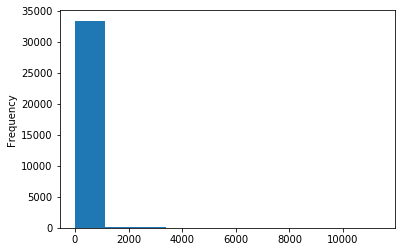

In [94]:
print(X_test.columns)
display(X_test)
display(y_test)

# X_test.SUNSHINE.plot(kind='hist')

indexes = X_test[X_test['SUNSHINE'] == 0].index
y_test.loc[indexes].sum(axis=1).plot(kind='hist')

In [128]:
# print(spectra_IOU(np.array([[10, 10, 10, 10, 10]]), np.array([1, 3, 1, 3, 2])))

(981,) (981,) (981,)


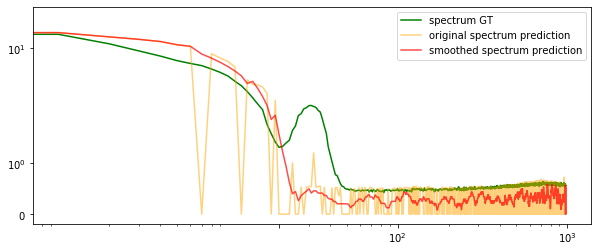

In [236]:
plt.figure(figsize=(10,4))
plt.plot(specs_gt, label = 'spectrum GT', color='green')
plt.plot(specs_pred, label = 'original spectrum prediction', color='orange', alpha=0.5)
# print(temp.std())
specs_smooth = smooth(specs_pred, 12)
print(specs_smooth.shape, specs_pred.shape, specs_gt.shape)
plt.plot(specs_smooth, label = 'smoothed spectrum prediction', color='red', alpha=0.7)
plt.xscale('log')
plt.yscale('symlog')
plt.xticks([20, 100, 1000])
plt.legend()
plt.show()
print()

In [92]:
# """ K-Means direct predictions"""
# indexes = y_test.index
# pred_clusters = model_cluster.predict(X_test_processed.loc[indexes, selected_features])
# preds = [spec_cluster[cluster] for cluster in pred_clusters]
# preds = np.array(preds)
# print(pred_clusters)
# print(preds.shape)
# print(f'Whole testing set: {len(preds)} samples.')
# print(spectra_IOU(preds, (y_test.loc[indexes])).mean())
# print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')

# total_count_preds = preds.sum(axis=1)
# total_count_targets = y_test.loc[indexes].sum(axis=1)

# plt.figure(figsize=(8,8))
# plt.plot([0, max(total_count_targets)], [0, max(total_count_targets)], '--', color='red')
# plt.scatter(total_count_preds, total_count_targets, alpha=0.8)

# del preds, total_count_preds, total_count_targets
# print('RAM Used:', round(psutil.virtual_memory()[3]/1000000000, 2), 'Gb')

In [193]:
# y_test[y_test.sum(axis=1) == 0].index
# y_temp.sum(axis=1) == 0
# y_test.mean()

20      2.262268
21      1.265588
22      0.743460
23      0.473393
24      0.336963
          ...   
996     0.007994
997     0.008211
998     0.007679
999     0.008173
1000    0.007945
Length: 981, dtype: float64

Losses:
	 Mean: 0.457271933555603
	 Median: 0.457271933555603
	 75-percentile: 0.457271933555603
	 99-percentile: 0.457271933555603


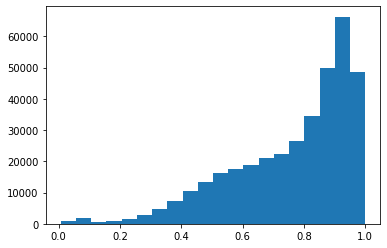

0.9897991209803276
0.9046254061543424
0.6831427404716127
0.2831328400313586
7326


In [123]:
preds = dnn(TensorX_test)
iou = spectra_IOU(preds.detach().cpu().numpy(), Tensory_test.detach().cpu().numpy())
losses = criterion(preds, Tensory_test)
losses = losses.detach().cpu().numpy()
print('Losses:')
print(f'\t Mean: {losses.mean()}')
print(f'\t Median: {np.quantile(losses, q=0.5)}')
print(f'\t 75-percentile: {np.quantile(losses, q=0.75)}')
print(f'\t 99-percentile: {np.quantile(losses, q=0.99)}')

plt.hist(iou, bins=20)
plt.show()

extra_easy = np.quantile(iou, 0.98)
easy = np.quantile(iou, 0.7)
hard = np.quantile(iou, 0.3)
extra_hard = np.quantile(iou, 0.02)
print(extra_easy)
print(easy)
print(hard)
print(extra_hard)

(array([3.64512e+05, 1.67300e+03, 8.60000e+01, 1.00000e+01, 2.00000e+00,
        0.00000e+00, 0.00000e+00, 0.00000e+00, 0.00000e+00, 1.00000e+00]),
 array([ 0.       ,  5.5876417, 11.175283 , 16.762926 , 22.350567 ,
        27.93821  , 33.525852 , 39.113495 , 44.701134 , 50.288776 ,
        55.87642  ], dtype=float32),
 <a list of 10 Patch objects>)

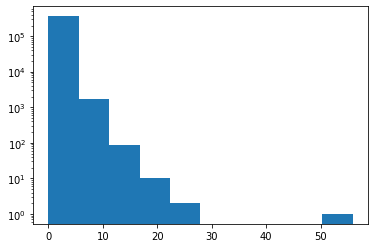

In [124]:
sample_losses = []
for i in tqdm(range(0, len(preds), 1)):
    sample_losses.append(criterion(preds[i], Tensory_test[i]).detach().cpu().numpy())
    
sample_losses = np.array(sample_losses)
plt.hist(sample_losses, log=True)

# idx_hard = np.where(sample_losses >= 1)[0]
# print(len(idx_hard))
# print(idx_hard)

In [87]:
print(criterion(torch.Tensor([10]), torch.Tensor([100])))

temp1 = torch.log10(torch.Tensor([501])).detach().numpy()
temp2 = torch.log10(torch.Tensor([1001])).detach().numpy()
print(temp1)
print(temp2)
print(10*(temp1-temp2)**2)

tensor(9.2723)
[2.6998377]
[3.0004342]
[0.90358245]


In [314]:
# """ Qualitative Investigate random sample with PREDS photon counts is high"""

# preds = dnn(TensorX_test)
# preds = preds.detach().cpu().numpy()
# ij = np.where(preds > 100)
# idx = ij[0][0]

# smpl_X_test = TensorX_test[idx:idx+1]
# smpl_y_test = y_test.iloc[idx:idx+1]
# preds = dnn(smpl_X_test)
# preds = torch.round(preds)
# preds = preds.detach().cpu().numpy()

# """ Ground Truth Spectrum Visualization"""
# # display(smpl_y_test)
# print(smpl_y_test.columns)
# ax = smpl_y_test.iloc[0].plot(kind='bar', 
#                               title=f'Ground Truth Spectrum', 
#                               figsize=(8,4))
# ax.set_xlabel('X-Ray Spectral Bin')
# ax.set_ylabel('Photon Counts')
# # ax.set_ylim([0, 9000])
# ax.grid(axis='y')
# plt.show()

# """ Predicted Spectrum Visualization"""
# df_preds = pd.DataFrame(preds.reshape(1,-1), columns=y.columns)
# ax = df_preds.iloc[0].plot(kind='bar', 
#                            title=f'Predicted Spectrum', 
#                            figsize=(8,4))
# ax.set_xlabel('X-Ray Spectral Bin')
# ax.set_ylabel('Photon Counts')
# # ax.set_ylim([0, 9000])
# ax.grid(axis='y')
# plt.show()
# # print(np.round(preds))
# # print(np.array(smpl_y_test))

# print(preds)